In [ ]:
import scipy.io
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import math
import time
import sys
from tqdm import tqdm
import shutil, json

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1

    return patchesData, patchesLabels.astype("int")

In [ ]:
!mkdir teacher
!mkdir student

In [ ]:
data = envi.open('./drive/MyDrive/HSI-datasets/IP_DataSet/indianpines_ds_raw.hdr', \
                './drive/MyDrive/HSI-datasets/IP_DataSet/indianpines_ds_raw.raw')

NameError: ignored

In [ ]:
disjoint_pixels = envi.open('./drive/MyDrive/HSI-datasets/IP_TrainSet/indianpines_ts_raw_classes.hdr', \
                './drive/MyDrive/HSI-datasets/IP_TrainSet/indianpines_ts_raw_classes.raw')

In [ ]:
disjoint_pixels = disjoint_pixels.read_bands([0])
disjoint_pixels = disjoint_pixels.reshape(disjoint_pixels.shape[0], disjoint_pixels.shape[1])

In [ ]:
y_train = copy.deepcopy(disjoint_pixels)
for i, val in enumerate([0,2,3,5,6,8,10,11,12,14,1,4,7,9,13,15,16]): y_train[disjoint_pixels==i] = val

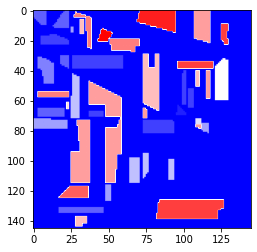

In [ ]:
# Plot the grid
plt.imshow(y_train, cmap='bwr')
plt.show()

In [ ]:
labels = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/indian_pines_gt.mat')
labels = labels['indian_pines_gt']

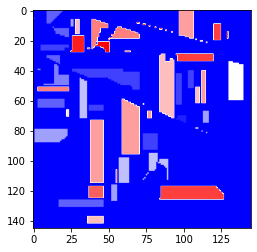

In [ ]:
# Plot the grid
plt.imshow(y_test, cmap='bwr')
plt.show()

In [ ]:
dataset = ['India', 'Pavia'][0]
random_split = False

In [ ]:
if dataset == 'India':
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/indian_pines_corrected.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indianpines_disjoint_dset.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indian_pines_gt.mat')

    X_all = raw_data['indian_pines_corrected']
    y_disjoint = disjoint_data['indianpines_disjoint_dset']
    y_all = all_labels['indian_pines_gt']

    test_ratio = 0.45
else:
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/paviaU.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/TRpavia_fixed.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/paviaU_gt.mat')

    X_all = raw_data['paviaU']
    y_disjoint = disjoint_data['TRpavia_fixed']
    y_all = all_labels['paviaU_gt']

    test_ratio = 0.93

In [ ]:
np.unique(y_disjoint, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 array([15336,   762,   435,   232,   394,   235,   470,  1424,   328,
          728,    29,   146,    16,    10,   132,   291,    57]))

In [ ]:
np.unique(y_all, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 array([10776,    46,  1428,   830,   237,   483,   730,    28,   478,
           20,   972,  2455,   593,   205,  1265,   386,    93]))

In [ ]:
import scipy.io
import numpy as np
import copy
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# -*- coding: utf-8 -*-
# Torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchsummary import summary
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms

In [ ]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [ ]:
num_channels = X_all.shape[-1]
W = X_all.shape[0]
H = X_all.shape[1]
num_components = 40
window = 19
batch_size = 100

In [ ]:
X_all = X_all.reshape(W*H, num_channels)
y_disjoint = y_disjoint.reshape(-1, 1).flatten()

X_all = X_all.astype(np.float32)

In [ ]:
pca = PCA(n_components=num_components)
X_all = pca.fit_transform(X_all)

X_all = X_all.reshape(W, H, num_components)

In [ ]:
X, y = createImageCubes(X_all, y_all, windowSize=window, removeZeroLabels = False)

In [ ]:
np.save('data.npy', X)
np.save('labels.npy', y)

In [ ]:
del X_all, y_all, X, y, raw_data

In [ ]:
X = np.load('data.npy', mmap_mode='c')
y = np.load('labels.npy', mmap_mode='c')

In [ ]:
X = np.transpose(X, (0, 3, 1, 2))

In [ ]:
X.shape

(21025, 40, 19, 19)

In [ ]:
if random_split:
    nonzero_idx = np.where(y != 0)
    X = X[nonzero_idx]
    y = y[nonzero_idx]
    y = y - 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
else:
    train_idx = np.where((y_disjoint != 0) & (y != 0))
    X_train = X[train_idx]
    y_train = y[train_idx]

    test_idx = np.where((y_disjoint == 0) & (y != 0))
    X_test = X[test_idx]
    y_test = y[test_idx]

    y_train -= 1
    y_test -= 1

    print('Disjoint')

Disjoint


In [ ]:
X_train = X_train.reshape(X_train.shape[0], num_components*window*window)
X_test = X_test.reshape(X_test.shape[0], num_components*window*window)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], num_components, window, window)
X_test = X_test.reshape(X_test.shape[0], num_components, window, window)

In [ ]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([  21,  753,  426,  138,  209,  376,   26,  228,   10,  469, 1390,
         311,  125,  720,  287,   49]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_val) # transform to torch tensor
tensor_y = torch.Tensor(y_val)
tensor_y = tensor_y.type(torch.LongTensor)

val_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=batch_size) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test)
tensor_y = tensor_y.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=batch_size) # create your dataloader

In [ ]:
class cnn2d(nn.Module):
    """
    CNN2d network
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(0.5)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

    def __init__(self, input_channels, n_classes, cfg=(50, 100), fc=100):
        super(cnn2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=cfg[0], kernel_size=(5, 5))
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=cfg[0], out_channels=cfg[1], kernel_size=(5, 5))
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d((2, 2))

        self.fc1 = nn.Linear(int(25*cfg[1]), fc)
        self.relu3 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(fc, n_classes)

        self.apply(self.weight_init)

    def get_feat_modules(self):
        feat_m = nn.ModuleList([])
        feat_m.append(self.conv1)
        feat_m.append(self.relu1)
        feat_m.append(self.conv2)
        feat_m.append(self.relu2)
        feat_m.append(self.pool)
        feat_m.append(self.fc1)
        feat_m.append(self.relu3)
        feat_m.append(self.fc2)
        return feat_m
    
    def distill_seq(self):
        feat_m = nn.ModuleList([])  
        #feat_m.append(self.conv1)       
        feat_m.append(nn.Sequential(
            self.conv1, self.relu1))
        feat_m.append(nn.Sequential(
            self.conv2, self.relu2))
        feat_m.append(nn.Sequential(
            self.pool,
            nn.Flatten()))
        feat_m.append(nn.Sequential(
            self.pool, nn.Flatten(), self.fc1, self.relu3, self.fc2))
        return feat_m

    def forward(self, x, is_feat=False, preact=False):
        x = self.conv1(x)
        x = self.relu1(x)
        f0 = x
        x = self.conv2(x)
        f1_pre = x
        x = self.relu2(x)
        f1 = x
        x = self.pool(x)
        x = x.view(x.size(0), -1) # flatten all dimensions except batch
        f2 = x
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        if is_feat:
            if preact:
                return [f0, f1_pre, f2], x
            else:
                return [f0, f1, f2], x
        else:
            return x

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg, losses.avg

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class RunningAverage():
    """A simple class that maintains the running average of a quantity
    
    Example:
    ```
    loss_avg = RunningAverage()
    loss_avg.update(2)
    loss_avg.update(4)
    loss_avg() = 3
    ```
    """
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def value(self):
        return self.total/float(self.steps)

# **Method: Offline Distillation**

In [ ]:
save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))
kd_method = ['kd', 'hint', 'crd', 'attention', 'fsp', 'correlation', 'simkd'][-1]

kd_T = 10 # temperature of soft target method
alpha = 1
beta = 1
gamma = 1
learning_rate = 8e-4
feat_dim = 32 # feature dimention of intermediate layers
factor = 2

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.89  # prune ratio of conv layers
linear_r = 0.89 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [ ]:
class HintLoss(nn.Module):
    """Fitnets: hints for thin deep nets, ICLR 2015"""
    def __init__(self):
        super(HintLoss, self).__init__()
        self.crit = nn.MSELoss()

    def forward(self, f_s, f_t):
        loss = self.crit(f_s, f_t)
        return loss

In [ ]:
class FSP(nn.Module):
    """A Gift from Knowledge Distillation:
    Fast Optimization, Network Minimization and Transfer Learning"""
    def __init__(self, s_shapes, t_shapes):
        super(FSP, self).__init__()
        assert len(s_shapes) == len(t_shapes), 'unequal length of feat list'
        s_c = [s[1] for s in s_shapes]
        t_c = [t[1] for t in t_shapes]
        print(s_shapes)
        print(t_shapes)
        # if np.any(np.asarray(s_c) != np.asarray(t_c)):
        #     raise ValueError('num of channels not equal (error in FSP)')

    def forward(self, g_s, g_t):
        s_fsp = self.compute_fsp(g_s)
        t_fsp = self.compute_fsp(g_t)
        loss_group = [self.compute_loss(s, t) for s, t in zip(s_fsp, t_fsp)]
        return loss_group

    @staticmethod
    def compute_loss(s, t):
        return (s - t).pow(2).mean()

    @staticmethod
    def compute_fsp(g):
        fsp_list = []
        for i in range(len(g) - 1):
            bot, top = g[i], g[i + 1]
            b_H, t_H = bot.shape[2], top.shape[2]
            if b_H > t_H:
                bot = F.adaptive_avg_pool2d(bot, (t_H, t_H))
            elif b_H < t_H:
                top = F.adaptive_avg_pool2d(top, (b_H, b_H))
            else:
                pass
            bot = bot.unsqueeze(1)
            top = top.unsqueeze(2)
            bot = bot.view(bot.shape[0], bot.shape[1], bot.shape[2], -1)
            top = top.view(top.shape[0], top.shape[1], top.shape[2], -1)

            fsp = (bot * top).mean(-1)
            fsp_list.append(fsp)
        return fsp_list

In [ ]:
class Correlation(nn.Module):
    """Correlation Congruence for Knowledge Distillation, ICCV 2019.
    The authors nicely shared the code with me. I restructured their code to be 
    compatible with my running framework. Credits go to the original author"""
    def __init__(self):
        super(Correlation, self).__init__()

    def forward(self, f_s, f_t):
        delta = torch.abs(f_s - f_t)
        loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
        return loss

In [ ]:
class Attention(nn.Module):
    """Paying More Attention to Attention: Improving the Performance of Convolutional Neural Networks
    via Attention Transfer
    code: https://github.com/szagoruyko/attention-transfer"""
    def __init__(self, p=2):
        super(Attention, self).__init__()
        self.p = p

    def forward(self, g_s, g_t):
        return [self.at_loss(f_s, f_t) for f_s, f_t in zip(g_s, g_t)]

    def at_loss(self, f_s, f_t):
        s_H, t_H = f_s.shape[2], f_t.shape[2]
        if s_H > t_H:
            f_s = F.adaptive_avg_pool2d(f_s, (t_H, t_H))
        elif s_H < t_H:
            f_t = F.adaptive_avg_pool2d(f_t, (s_H, s_H))
        else:
            pass
        return (self.at(f_s) - self.at(f_t)).pow(2).mean()

    def at(self, f):
        return F.normalize(f.pow(self.p).mean(1).view(f.size(0), -1))

In [ ]:
class LinearEmbed(nn.Module):
    """Linear Embedding"""
    def __init__(self, dim_in=1024, dim_out=128):
        super(LinearEmbed, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [ ]:
class ConvReg(nn.Module):
    """Convolutional regression for FitNet"""
    def __init__(self, s_shape, t_shape, use_relu=True):
        super(ConvReg, self).__init__()
        self.use_relu = use_relu
        s_N, s_C, s_H, s_W = s_shape
        t_N, t_C, t_H, t_W = t_shape
        if s_H == 2 * t_H:
            self.conv = nn.Conv2d(s_C, t_C, kernel_size=3, stride=2, padding=1)
        elif s_H * 2 == t_H:
            self.conv = nn.ConvTranspose2d(s_C, t_C, kernel_size=4, stride=2, padding=1)
        elif s_H >= t_H:
            self.conv = nn.Conv2d(s_C, t_C, kernel_size=(1+s_H-t_H, 1+s_W-t_W))
        else:
            raise NotImplemented('student size {}, teacher size {}'.format(s_H, t_H))
        self.bn = nn.BatchNorm2d(t_C)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.use_relu:
            return self.relu(self.bn(x))
        else:
            return self.bn(x)

In [ ]:
class Regress(nn.Module):
    """Simple Linear Regression for hints"""
    def __init__(self, dim_in=1024, dim_out=1024):
        super(Regress, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        x = self.relu(x)
        return x

In [ ]:
class CAMKD(nn.Module):
    def __init__(self):
        super(CAMKD, self).__init__()
        # self.crit_ce = nn.CrossEntropyLoss()
        self.crit_ce = nn.CrossEntropyLoss(reduction='none')
        self.crit_mse = nn.MSELoss(reduction='none')
        # self.crit_mse = nn.MSELoss(reduction='mean')

    def forward(self, trans_feat_s_list, mid_feat_t_list, output_feat_t_list, target):
    
        bsz = target.shape[0]
        loss_t = [self.crit_ce(logit_t, target) for logit_t in output_feat_t_list]
        num_teacher = len(trans_feat_s_list)
        loss_t = torch.stack(loss_t, dim=0)
        weight = (1.0 - F.softmax(loss_t, dim=0)) / (num_teacher - 1)
        loss_st = []
        for mid_feat_s, mid_feat_t in zip(trans_feat_s_list, mid_feat_t_list):
            tmp_loss_st = self.crit_mse(mid_feat_s, mid_feat_t).reshape(bsz, -1).mean(-1)
            loss_st.append(tmp_loss_st)
        loss_st = torch.stack(loss_st, dim=0)
        loss = torch.mul(weight, loss_st).sum()
        # loss = torch.mul(attention, loss_st).sum()
        loss /= (1.0*bsz*num_teacher)

        # avg weight
        # loss_st = []
        # for mid_feat_s, mid_feat_t in zip(trans_feat_s_list, mid_feat_t_list):
        #     tmp_loss_st = self.crit_mse(mid_feat_s, mid_feat_t)
        #     loss_st.append(tmp_loss_st)
        # loss_st = torch.stack(loss_st, dim=0)
        # loss = loss_st.mean(0)
        return loss, weight

In [ ]:
class SimKD(nn.Module):
    """CVPR-2022: Knowledge Distillation with the Reused Teacher Classifier"""
    def __init__(self, *, s_n, t_n, factor=2): 
        super(SimKD, self).__init__()
       
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))       

        def conv1x1(in_channels, out_channels, stride=1):
            return nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride, bias=False)
        def conv3x3(in_channels, out_channels, stride=1, groups=1):
            return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False, groups=groups)
        
        # A bottleneck design to reduce extra parameters
        setattr(self, 'transfer', nn.Sequential(
            conv1x1(s_n, t_n//factor),
            nn.BatchNorm2d(t_n//factor),
            nn.ReLU(inplace=True),
            conv3x3(t_n//factor, t_n//factor),
            # depthwise convolution
            #conv3x3(t_n//factor, t_n//factor, groups=t_n//factor),
            nn.BatchNorm2d(t_n//factor),
            nn.ReLU(inplace=True),
            conv1x1(t_n//factor, t_n),
            nn.BatchNorm2d(t_n),
            nn.ReLU(inplace=True),
            ))
        
    def forward(self, feat_s, feat_t, cls_t):
        
        # Spatial Dimension Alignment
        s_H, t_H = feat_s.shape[2], feat_t.shape[2]
        if s_H > t_H:
            source = F.adaptive_avg_pool2d(feat_s, (t_H, t_H))
            target = feat_t
        else:
            source = feat_s
            target = F.adaptive_avg_pool2d(feat_t, (s_H, s_H))
        
        trans_feat_t=target
        
        # Channel Alignment
        trans_feat_s = getattr(self, 'transfer')(source)

        # Prediction via Teacher Classifier
        temp_feat = self.avg_pool(trans_feat_s)
        temp_feat = temp_feat.view(temp_feat.size(0), -1)
        pred_feat_s = cls_t(temp_feat)
        
        return trans_feat_s, trans_feat_t, pred_feat_s

In [ ]:
def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # if idx % print_freq == 0:
            #     print('Test: [{0}/{1}]\t'
            #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
            #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
            #            idx, len(val_loader), batch_time=batch_time, loss=losses,
            #            top1=top1, top5=top5))

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg, losses.avg

In [ ]:
def train_vanilla(epoch, train_loader, model, criterion, optimizer):
    """vanilla training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for idx, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        output = model(input)
        loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

        # tensorboard logger
        pass

        # print info
        # if idx % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
        #            epoch, idx, len(train_loader), batch_time=batch_time,
        #            data_time=data_time, loss=losses, top1=top1, top5=top5))
        #     sys.stdout.flush()

    print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
def train_distill(epoch, train_loader, test_loader, module_list, criterion_list, optimizer, distill):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    module_list[-1].eval()

    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t = module_list[-1]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    for idx, data in enumerate(train_loader):
        input, target = data
        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        preact = False

        feat_s, logit_s = model_s(input, is_feat=True, preact=preact)
        with torch.no_grad():
            feat_t, logit_t = model_t(input, is_feat=True, preact=preact)
            feat_t = [f.detach() for f in feat_t]

        cls_t = model_t.get_feat_modules()[-1]
        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        loss_div = criterion_div(logit_s, logit_t)

        # other kd beyond KL divergence
        if distill == 'kd':
            loss_kd = 0
        elif distill == 'hint':
            f_s = module_list[1](feat_s[1])
            f_t = feat_t[1]
            loss_kd = criterion_kd(f_s, f_t)
        elif distill == 'crd':
            f_s = feat_s[-1]
            f_t = feat_t[-1]
            loss_kd = criterion_kd(f_s, f_t, index, contrast_idx)
        elif distill == 'attention':
            g_s = feat_s[1:-1]
            g_t = feat_t[1:-1]
            loss_group = criterion_kd(g_s, g_t)
            loss_kd = sum(loss_group)
        elif distill == 'nst':
            g_s = feat_s[1:-1]
            g_t = feat_t[1:-1]
            loss_group = criterion_kd(g_s, g_t)
            loss_kd = sum(loss_group)
        elif distill == 'similarity':
            g_s = [feat_s[-2]]
            g_t = [feat_t[-2]]
            loss_group = criterion_kd(g_s, g_t)
            loss_kd = sum(loss_group)
        elif distill == 'rkd':
            f_s = feat_s[-1]
            f_t = feat_t[-1]
            loss_kd = criterion_kd(f_s, f_t)
        elif distill == 'pkt':
            f_s = feat_s[-1]
            f_t = feat_t[-1]
            loss_kd = criterion_kd(f_s, f_t)
        elif distill == 'kdsvd':
            g_s = feat_s[1:-1]
            g_t = feat_t[1:-1]
            loss_group = criterion_kd(g_s, g_t)
            loss_kd = sum(loss_group)
        elif distill == 'correlation':
            f_s = module_list[1](feat_s[-1])
            f_t = module_list[2](feat_t[-1])
            loss_kd = criterion_kd(f_s, f_t)
        elif distill == 'vid':
            g_s = feat_s[1:-1]
            g_t = feat_t[1:-1]
            loss_group = [c(f_s, f_t) for f_s, f_t, c in zip(g_s, g_t, criterion_kd)]
            loss_kd = sum(loss_group)
        elif distill == 'abound':
            # can also add loss to this stage
            loss_kd = 0
        elif distill == 'fsp':
            # can also add loss to this stage
            loss_kd = 0
        elif distill == 'factor':
            factor_s = module_list[1](feat_s[-2])
            factor_t = module_list[2](feat_t[-2], is_factor=True)
            loss_kd = criterion_kd(factor_s, factor_t)
        elif distill == 'simkd':
            trans_feat_s, trans_feat_t, pred_feat_s = module_list[1](feat_s[-2], feat_t[-2], cls_t)
            logit_s = pred_feat_s
            loss_kd = criterion_kd(trans_feat_s, trans_feat_t)
        else:
            raise NotImplementedError(distill)

        loss = alpha * loss_cls + beta * loss_div + gamma * loss_kd

        acc1, acc5 = accuracy(logit_s, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))
        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print info
        # if idx % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
        #         epoch, idx, len(train_loader), batch_time=batch_time,
        #         data_time=data_time, loss=losses, top1=top1, top5=top5))
        #     sys.stdout.flush()

        # print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
        #       .format(top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
def train_teacher(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=t_cfg, fc=t_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # logger.log_value('train_acc', train_acc, epoch)
        # logger.log_value('train_loss', train_loss, epoch)

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # logger.log_value('test_acc', test_acc, epoch)
        # logger.log_value('test_acc_top5', test_acc_top5, epoch)
        # logger.log_value('test_loss', test_loss, epoch)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/t_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
def train_student(train_loader, val_loader, distill, epochs):
    best_acc = 0

    # # tensorboard logger
    # logger = tb_logger.Logger(logdir='./student/student_tensorboard', flush_secs=2)
    # model
    model_t = load_teacher()
    model_s = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    data = torch.randn(2, num_components, window, window)
    model_t.eval()
    model_s.eval()
    feat_t, _ = model_t(data, is_feat=True)
    feat_s, _ = model_s(data, is_feat=True)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T)
    if distill == 'kd':
        criterion_kd = DistillKL(kd_T)
    elif distill == 'hint':
        criterion_kd = HintLoss()
        regress_s = ConvReg(feat_s[1].shape, feat_t[1].shape)
        module_list.append(regress_s)
        trainable_list.append(regress_s)
    elif distill == 'crd':
        s_dim = feat_s[-1].shape[1]
        t_dim = feat_t[-1].shape[1]
        n_data = n_data
        criterion_kd = CRDLoss(opt)
        module_list.append(criterion_kd.embed_s)
        module_list.append(criterion_kd.embed_t)
        trainable_list.append(criterion_kd.embed_s)
        trainable_list.append(criterion_kd.embed_t)
    elif distill == 'attention':
        criterion_kd = Attention()
    elif distill == 'nst':
        criterion_kd = NSTLoss()
    elif distill == 'similarity':
        criterion_kd = Similarity()
    elif distill == 'rkd':
        criterion_kd = RKDLoss()
    elif distill == 'pkt':
        criterion_kd = PKT()
    elif distill == 'kdsvd':
        criterion_kd = KDSVD()
    elif distill == 'correlation':
        criterion_kd = Correlation()
        embed_s = LinearEmbed(feat_s[-1].shape[1], feat_dim)
        embed_t = LinearEmbed(feat_t[-1].shape[1], feat_dim)
        module_list.append(embed_s)
        module_list.append(embed_t)
        trainable_list.append(embed_s)
        trainable_list.append(embed_t)
    elif distill == 'vid':
        s_n = [f.shape[1] for f in feat_s[1:-1]]
        t_n = [f.shape[1] for f in feat_t[1:-1]]
        criterion_kd = nn.ModuleList(
            [VIDLoss(s, t, t) for s, t in zip(s_n, t_n)]
        )
        # add this as some parameters in VIDLoss need to be updated
        trainable_list.append(criterion_kd)
    elif distill == 'abound':
        s_shapes = [f.shape for f in feat_s[1:-1]]
        t_shapes = [f.shape for f in feat_t[1:-1]]
        connector = Connector(s_shapes, t_shapes)
        # init stage training
        init_trainable_list = nn.ModuleList([])
        init_trainable_list.append(connector)
        init_trainable_list.append(model_s.get_feat_modules())
        criterion_kd = ABLoss(len(feat_s[1:-1]))
        init(model_s, model_t, init_trainable_list, criterion_kd, train_loader, logger, distill)
        # classification
        module_list.append(connector)
    elif distill == 'factor':
        s_shape = feat_s[-2].shape
        t_shape = feat_t[-2].shape
        paraphraser = Paraphraser(t_shape)
        translator = Translator(s_shape, t_shape)
        # init stage training
        init_trainable_list = nn.ModuleList([])
        init_trainable_list.append(paraphraser)
        criterion_init = nn.MSELoss()
        init(model_s, model_t, init_trainable_list, criterion_init, train_loader, logger, distill)
        # classification
        criterion_kd = FactorTransfer()
        module_list.append(translator)
        module_list.append(paraphraser)
        trainable_list.append(translator)
    elif distill == 'fsp':
        s_shapes = [s.shape for s in feat_s[:-1]]
        t_shapes = [t.shape for t in feat_t[:-1]]
        criterion_kd = FSP(s_shapes, t_shapes)
        # init stage training
        init_trainable_list = nn.ModuleList([])
        init_trainable_list.append(model_s.get_feat_modules())
        init(model_s, model_t, init_trainable_list, criterion_kd, train_loader, logger, distill)
        # classification training
        pass
    elif distill == 'simkd':
        s_n = feat_s[-2].shape[1]
        t_n = feat_t[-2].shape[1]
        model_simkd = SimKD(s_n= s_n, t_n=t_n, factor=factor)
        criterion_kd = nn.MSELoss()
        module_list.append(model_simkd)
        trainable_list.append(model_simkd)
    else:
        raise NotImplementedError(distill)

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.Adam(trainable_list.parameters(), lr=learning_rate, weight_decay=0.02)

    # append teacher after optimizer to avoid weight_decay
    module_list.append(model_t)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        cudnn.benchmark = True

    # validate teacher accuracy
    teacher_acc, _, _ = validate(val_loader, model_t, criterion_cls)
    print('teacher accuracy: ', teacher_acc)

    # routine
    for epoch in range(1, epochs + 1):

        # adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_distill(epoch, train_loader, val_loader, module_list, criterion_list, optimizer, distill)

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        # logger.log_value('train_acc', train_acc, epoch)
        # logger.log_value('train_loss', train_loss, epoch)

        test_acc, tect_acc_top5, test_loss = validate(val_loader, model_s, criterion_cls)

        # logger.log_value('test_acc', test_acc, epoch)
        # logger.log_value('test_loss', test_loss, epoch)
        # logger.log_value('test_acc_top5', tect_acc_top5, epoch)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model_s.state_dict(),
                'best_acc': best_acc,
            }
            save_file = './student/s_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model_s.state_dict(),
                'accuracy': test_acc,
            }
            save_file = os.path.join('./student/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch. 
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model_s.state_dict(),
    }
    save_file = './student/s_last.pth'
    torch.save(state, save_file)

In [ ]:
def load_teacher(model_path='./teacher/t_best.pth'):
    print('==> loading teacher model')
    model = cnn2d(num_components, num_classes, cfg=t_cfg, fc=t_fc)
    model.load_state_dict(torch.load(model_path)['model'])
    print('==> done')
    return model

In [ ]:
train_teacher(train_dataloader, val_dataloader, epochs=100)

==> training...
 * Acc@1 47.030 Acc@5 83.964
epoch 1, total time 8.82
 * Acc@1 63.667 Acc@5 91.333
saving the best model!
==> training...
 * Acc@1 78.434 Acc@5 96.919
epoch 2, total time 0.16
 * Acc@1 89.667 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 90.757 Acc@5 99.926
epoch 3, total time 0.16
 * Acc@1 93.667 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 95.063 Acc@5 100.000
epoch 4, total time 0.16
 * Acc@1 96.333 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 97.587 Acc@5 100.000
epoch 5, total time 0.16
 * Acc@1 97.333 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 98.738 Acc@5 100.000
epoch 6, total time 0.16
 * Acc@1 97.667 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 99.258 Acc@5 100.000
epoch 7, total time 0.16
 * Acc@1 97.333 Acc@5 100.000
==> training...
 * Acc@1 99.517 Acc@5 100.000
epoch 8, total time 0.16
 * Acc@1 98.333 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 99.777 Acc

In [ ]:
train_student(train_dataloader, val_dataloader, distill=kd_method, epochs=100)

==> loading teacher model
==> done
 * Acc@1 99.667 Acc@5 100.000
teacher accuracy:  tensor(99.6667, device='cuda:0')
==> training...
epoch 1, total time 0.43
 * Acc@1 40.667 Acc@5 69.333
saving the best model!
==> training...
epoch 2, total time 0.23
 * Acc@1 42.000 Acc@5 79.000
saving the best model!
==> training...
epoch 3, total time 0.22
 * Acc@1 55.333 Acc@5 88.333
saving the best model!
==> training...
epoch 4, total time 0.22
 * Acc@1 62.000 Acc@5 92.000
saving the best model!
==> training...
epoch 5, total time 0.22
 * Acc@1 71.333 Acc@5 96.000
saving the best model!
==> training...
epoch 6, total time 0.22
 * Acc@1 72.667 Acc@5 96.667
saving the best model!
==> training...
epoch 7, total time 0.22
 * Acc@1 73.000 Acc@5 96.667
saving the best model!
==> training...
epoch 8, total time 0.22
 * Acc@1 76.333 Acc@5 97.333
saving the best model!
==> training...
epoch 9, total time 0.22
 * Acc@1 79.333 Acc@5 98.000
saving the best model!
==> training...
epoch 10, total time 0.22
 * A

In [ ]:
t_model = cnn2d(num_components, num_classes, cfg=t_cfg, fc=t_fc)
t_model.load_state_dict(torch.load('./teacher/t_best.pth')['model'])

s_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
s_model.load_state_dict(torch.load('./student/s_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
t_model = t_model.to(cuda_device)
s_model = s_model.to(cuda_device)
t_acc_1, t_acc_5, t_loss = validate(test_dataloader, t_model, criterion)
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, s_model, criterion)

 * Acc@1 99.314 Acc@5 99.997
 * Acc@1 96.853 Acc@5 99.915


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Student top-1 test accuracy: {:.3f}".format(s_acc_1))

print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))
print("Student top-5 test accuracy: {:.3f}".format(s_acc_5))

Teacher top-1 test accuracy: 99.314
Student top-1 test accuracy: 96.853
Teacher top-5 test accuracy: 99.997
Student top-5 test accuracy: 99.915


In [ ]:
print('Num of teacher parameters:', sum(p.numel() for p in t_model.parameters() if p.requires_grad))
print('Num of student parameters:', sum(p.numel() for p in s_model.parameters() if p.requires_grad))

Num of teacher parameters: 426159
Num of student parameters: 8874


In [ ]:
print('Size teacher(MB):', os.path.getsize("./teacher/t_best.pth")/1e6)
print('Size student(MB):', os.path.getsize("./student/s_best.pth")/1e6)

Size teacher(MB): 5.122847
Size student(MB): 0.0384


In [ ]:
for name, p in s_model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 5000
conv1.bias 5
conv2.weight 1250
conv2.bias 10
fc1.weight 2500
fc1.bias 10
fc2.weight 90
fc2.bias 9


# **Offline Distillation: multi-teacher (CA-MKD)**



In [ ]:
# Official GitHub: https://github.com/Rorozhl/CA-MKD

num_teachers = 5
factor = 2
kd_T = 10 # temperature of soft target method
alpha = 1
beta = 1
gamma = 50
learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.89  # prune ratio of conv layers
linear_r = 0.89 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class DistillKL(nn.Module):
    """Distilling the Knowledge in a Neural Network"""
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t, is_ca=False):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        if is_ca: 
            loss = (nn.KLDivLoss(reduction='none')(p_s, p_t) * (self.T**2)).sum(-1)
        else:
            loss = nn.KLDivLoss(reduction='batchmean')(p_s, p_t) * (self.T**2)
        return loss

In [ ]:
class Embed(nn.Module):
    """Embedding module"""
    def __init__(self, dim_in=1024, dim_out=128, factor=2, convs=False):
        super(Embed, self).__init__()
        self.convs = convs
        if self.convs:
            self.transfer = nn.Sequential(
                nn.Conv2d(dim_in, dim_in//factor, kernel_size=1),
                nn.BatchNorm2d(dim_in//factor),
                nn.ReLU(inplace=True),
                nn.Conv2d(dim_in//factor, dim_in//factor, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim_in//factor),
                nn.ReLU(inplace=True), 
                nn.Conv2d(dim_in//factor, dim_out, kernel_size=1),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(inplace=True)              
            )
        else:
            self.transfer = nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=1),
                nn.BatchNorm2d(dim_out),
                nn.ReLU(inplace=True) 
            )


    def forward(self, x):
        x = self.transfer(x)
        return x

In [ ]:
class CalWeight(nn.Module):
    def __init__(self, feat_s, feat_t_list):
        super(CalWeight, self).__init__()

        # student和teacher都用最后一层
        s_channel = feat_s.shape[1]
        for i in range(len(feat_t_list)):
            t_channel = feat_t_list[i].shape[1]
            setattr(self, 'embed'+str(i), Embed(s_channel, t_channel, factor, False))


    def forward(self, feat_s, feat_t_list, model_t_list=None):
        tmp_model = [model_t.distill_seq() for model_t in model_t_list]
        trans_feat_s_list = []
        output_feat_t_list = []
        s_H = feat_s.shape[2]
        for i, mid_feat_t in enumerate(feat_t_list):
            t_H = mid_feat_t.shape[2]
            if s_H >= t_H:
                feat_s = F.adaptive_avg_pool2d(feat_s, (t_H, t_H))
            else:
                feat_s = F.interpolate(feat_s, size=(t_H, t_H), mode='bilinear')
            trans_feat_s = getattr(self, 'embed'+str(i))(feat_s)
            trans_feat_s_list.append(trans_feat_s)

            output_feat_t = tmp_model[i][-1](trans_feat_s)
            output_feat_t_list.append(output_feat_t)
        return trans_feat_s_list, output_feat_t_list

In [ ]:
def train_teacher(train_loader, val_loader, epochs, fname):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=t_cfg, fc=t_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/' + fname
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
def train_distill_multi_teacher(epoch, train_loader, test_loader, module_list, criterion_list, optimizer, distill):
    """One epoch distillation"""
    # set modules as train()
    for module in module_list:
        module.train()
    # set teacher as eval()
    [model_t.eval() for model_t in module_list[-num_teachers:]]

    criterion_cls = criterion_list[0]
    criterion_div = criterion_list[1]
    criterion_kd = criterion_list[2]

    model_s = module_list[0]
    model_t_list = module_list[-num_teachers:]

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()


    for idx, data in enumerate(train_loader):
        input, target = data
        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        preact = False

        feat_s, logit_s = model_s(input, is_feat=True, preact=preact)

        feat_t_list = []
        logit_t_list = []
        with torch.no_grad():
            for model_t in model_t_list:
                feat_t, logit_t = model_t(input, is_feat=True, preact=preact)
                feat_t = [f.detach() for f in feat_t]
                feat_t_list.append(feat_t)
                logit_t_list.append(logit_t)


        # cls + kl div
        loss_cls = criterion_cls(logit_s, target)
        # loss_div = criterion_div(logit_s, logit_t)

        criterion_cls_lc = nn.CrossEntropyLoss(reduction='none')
        loss_t_list = [criterion_cls_lc(logit_t, target) for logit_t in logit_t_list]
        loss_t = torch.stack(loss_t_list, dim=0)
        attention = (1.0 - F.softmax(loss_t, dim=0)) / (num_teachers - 1)
        loss_div_list = [criterion_div(logit_s, logit_t, is_ca=True)
                          for logit_t in logit_t_list]
        loss_div = torch.stack(loss_div_list, dim=0)
        bsz = loss_div.shape[1]
 
        loss_div = (torch.mul(attention, loss_div).sum()) / (1.0*bsz*num_teachers) 

        mid_feat_t_list = [feat_t[-2] for feat_t in feat_t_list]

        trans_feat_s_list, output_feat_t_list = module_list[1](feat_s[-2], mid_feat_t_list, model_t_list)

        loss_kd, weight = criterion_kd(trans_feat_s_list, mid_feat_t_list, output_feat_t_list, target)   

        loss = alpha * loss_cls + beta * loss_div + gamma * loss_kd

        acc1, acc5 = accuracy(logit_s, target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))
        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print info
        # if idx % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
        #         epoch, idx, len(train_loader), batch_time=batch_time,
        #         data_time=data_time, loss=losses, top1=top1, top5=top5))
        #     sys.stdout.flush()

        # print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
        #       .format(top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
for i in range(num_teachers):
    file_name = 't_best_' + str(i) + '.pth'
    train_teacher(train_dataloader, val_dataloader, epochs=200, fname=file_name)

==> training...
 * Acc@1 44.803 Acc@5 86.266
epoch 1, total time 0.21
 * Acc@1 52.333 Acc@5 94.333
saving the best model!
==> training...
 * Acc@1 73.274 Acc@5 97.068
epoch 2, total time 0.16
 * Acc@1 89.000 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 90.349 Acc@5 100.000
epoch 3, total time 0.17
 * Acc@1 93.000 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 95.137 Acc@5 100.000
epoch 4, total time 0.16
 * Acc@1 96.667 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 97.550 Acc@5 100.000
epoch 5, total time 0.16
 * Acc@1 97.667 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 98.441 Acc@5 100.000
epoch 6, total time 0.16
 * Acc@1 98.333 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 99.220 Acc@5 100.000
epoch 7, total time 0.16
 * Acc@1 98.333 Acc@5 100.000
==> training...
 * Acc@1 99.517 Acc@5 100.000
epoch 8, total time 0.16
 * Acc@1 99.000 Acc@5 100.000
saving the best model!
==> training...
 * Acc@1 99.480 Ac

In [ ]:
def train_multi(train_loader, val_loader, distill, epochs):
    best_acc = 0
    # model
    model_t_list = [load_teacher(model_path='./teacher/t_best_'+str(i)+'.pth')
                          for i in range(num_teachers)]
    model_s = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    data = torch.randn(2, num_components, window, window)

    feat_t_list = []
    model_s.eval()

    for model_t in model_t_list:
        model_t.eval()
    for model_t in model_t_list:
        feat_t, _ = model_t(data, is_feat=True)
        feat_t_list.append(feat_t)
    feat_s, _ = model_s(data, is_feat=True)

    module_list = nn.ModuleList([])
    module_list.append(model_s)
    trainable_list = nn.ModuleList([])
    trainable_list.append(model_s)

    criterion_cls = nn.CrossEntropyLoss()
    criterion_div = DistillKL(kd_T)
    
    criterion_kd = CAMKD()
    feat_t_list = [feat_t[-2] for feat_t in feat_t_list]
    cal_weight = CalWeight(feat_s[-2], feat_t_list)

    module_list.append(cal_weight)
    trainable_list.append(cal_weight)

    criterion_list = nn.ModuleList([])
    criterion_list.append(criterion_cls)    # classification loss
    criterion_list.append(criterion_div)    # KL divergence loss, original knowledge distillation
    criterion_list.append(criterion_kd)     # other knowledge distillation loss

    # optimizer
    optimizer = optim.Adam(trainable_list.parameters(), lr=learning_rate, weight_decay=0.02)

    # append teacher after optimizer to avoid weight_decay
    module_list.extend(model_t_list)

    if torch.cuda.is_available():
        module_list.cuda()
        criterion_list.cuda()
        cudnn.benchmark = True

    # validate teacher accuracy
    teacher_acc, _, _ = validate(val_loader, model_t_list[0], criterion_cls)
    print('teacher accuracy: ', teacher_acc)

    # routine
    for epoch in range(1, epochs + 1):

        # adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_distill_multi_teacher(epoch, train_loader, val_loader, module_list, criterion_list, optimizer, distill)

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, tect_acc_top5, test_loss = validate(val_loader, model_s, criterion_cls)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model_s.state_dict(),
                'best_acc': best_acc,
            }
            save_file = './student/s_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model_s.state_dict(),
                'accuracy': test_acc,
            }
            save_file = os.path.join('./student/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch. 
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model_s.state_dict(),
    }
    save_file = './student/s_last.pth'
    torch.save(state, save_file)

In [ ]:
train_multi(train_dataloader, val_dataloader, distill=kd_method, epochs=100)

==> loading teacher model
==> done
==> loading teacher model
==> done
==> loading teacher model
==> done
==> loading teacher model
==> done
==> loading teacher model
==> done
 * Acc@1 99.667 Acc@5 100.000
teacher accuracy:  tensor(99.6667, device='cuda:0')
==> training...
epoch 1, total time 0.47
 * Acc@1 40.667 Acc@5 85.667
saving the best model!
==> training...
epoch 2, total time 0.46
 * Acc@1 45.000 Acc@5 82.000
saving the best model!
==> training...
epoch 3, total time 0.47
 * Acc@1 56.000 Acc@5 94.000
saving the best model!
==> training...
epoch 4, total time 0.49
 * Acc@1 67.000 Acc@5 97.000
saving the best model!
==> training...
epoch 5, total time 0.47
 * Acc@1 69.667 Acc@5 98.000
saving the best model!
==> training...
epoch 6, total time 0.50
 * Acc@1 81.333 Acc@5 99.667
saving the best model!
==> training...
epoch 7, total time 0.51
 * Acc@1 86.000 Acc@5 99.667
saving the best model!
==> training...
epoch 8, total time 0.50
 * Acc@1 91.000 Acc@5 99.667
saving the best model!

In [ ]:
t_model = cnn2d(num_components, num_classes, cfg=t_cfg, fc=t_fc)
t_model.load_state_dict(torch.load('./teacher/t_best_0.pth')['model'])

s_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
s_model.load_state_dict(torch.load('./student/s_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
t_model = t_model.to(cuda_device)
s_model = s_model.to(cuda_device)
t_acc_1, t_acc_5, t_loss = validate(test_dataloader, t_model, criterion)
s_acc_1, s_acc_5, s_loss = validate(test_dataloader, s_model, criterion)

 * Acc@1 99.545 Acc@5 100.000
 * Acc@1 96.923 Acc@5 99.915


In [ ]:
print('Num of teacher parameters:', sum(p.numel() for p in t_model.parameters() if p.requires_grad))
print('Num of student parameters:', sum(p.numel() for p in s_model.parameters() if p.requires_grad))

Num of teacher parameters: 426159
Num of student parameters: 8874


# **Online Distillaiton: Deep Mutual Learning**

In [ ]:
model_num = 10
lr = 1e-3
num_train = len(train_dataloader)
num_valid = len(val_dataloader)
epochs = 100

loss_ce = nn.CrossEntropyLoss()
loss_kl = nn.KLDivLoss(reduction='batchmean')
best_valid_accs = [0.] * model_num

save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
models = []
optimizers = []

for i in range(model_num):
    # build models
    model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
    model.cuda()
    
    models.append(model)

    # initialize optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.02)
   
    optimizers.append(optimizer)

In [ ]:
def train_one_epoch(epoch, train_loader):
    """
    Train the model for 1 epoch of the training set.
    An epoch corresponds to one full pass through the entire
    training set in successive mini-batches.
    This is used by train() and should not be called manually.
    """
    batch_time = AverageMeter()
    losses = []
    accs = []

    for i in range(model_num):
        models[i].train()
        losses.append(AverageMeter())
        accs.append(AverageMeter())

    
    tic = time.time()
    with tqdm(total=num_train) as pbar:
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images), Variable(labels)
            
            #forward pass
            outputs=[]
            for model in models:
                outputs.append(model(images))
            for i in range(model_num):
                ce_loss = loss_ce(outputs[i], labels)
                kl_loss = 0
                for j in range(model_num):
                    if i!=j:
                        kl_loss += loss_kl(F.log_softmax(outputs[i], dim = 1), 
                                                F.softmax(Variable(outputs[j]), dim=1))
                loss = ce_loss + kl_loss / (model_num - 1)
                
                # measure accuracy and record loss
                prec = accuracy(outputs[i].data, labels.data, topk=(1,))[0]
                losses[i].update(loss.item(), images.size()[0])
                accs[i].update(prec.item(), images.size()[0])
            

                # compute gradients and update SGD
                optimizers[i].zero_grad()
                loss.backward()
                optimizers[i].step()

            # measure elapsed time
            toc = time.time()
            batch_time.update(toc-tic)

            pbar.set_description(
                (
                    "{:.1f}s - model1_loss: {:.3f} - model1_acc: {:.3f}".format(
                        (toc-tic), losses[0].avg, accs[0].avg
                    )
                )
            )
            batch_size = images.shape[0]
            pbar.update(batch_size)
        
        return losses, accs

In [ ]:
def validate_dml(epoch, valid_loader):
    """
    Evaluate the model on the validation set.
    """
    losses = []
    accs = []
    for i in range(model_num):
        models[i].eval()
        losses.append(AverageMeter())
        accs.append(AverageMeter())

    for i, (images, labels) in enumerate(valid_loader):

        images, labels = images.cuda(), labels.cuda()
        images, labels = Variable(images), Variable(labels)

        #forward pass
        outputs=[]
        for model in models:
            outputs.append(model(images))
        for i in range(model_num):
            ce_loss = loss_ce(outputs[i], labels)
            kl_loss = 0
            for j in range(model_num):
                if i!=j:
                    kl_loss += loss_kl(F.log_softmax(outputs[i], dim = 1),
                                            F.softmax(Variable(outputs[j]), dim=1))
            loss = ce_loss + kl_loss / (model_num - 1)

            # measure accuracy and record loss
            prec = accuracy(outputs[i].data, labels.data, topk=(1,))[0]
            losses[i].update(loss.item(), images.size()[0])
            accs[i].update(prec.item(), images.size()[0])

    return losses, accs

In [ ]:
def train_dml(train_loader, val_loader):
    """
    Train the model on the training set.
    A checkpoint of the model is saved after each epoch
    and if the validation accuracy is improved upon,
    a separate ckpt is created for use on the test set.
    """

    print("\n[*] Train on {} samples, validate on {} samples".format(
        num_train, num_valid)
    )

    for epoch in range(epochs):
        
        print(
            '\nEpoch: {}/{} - LR: {:.6f}'.format(
                epoch+1, epochs, optimizers[0].param_groups[0]['lr'],)
        )

        # train for 1 epoch
        train_losses, train_accs = train_one_epoch(epoch, train_loader)

        # evaluate on validation set
        valid_losses, valid_accs = validate_dml(epoch, val_loader)

        for i in range(model_num):
            is_best = valid_accs[i].avg> best_valid_accs[i]
            msg1 = "model_{:d}: train loss: {:.3f} - train acc: {:.3f} "
            msg2 = "- val loss: {:.3f} - val acc: {:.3f}"
            if is_best:
                #self.counter = 0
                msg2 += " [*]"
            msg = msg1 + msg2
            print(msg.format(i+1, train_losses[i].avg, train_accs[i].avg, valid_losses[i].avg, valid_accs[i].avg))

        # check for improvement
        #if not is_best:
            #self.counter += 1
        #if self.counter > self.train_patience:
            #print("[!] No improvement in a while, stopping training.")
            #return
            best_valid_accs[i] = max(valid_accs[i].avg, best_valid_accs[i])
            save_checkpoint(i,
                {'epoch': epoch + 1,
                'model_state': models[i].state_dict(),
                'optim_state': optimizers[i].state_dict(),
                'best_valid_acc': best_valid_accs[i],
                }, is_best
            )

In [ ]:
def save_checkpoint(i, state, is_best):
    """
    Save a copy of the model so that it can be loaded at a future
    date. This function is used when the model is being evaluated
    on the test data.
    If this model has reached the best validation accuracy thus
    far, a seperate file with the suffix `best` is created.
    """
    # print("[*] Saving model to {}".format(self.ckpt_dir))

    if is_best:
        filename = 'dml_' + str(i+1) + '_ckpt.pth.tar'
        ckpt_path = os.path.join('./', filename)
        torch.save(state, ckpt_path)

    # if is_best:
    #     filename = 'dml_' + str(i+1) + '_model_best.pth.tar'
    #     shutil.copyfile(
    #         ckpt_path, os.path.join(self.ckpt_dir, filename)
    #     )

In [ ]:
def test_dml(test_loader, model, criterion):
    """test"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(test_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # if idx % print_freq == 0:
            #     print('Test: [{0}/{1}]\t'
            #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
            #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
            #            idx, len(val_loader), batch_time=batch_time, loss=losses,
            #            top1=top1, top5=top5))

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg, losses.avg

In [ ]:
train_dml(train_dataloader, val_dataloader)


[*] Train on 27 samples, validate on 3 samples

Epoch: 1/100 - LR: 0.001000


1.3s - model1_loss: 1.650 - model1_acc: 42.279: : 2694it [00:01, 2074.19it/s]


model_1: train loss: 1.650 - train acc: 42.279 - val loss: 1.369 - val acc: 40.667 [*]
model_2: train loss: 1.654 - train acc: 42.242 - val loss: 1.354 - val acc: 41.333 [*]
model_3: train loss: 1.638 - train acc: 42.539 - val loss: 1.359 - val acc: 40.667 [*]
model_4: train loss: 1.763 - train acc: 39.421 - val loss: 1.446 - val acc: 40.667 [*]
model_5: train loss: 1.612 - train acc: 43.430 - val loss: 1.335 - val acc: 41.000 [*]
model_6: train loss: 1.664 - train acc: 42.316 - val loss: 1.367 - val acc: 40.667 [*]
model_7: train loss: 1.676 - train acc: 42.242 - val loss: 1.366 - val acc: 40.667 [*]
model_8: train loss: 1.759 - train acc: 42.094 - val loss: 1.439 - val acc: 40.667 [*]
model_9: train loss: 1.631 - train acc: 42.687 - val loss: 1.322 - val acc: 41.667 [*]
model_10: train loss: 1.622 - train acc: 43.690 - val loss: 1.344 - val acc: 40.667 [*]

Epoch: 2/100 - LR: 0.001000


1.2s - model1_loss: 1.229 - model1_acc: 51.002: : 2694it [00:01, 2180.96it/s]


model_1: train loss: 1.229 - train acc: 51.002 - val loss: 1.087 - val acc: 61.667 [*]
model_2: train loss: 1.193 - train acc: 55.828 - val loss: 1.063 - val acc: 60.333 [*]
model_3: train loss: 1.245 - train acc: 50.520 - val loss: 1.163 - val acc: 56.000 [*]
model_4: train loss: 1.329 - train acc: 43.912 - val loss: 1.357 - val acc: 43.667 [*]
model_5: train loss: 1.172 - train acc: 53.601 - val loss: 1.043 - val acc: 65.333 [*]
model_6: train loss: 1.241 - train acc: 49.666 - val loss: 1.125 - val acc: 62.333 [*]
model_7: train loss: 1.190 - train acc: 57.572 - val loss: 1.052 - val acc: 65.000 [*]
model_8: train loss: 1.299 - train acc: 46.251 - val loss: 1.231 - val acc: 53.333 [*]
model_9: train loss: 1.147 - train acc: 58.946 - val loss: 1.009 - val acc: 65.000 [*]
model_10: train loss: 1.239 - train acc: 51.633 - val loss: 1.160 - val acc: 56.000 [*]

Epoch: 3/100 - LR: 0.001000


1.2s - model1_loss: 0.850 - model1_acc: 71.344: : 2694it [00:01, 2217.57it/s]


model_1: train loss: 0.850 - train acc: 71.344 - val loss: 0.700 - val acc: 73.000 [*]
model_2: train loss: 0.838 - train acc: 71.455 - val loss: 0.680 - val acc: 79.333 [*]
model_3: train loss: 0.881 - train acc: 70.082 - val loss: 0.726 - val acc: 79.000 [*]
model_4: train loss: 1.346 - train acc: 55.642 - val loss: 1.095 - val acc: 67.667 [*]
model_5: train loss: 0.817 - train acc: 73.274 - val loss: 0.665 - val acc: 77.667 [*]
model_6: train loss: 0.823 - train acc: 74.091 - val loss: 0.624 - val acc: 81.333 [*]
model_7: train loss: 0.829 - train acc: 72.940 - val loss: 0.714 - val acc: 74.333 [*]
model_8: train loss: 0.957 - train acc: 70.007 - val loss: 0.741 - val acc: 73.000 [*]
model_9: train loss: 0.751 - train acc: 76.578 - val loss: 0.595 - val acc: 85.000 [*]
model_10: train loss: 0.842 - train acc: 71.826 - val loss: 0.656 - val acc: 80.333 [*]

Epoch: 4/100 - LR: 0.001000


1.2s - model1_loss: 0.483 - model1_acc: 84.558: : 2694it [00:01, 2188.21it/s]


model_1: train loss: 0.483 - train acc: 84.558 - val loss: 0.423 - val acc: 88.000 [*]
model_2: train loss: 0.513 - train acc: 81.737 - val loss: 0.462 - val acc: 87.000 [*]
model_3: train loss: 0.526 - train acc: 81.849 - val loss: 0.463 - val acc: 87.333 [*]
model_4: train loss: 0.761 - train acc: 76.466 - val loss: 0.704 - val acc: 77.667 [*]
model_5: train loss: 0.478 - train acc: 83.816 - val loss: 0.404 - val acc: 94.333 [*]
model_6: train loss: 0.466 - train acc: 85.486 - val loss: 0.419 - val acc: 91.333 [*]
model_7: train loss: 0.553 - train acc: 80.586 - val loss: 0.557 - val acc: 82.667 [*]
model_8: train loss: 0.577 - train acc: 80.067 - val loss: 0.600 - val acc: 81.667 [*]
model_9: train loss: 0.445 - train acc: 87.379 - val loss: 0.405 - val acc: 92.667 [*]
model_10: train loss: 0.479 - train acc: 86.043 - val loss: 0.435 - val acc: 90.333 [*]

Epoch: 5/100 - LR: 0.001000


1.4s - model1_loss: 0.323 - model1_acc: 90.460: : 2694it [00:01, 1978.69it/s]


model_1: train loss: 0.323 - train acc: 90.460 - val loss: 0.303 - val acc: 93.333 [*]
model_2: train loss: 0.346 - train acc: 89.235 - val loss: 0.306 - val acc: 93.000 [*]
model_3: train loss: 0.347 - train acc: 88.419 - val loss: 0.314 - val acc: 94.333 [*]
model_4: train loss: 0.560 - train acc: 81.552 - val loss: 0.612 - val acc: 80.000 [*]
model_5: train loss: 0.316 - train acc: 91.908 - val loss: 0.275 - val acc: 96.667 [*]
model_6: train loss: 0.335 - train acc: 90.238 - val loss: 0.308 - val acc: 94.000 [*]
model_7: train loss: 0.423 - train acc: 85.709 - val loss: 0.373 - val acc: 93.667 [*]
model_8: train loss: 0.480 - train acc: 83.705 - val loss: 0.507 - val acc: 86.000 [*]
model_9: train loss: 0.311 - train acc: 93.430 - val loss: 0.282 - val acc: 96.333 [*]
model_10: train loss: 0.344 - train acc: 90.015 - val loss: 0.325 - val acc: 94.333 [*]

Epoch: 6/100 - LR: 0.001000


1.4s - model1_loss: 0.231 - model1_acc: 94.766: : 2694it [00:01, 1995.51it/s]


model_1: train loss: 0.231 - train acc: 94.766 - val loss: 0.223 - val acc: 95.333 [*]
model_2: train loss: 0.253 - train acc: 93.170 - val loss: 0.228 - val acc: 95.667 [*]
model_3: train loss: 0.234 - train acc: 95.100 - val loss: 0.219 - val acc: 95.667 [*]
model_4: train loss: 0.464 - train acc: 85.449 - val loss: 0.449 - val acc: 89.000 [*]
model_5: train loss: 0.224 - train acc: 96.288 - val loss: 0.205 - val acc: 96.333
model_6: train loss: 0.238 - train acc: 94.618 - val loss: 0.205 - val acc: 97.333 [*]
model_7: train loss: 0.256 - train acc: 94.098 - val loss: 0.201 - val acc: 96.667 [*]
model_8: train loss: 0.345 - train acc: 89.087 - val loss: 0.324 - val acc: 92.667 [*]
model_9: train loss: 0.217 - train acc: 95.843 - val loss: 0.196 - val acc: 97.333 [*]
model_10: train loss: 0.241 - train acc: 94.766 - val loss: 0.211 - val acc: 96.667 [*]

Epoch: 7/100 - LR: 0.001000


1.2s - model1_loss: 0.158 - model1_acc: 96.882: : 2694it [00:01, 2212.04it/s]


model_1: train loss: 0.158 - train acc: 96.882 - val loss: 0.162 - val acc: 96.667 [*]
model_2: train loss: 0.177 - train acc: 96.214 - val loss: 0.187 - val acc: 96.333 [*]
model_3: train loss: 0.154 - train acc: 97.661 - val loss: 0.161 - val acc: 96.333 [*]
model_4: train loss: 0.322 - train acc: 91.388 - val loss: 0.303 - val acc: 91.667 [*]
model_5: train loss: 0.153 - train acc: 97.587 - val loss: 0.151 - val acc: 97.000 [*]
model_6: train loss: 0.152 - train acc: 97.587 - val loss: 0.150 - val acc: 98.667 [*]
model_7: train loss: 0.153 - train acc: 97.365 - val loss: 0.143 - val acc: 97.333 [*]
model_8: train loss: 0.223 - train acc: 94.618 - val loss: 0.209 - val acc: 96.000 [*]
model_9: train loss: 0.149 - train acc: 97.736 - val loss: 0.155 - val acc: 97.667 [*]
model_10: train loss: 0.159 - train acc: 97.439 - val loss: 0.159 - val acc: 98.000 [*]

Epoch: 8/100 - LR: 0.001000


1.3s - model1_loss: 0.107 - model1_acc: 98.478: : 2694it [00:01, 2150.58it/s]


model_1: train loss: 0.107 - train acc: 98.478 - val loss: 0.116 - val acc: 97.667 [*]
model_2: train loss: 0.121 - train acc: 97.476 - val loss: 0.122 - val acc: 97.000 [*]
model_3: train loss: 0.108 - train acc: 98.627 - val loss: 0.112 - val acc: 98.000 [*]
model_4: train loss: 0.192 - train acc: 95.583 - val loss: 0.173 - val acc: 97.333 [*]
model_5: train loss: 0.105 - train acc: 98.552 - val loss: 0.113 - val acc: 98.333 [*]
model_6: train loss: 0.108 - train acc: 98.589 - val loss: 0.112 - val acc: 98.333
model_7: train loss: 0.102 - train acc: 98.589 - val loss: 0.104 - val acc: 98.000 [*]
model_8: train loss: 0.133 - train acc: 97.290 - val loss: 0.137 - val acc: 97.333 [*]
model_9: train loss: 0.106 - train acc: 98.701 - val loss: 0.114 - val acc: 98.000 [*]
model_10: train loss: 0.106 - train acc: 98.589 - val loss: 0.113 - val acc: 97.667

Epoch: 9/100 - LR: 0.001000


1.3s - model1_loss: 0.072 - model1_acc: 99.332: : 2694it [00:01, 2143.94it/s]


model_1: train loss: 0.072 - train acc: 99.332 - val loss: 0.096 - val acc: 98.000 [*]
model_2: train loss: 0.081 - train acc: 98.812 - val loss: 0.104 - val acc: 98.000 [*]
model_3: train loss: 0.078 - train acc: 99.258 - val loss: 0.096 - val acc: 98.667 [*]
model_4: train loss: 0.122 - train acc: 97.996 - val loss: 0.143 - val acc: 98.333 [*]
model_5: train loss: 0.077 - train acc: 99.035 - val loss: 0.112 - val acc: 97.667
model_6: train loss: 0.075 - train acc: 99.258 - val loss: 0.093 - val acc: 98.667
model_7: train loss: 0.074 - train acc: 99.220 - val loss: 0.097 - val acc: 98.667 [*]
model_8: train loss: 0.090 - train acc: 98.589 - val loss: 0.121 - val acc: 98.000 [*]
model_9: train loss: 0.082 - train acc: 98.812 - val loss: 0.099 - val acc: 98.333 [*]
model_10: train loss: 0.077 - train acc: 99.072 - val loss: 0.100 - val acc: 97.667

Epoch: 10/100 - LR: 0.001000


1.2s - model1_loss: 0.063 - model1_acc: 99.517: : 2694it [00:01, 2193.31it/s]


model_1: train loss: 0.063 - train acc: 99.517 - val loss: 0.101 - val acc: 97.333
model_2: train loss: 0.065 - train acc: 99.443 - val loss: 0.094 - val acc: 98.000
model_3: train loss: 0.067 - train acc: 99.332 - val loss: 0.091 - val acc: 98.667
model_4: train loss: 0.102 - train acc: 98.293 - val loss: 0.123 - val acc: 98.000
model_5: train loss: 0.065 - train acc: 99.295 - val loss: 0.091 - val acc: 98.667 [*]
model_6: train loss: 0.062 - train acc: 99.406 - val loss: 0.090 - val acc: 98.333
model_7: train loss: 0.061 - train acc: 99.369 - val loss: 0.086 - val acc: 98.333
model_8: train loss: 0.072 - train acc: 99.183 - val loss: 0.125 - val acc: 98.000
model_9: train loss: 0.066 - train acc: 99.258 - val loss: 0.093 - val acc: 98.667 [*]
model_10: train loss: 0.065 - train acc: 99.369 - val loss: 0.105 - val acc: 98.000

Epoch: 11/100 - LR: 0.001000


1.2s - model1_loss: 0.058 - model1_acc: 99.517: : 2694it [00:01, 2197.34it/s]


model_1: train loss: 0.058 - train acc: 99.517 - val loss: 0.082 - val acc: 98.333 [*]
model_2: train loss: 0.059 - train acc: 99.629 - val loss: 0.076 - val acc: 98.333 [*]
model_3: train loss: 0.057 - train acc: 99.555 - val loss: 0.091 - val acc: 98.333
model_4: train loss: 0.091 - train acc: 98.961 - val loss: 0.119 - val acc: 98.000
model_5: train loss: 0.058 - train acc: 99.592 - val loss: 0.076 - val acc: 99.000 [*]
model_6: train loss: 0.057 - train acc: 99.517 - val loss: 0.079 - val acc: 98.667
model_7: train loss: 0.059 - train acc: 99.406 - val loss: 0.080 - val acc: 98.667
model_8: train loss: 0.066 - train acc: 99.258 - val loss: 0.090 - val acc: 98.333 [*]
model_9: train loss: 0.061 - train acc: 99.555 - val loss: 0.087 - val acc: 98.333
model_10: train loss: 0.062 - train acc: 99.406 - val loss: 0.108 - val acc: 98.000

Epoch: 12/100 - LR: 0.001000


1.2s - model1_loss: 0.054 - model1_acc: 99.592: : 2694it [00:01, 2225.06it/s]


model_1: train loss: 0.054 - train acc: 99.592 - val loss: 0.073 - val acc: 98.667 [*]
model_2: train loss: 0.052 - train acc: 99.703 - val loss: 0.068 - val acc: 98.333
model_3: train loss: 0.055 - train acc: 99.443 - val loss: 0.075 - val acc: 98.000
model_4: train loss: 0.080 - train acc: 99.035 - val loss: 0.113 - val acc: 97.333
model_5: train loss: 0.052 - train acc: 99.517 - val loss: 0.071 - val acc: 98.667
model_6: train loss: 0.054 - train acc: 99.443 - val loss: 0.073 - val acc: 98.333
model_7: train loss: 0.052 - train acc: 99.703 - val loss: 0.068 - val acc: 99.333 [*]
model_8: train loss: 0.057 - train acc: 99.480 - val loss: 0.069 - val acc: 98.667 [*]
model_9: train loss: 0.056 - train acc: 99.666 - val loss: 0.078 - val acc: 98.667
model_10: train loss: 0.053 - train acc: 99.517 - val loss: 0.088 - val acc: 98.000

Epoch: 13/100 - LR: 0.001000


1.2s - model1_loss: 0.050 - model1_acc: 99.666: : 2694it [00:01, 2269.08it/s]


model_1: train loss: 0.050 - train acc: 99.666 - val loss: 0.077 - val acc: 98.667
model_2: train loss: 0.049 - train acc: 99.666 - val loss: 0.070 - val acc: 98.333
model_3: train loss: 0.049 - train acc: 99.666 - val loss: 0.075 - val acc: 98.667
model_4: train loss: 0.063 - train acc: 99.406 - val loss: 0.083 - val acc: 98.333
model_5: train loss: 0.048 - train acc: 99.777 - val loss: 0.067 - val acc: 98.667
model_6: train loss: 0.046 - train acc: 99.666 - val loss: 0.076 - val acc: 98.000
model_7: train loss: 0.047 - train acc: 99.740 - val loss: 0.066 - val acc: 99.000
model_8: train loss: 0.052 - train acc: 99.629 - val loss: 0.066 - val acc: 99.000 [*]
model_9: train loss: 0.052 - train acc: 99.517 - val loss: 0.094 - val acc: 98.000
model_10: train loss: 0.049 - train acc: 99.480 - val loss: 0.074 - val acc: 98.333 [*]

Epoch: 14/100 - LR: 0.001000


1.3s - model1_loss: 0.048 - model1_acc: 99.740: : 2694it [00:01, 2088.83it/s]


model_1: train loss: 0.048 - train acc: 99.740 - val loss: 0.067 - val acc: 99.000 [*]
model_2: train loss: 0.047 - train acc: 99.666 - val loss: 0.098 - val acc: 97.667
model_3: train loss: 0.051 - train acc: 99.517 - val loss: 0.079 - val acc: 98.000
model_4: train loss: 0.052 - train acc: 99.666 - val loss: 0.073 - val acc: 98.333
model_5: train loss: 0.046 - train acc: 99.666 - val loss: 0.073 - val acc: 98.667
model_6: train loss: 0.052 - train acc: 99.517 - val loss: 0.070 - val acc: 98.667
model_7: train loss: 0.046 - train acc: 99.740 - val loss: 0.066 - val acc: 99.333
model_8: train loss: 0.050 - train acc: 99.666 - val loss: 0.071 - val acc: 98.333
model_9: train loss: 0.049 - train acc: 99.629 - val loss: 0.090 - val acc: 98.000
model_10: train loss: 0.046 - train acc: 99.629 - val loss: 0.066 - val acc: 98.333

Epoch: 15/100 - LR: 0.001000


1.4s - model1_loss: 0.046 - model1_acc: 99.703: : 2694it [00:01, 1907.89it/s]


model_1: train loss: 0.046 - train acc: 99.703 - val loss: 0.074 - val acc: 98.667
model_2: train loss: 0.046 - train acc: 99.740 - val loss: 0.074 - val acc: 98.333
model_3: train loss: 0.056 - train acc: 99.480 - val loss: 0.060 - val acc: 99.000 [*]
model_4: train loss: 0.048 - train acc: 99.740 - val loss: 0.068 - val acc: 98.333
model_5: train loss: 0.046 - train acc: 99.555 - val loss: 0.065 - val acc: 99.000
model_6: train loss: 0.048 - train acc: 99.703 - val loss: 0.067 - val acc: 98.667
model_7: train loss: 0.047 - train acc: 99.740 - val loss: 0.063 - val acc: 99.333
model_8: train loss: 0.049 - train acc: 99.629 - val loss: 0.065 - val acc: 98.667
model_9: train loss: 0.054 - train acc: 99.555 - val loss: 0.096 - val acc: 97.667
model_10: train loss: 0.044 - train acc: 99.814 - val loss: 0.064 - val acc: 99.000 [*]

Epoch: 16/100 - LR: 0.001000


1.3s - model1_loss: 0.045 - model1_acc: 99.777: : 2694it [00:01, 2099.01it/s]


model_1: train loss: 0.045 - train acc: 99.777 - val loss: 0.068 - val acc: 99.000
model_2: train loss: 0.046 - train acc: 99.666 - val loss: 0.098 - val acc: 98.000
model_3: train loss: 0.048 - train acc: 99.666 - val loss: 0.063 - val acc: 99.000
model_4: train loss: 0.046 - train acc: 99.740 - val loss: 0.065 - val acc: 99.000 [*]
model_5: train loss: 0.051 - train acc: 99.666 - val loss: 0.066 - val acc: 98.333
model_6: train loss: 0.048 - train acc: 99.666 - val loss: 0.079 - val acc: 98.000
model_7: train loss: 0.046 - train acc: 99.777 - val loss: 0.073 - val acc: 98.667
model_8: train loss: 0.046 - train acc: 99.814 - val loss: 0.077 - val acc: 98.000
model_9: train loss: 0.046 - train acc: 99.814 - val loss: 0.064 - val acc: 99.000 [*]
model_10: train loss: 0.053 - train acc: 99.443 - val loss: 0.069 - val acc: 99.000

Epoch: 17/100 - LR: 0.001000


1.3s - model1_loss: 0.042 - model1_acc: 99.740: : 2694it [00:01, 2071.55it/s]


model_1: train loss: 0.042 - train acc: 99.740 - val loss: 0.061 - val acc: 99.000
model_2: train loss: 0.044 - train acc: 99.814 - val loss: 0.078 - val acc: 97.667
model_3: train loss: 0.042 - train acc: 99.777 - val loss: 0.059 - val acc: 99.000
model_4: train loss: 0.044 - train acc: 99.740 - val loss: 0.060 - val acc: 98.333
model_5: train loss: 0.043 - train acc: 99.814 - val loss: 0.062 - val acc: 98.333
model_6: train loss: 0.043 - train acc: 99.777 - val loss: 0.062 - val acc: 98.333
model_7: train loss: 0.042 - train acc: 99.703 - val loss: 0.060 - val acc: 99.000
model_8: train loss: 0.043 - train acc: 99.703 - val loss: 0.073 - val acc: 99.000
model_9: train loss: 0.040 - train acc: 99.777 - val loss: 0.064 - val acc: 99.000
model_10: train loss: 0.046 - train acc: 99.666 - val loss: 0.079 - val acc: 98.000

Epoch: 18/100 - LR: 0.001000


1.2s - model1_loss: 0.038 - model1_acc: 99.740: : 2694it [00:01, 2204.82it/s]


model_1: train loss: 0.038 - train acc: 99.740 - val loss: 0.070 - val acc: 98.667
model_2: train loss: 0.046 - train acc: 99.703 - val loss: 0.069 - val acc: 98.667 [*]
model_3: train loss: 0.037 - train acc: 99.814 - val loss: 0.071 - val acc: 98.667
model_4: train loss: 0.041 - train acc: 99.777 - val loss: 0.063 - val acc: 98.333
model_5: train loss: 0.042 - train acc: 99.666 - val loss: 0.071 - val acc: 98.667
model_6: train loss: 0.043 - train acc: 99.703 - val loss: 0.068 - val acc: 98.333
model_7: train loss: 0.041 - train acc: 99.740 - val loss: 0.065 - val acc: 99.000
model_8: train loss: 0.040 - train acc: 99.740 - val loss: 0.089 - val acc: 98.333
model_9: train loss: 0.036 - train acc: 99.889 - val loss: 0.059 - val acc: 99.000
model_10: train loss: 0.039 - train acc: 99.852 - val loss: 0.069 - val acc: 98.667

Epoch: 19/100 - LR: 0.001000


1.2s - model1_loss: 0.038 - model1_acc: 99.777: : 2694it [00:01, 2182.79it/s]


model_1: train loss: 0.038 - train acc: 99.777 - val loss: 0.063 - val acc: 99.000
model_2: train loss: 0.043 - train acc: 99.814 - val loss: 0.073 - val acc: 98.333
model_3: train loss: 0.038 - train acc: 99.814 - val loss: 0.056 - val acc: 99.000
model_4: train loss: 0.040 - train acc: 99.814 - val loss: 0.060 - val acc: 98.667
model_5: train loss: 0.038 - train acc: 99.852 - val loss: 0.076 - val acc: 98.333
model_6: train loss: 0.041 - train acc: 99.703 - val loss: 0.072 - val acc: 98.667
model_7: train loss: 0.038 - train acc: 99.926 - val loss: 0.067 - val acc: 98.333
model_8: train loss: 0.040 - train acc: 99.777 - val loss: 0.067 - val acc: 99.000
model_9: train loss: 0.035 - train acc: 99.926 - val loss: 0.061 - val acc: 98.667
model_10: train loss: 0.042 - train acc: 99.740 - val loss: 0.071 - val acc: 99.000

Epoch: 20/100 - LR: 0.001000


1.3s - model1_loss: 0.044 - model1_acc: 99.666: : 2694it [00:01, 2091.96it/s]


model_1: train loss: 0.044 - train acc: 99.666 - val loss: 0.100 - val acc: 98.000
model_2: train loss: 0.042 - train acc: 99.926 - val loss: 0.062 - val acc: 99.000 [*]
model_3: train loss: 0.040 - train acc: 99.592 - val loss: 0.058 - val acc: 98.667
model_4: train loss: 0.040 - train acc: 99.889 - val loss: 0.064 - val acc: 99.000
model_5: train loss: 0.041 - train acc: 99.740 - val loss: 0.067 - val acc: 99.000
model_6: train loss: 0.048 - train acc: 99.666 - val loss: 0.126 - val acc: 96.333
model_7: train loss: 0.044 - train acc: 99.740 - val loss: 0.080 - val acc: 99.333
model_8: train loss: 0.043 - train acc: 99.889 - val loss: 0.072 - val acc: 99.000
model_9: train loss: 0.036 - train acc: 99.889 - val loss: 0.063 - val acc: 99.000
model_10: train loss: 0.041 - train acc: 99.814 - val loss: 0.077 - val acc: 98.667

Epoch: 21/100 - LR: 0.001000


1.2s - model1_loss: 0.057 - model1_acc: 99.555: : 2694it [00:01, 2204.45it/s]


model_1: train loss: 0.057 - train acc: 99.555 - val loss: 0.091 - val acc: 98.333
model_2: train loss: 0.041 - train acc: 99.926 - val loss: 0.065 - val acc: 99.333 [*]
model_3: train loss: 0.044 - train acc: 99.740 - val loss: 0.066 - val acc: 99.000
model_4: train loss: 0.046 - train acc: 99.740 - val loss: 0.069 - val acc: 98.333
model_5: train loss: 0.054 - train acc: 99.592 - val loss: 0.068 - val acc: 98.333
model_6: train loss: 0.063 - train acc: 99.295 - val loss: 0.067 - val acc: 99.000 [*]
model_7: train loss: 0.048 - train acc: 99.740 - val loss: 0.067 - val acc: 99.000
model_8: train loss: 0.047 - train acc: 99.703 - val loss: 0.058 - val acc: 99.000
model_9: train loss: 0.040 - train acc: 99.889 - val loss: 0.062 - val acc: 99.000
model_10: train loss: 0.050 - train acc: 99.703 - val loss: 0.078 - val acc: 99.000

Epoch: 22/100 - LR: 0.001000


1.2s - model1_loss: 0.071 - model1_acc: 99.332: : 2694it [00:01, 2211.79it/s]


model_1: train loss: 0.071 - train acc: 99.332 - val loss: 0.072 - val acc: 98.667
model_2: train loss: 0.048 - train acc: 99.814 - val loss: 0.078 - val acc: 98.333
model_3: train loss: 0.049 - train acc: 99.629 - val loss: 0.077 - val acc: 98.333
model_4: train loss: 0.047 - train acc: 99.814 - val loss: 0.085 - val acc: 98.000
model_5: train loss: 0.058 - train acc: 99.517 - val loss: 0.091 - val acc: 99.000
model_6: train loss: 0.053 - train acc: 99.740 - val loss: 0.069 - val acc: 98.667
model_7: train loss: 0.049 - train acc: 99.777 - val loss: 0.064 - val acc: 98.667
model_8: train loss: 0.052 - train acc: 99.777 - val loss: 0.064 - val acc: 99.000
model_9: train loss: 0.040 - train acc: 99.926 - val loss: 0.063 - val acc: 99.000
model_10: train loss: 0.045 - train acc: 99.889 - val loss: 0.064 - val acc: 99.000

Epoch: 23/100 - LR: 0.001000


1.3s - model1_loss: 0.048 - model1_acc: 99.666: : 2694it [00:01, 2099.70it/s]


model_1: train loss: 0.048 - train acc: 99.666 - val loss: 0.054 - val acc: 99.333 [*]
model_2: train loss: 0.043 - train acc: 99.777 - val loss: 0.077 - val acc: 98.000
model_3: train loss: 0.042 - train acc: 99.852 - val loss: 0.059 - val acc: 99.000
model_4: train loss: 0.046 - train acc: 99.703 - val loss: 0.069 - val acc: 98.667
model_5: train loss: 0.048 - train acc: 99.740 - val loss: 0.076 - val acc: 98.333
model_6: train loss: 0.046 - train acc: 99.703 - val loss: 0.087 - val acc: 99.000
model_7: train loss: 0.044 - train acc: 99.777 - val loss: 0.061 - val acc: 98.667
model_8: train loss: 0.051 - train acc: 99.555 - val loss: 0.095 - val acc: 97.667
model_9: train loss: 0.041 - train acc: 99.889 - val loss: 0.058 - val acc: 99.333 [*]
model_10: train loss: 0.044 - train acc: 99.666 - val loss: 0.063 - val acc: 99.333 [*]

Epoch: 24/100 - LR: 0.001000


1.4s - model1_loss: 0.042 - model1_acc: 99.852: : 2694it [00:01, 1906.54it/s]


model_1: train loss: 0.042 - train acc: 99.852 - val loss: 0.056 - val acc: 98.667
model_2: train loss: 0.045 - train acc: 99.592 - val loss: 0.065 - val acc: 98.667
model_3: train loss: 0.041 - train acc: 99.852 - val loss: 0.065 - val acc: 99.000
model_4: train loss: 0.043 - train acc: 99.703 - val loss: 0.062 - val acc: 98.333
model_5: train loss: 0.043 - train acc: 99.814 - val loss: 0.069 - val acc: 99.000
model_6: train loss: 0.046 - train acc: 99.777 - val loss: 0.065 - val acc: 99.000
model_7: train loss: 0.043 - train acc: 99.740 - val loss: 0.067 - val acc: 98.667
model_8: train loss: 0.049 - train acc: 99.480 - val loss: 0.070 - val acc: 98.667
model_9: train loss: 0.047 - train acc: 99.629 - val loss: 0.063 - val acc: 98.667
model_10: train loss: 0.040 - train acc: 99.777 - val loss: 0.069 - val acc: 98.333

Epoch: 25/100 - LR: 0.001000


1.4s - model1_loss: 0.040 - model1_acc: 99.814: : 2694it [00:01, 1986.93it/s]


model_1: train loss: 0.040 - train acc: 99.814 - val loss: 0.078 - val acc: 98.000
model_2: train loss: 0.040 - train acc: 99.814 - val loss: 0.065 - val acc: 99.000
model_3: train loss: 0.046 - train acc: 99.666 - val loss: 0.066 - val acc: 99.000
model_4: train loss: 0.044 - train acc: 99.703 - val loss: 0.063 - val acc: 98.333
model_5: train loss: 0.043 - train acc: 99.852 - val loss: 0.066 - val acc: 98.667
model_6: train loss: 0.042 - train acc: 99.814 - val loss: 0.063 - val acc: 98.667
model_7: train loss: 0.046 - train acc: 99.814 - val loss: 0.061 - val acc: 99.000
model_8: train loss: 0.039 - train acc: 99.889 - val loss: 0.061 - val acc: 98.667
model_9: train loss: 0.044 - train acc: 99.814 - val loss: 0.060 - val acc: 99.000
model_10: train loss: 0.042 - train acc: 99.814 - val loss: 0.067 - val acc: 98.667

Epoch: 26/100 - LR: 0.001000


1.3s - model1_loss: 0.037 - model1_acc: 99.852: : 2694it [00:01, 2051.25it/s]


model_1: train loss: 0.037 - train acc: 99.852 - val loss: 0.059 - val acc: 99.000
model_2: train loss: 0.035 - train acc: 99.889 - val loss: 0.054 - val acc: 99.000
model_3: train loss: 0.044 - train acc: 99.740 - val loss: 0.068 - val acc: 99.000
model_4: train loss: 0.041 - train acc: 99.777 - val loss: 0.063 - val acc: 99.667 [*]
model_5: train loss: 0.038 - train acc: 99.926 - val loss: 0.061 - val acc: 99.333 [*]
model_6: train loss: 0.034 - train acc: 99.926 - val loss: 0.064 - val acc: 99.000
model_7: train loss: 0.039 - train acc: 99.740 - val loss: 0.061 - val acc: 99.000
model_8: train loss: 0.036 - train acc: 99.889 - val loss: 0.062 - val acc: 98.667
model_9: train loss: 0.042 - train acc: 99.703 - val loss: 0.068 - val acc: 98.667
model_10: train loss: 0.038 - train acc: 99.814 - val loss: 0.105 - val acc: 98.333

Epoch: 27/100 - LR: 0.001000


1.3s - model1_loss: 0.038 - model1_acc: 99.889: : 2694it [00:01, 2032.98it/s]


model_1: train loss: 0.038 - train acc: 99.889 - val loss: 0.065 - val acc: 99.000
model_2: train loss: 0.037 - train acc: 99.814 - val loss: 0.067 - val acc: 98.667
model_3: train loss: 0.047 - train acc: 99.777 - val loss: 0.095 - val acc: 98.000
model_4: train loss: 0.043 - train acc: 99.814 - val loss: 0.061 - val acc: 98.667
model_5: train loss: 0.038 - train acc: 99.889 - val loss: 0.076 - val acc: 98.333
model_6: train loss: 0.038 - train acc: 99.889 - val loss: 0.069 - val acc: 98.667
model_7: train loss: 0.046 - train acc: 99.777 - val loss: 0.081 - val acc: 99.000
model_8: train loss: 0.036 - train acc: 99.926 - val loss: 0.064 - val acc: 98.667
model_9: train loss: 0.042 - train acc: 99.852 - val loss: 0.072 - val acc: 99.000
model_10: train loss: 0.050 - train acc: 99.517 - val loss: 0.129 - val acc: 97.667

Epoch: 28/100 - LR: 0.001000


1.3s - model1_loss: 0.039 - model1_acc: 99.889: : 2694it [00:01, 2085.77it/s]


model_1: train loss: 0.039 - train acc: 99.889 - val loss: 0.055 - val acc: 99.333
model_2: train loss: 0.038 - train acc: 99.852 - val loss: 0.069 - val acc: 98.667
model_3: train loss: 0.046 - train acc: 99.814 - val loss: 0.066 - val acc: 99.000
model_4: train loss: 0.047 - train acc: 99.777 - val loss: 0.059 - val acc: 98.667
model_5: train loss: 0.042 - train acc: 99.703 - val loss: 0.063 - val acc: 98.667
model_6: train loss: 0.037 - train acc: 99.963 - val loss: 0.051 - val acc: 98.667
model_7: train loss: 0.042 - train acc: 99.740 - val loss: 0.050 - val acc: 99.000
model_8: train loss: 0.037 - train acc: 99.889 - val loss: 0.055 - val acc: 98.667
model_9: train loss: 0.044 - train acc: 99.740 - val loss: 0.062 - val acc: 99.000
model_10: train loss: 0.061 - train acc: 99.332 - val loss: 0.074 - val acc: 99.000

Epoch: 29/100 - LR: 0.001000


1.2s - model1_loss: 0.042 - model1_acc: 99.740: : 2694it [00:01, 2158.33it/s]


model_1: train loss: 0.042 - train acc: 99.740 - val loss: 0.079 - val acc: 97.667
model_2: train loss: 0.040 - train acc: 99.889 - val loss: 0.062 - val acc: 99.000
model_3: train loss: 0.037 - train acc: 99.852 - val loss: 0.057 - val acc: 98.667
model_4: train loss: 0.042 - train acc: 99.740 - val loss: 0.066 - val acc: 98.667
model_5: train loss: 0.035 - train acc: 99.963 - val loss: 0.061 - val acc: 99.000
model_6: train loss: 0.034 - train acc: 99.852 - val loss: 0.062 - val acc: 98.667
model_7: train loss: 0.049 - train acc: 99.592 - val loss: 0.064 - val acc: 99.000
model_8: train loss: 0.035 - train acc: 99.963 - val loss: 0.064 - val acc: 99.000
model_9: train loss: 0.037 - train acc: 99.926 - val loss: 0.068 - val acc: 98.667
model_10: train loss: 0.040 - train acc: 99.889 - val loss: 0.063 - val acc: 99.000

Epoch: 30/100 - LR: 0.001000


1.2s - model1_loss: 0.032 - model1_acc: 99.889: : 2694it [00:01, 2177.02it/s]


model_1: train loss: 0.032 - train acc: 99.889 - val loss: 0.054 - val acc: 99.000
model_2: train loss: 0.037 - train acc: 99.889 - val loss: 0.061 - val acc: 98.667
model_3: train loss: 0.033 - train acc: 99.889 - val loss: 0.054 - val acc: 99.000
model_4: train loss: 0.037 - train acc: 99.814 - val loss: 0.053 - val acc: 98.667
model_5: train loss: 0.031 - train acc: 100.000 - val loss: 0.055 - val acc: 99.000
model_6: train loss: 0.031 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_7: train loss: 0.037 - train acc: 99.814 - val loss: 0.063 - val acc: 99.000
model_8: train loss: 0.033 - train acc: 99.889 - val loss: 0.054 - val acc: 99.000
model_9: train loss: 0.035 - train acc: 99.926 - val loss: 0.076 - val acc: 98.000
model_10: train loss: 0.032 - train acc: 99.926 - val loss: 0.051 - val acc: 99.000

Epoch: 31/100 - LR: 0.001000


1.3s - model1_loss: 0.031 - model1_acc: 99.963: : 2694it [00:01, 2139.71it/s]


model_1: train loss: 0.031 - train acc: 99.963 - val loss: 0.053 - val acc: 99.000
model_2: train loss: 0.036 - train acc: 99.889 - val loss: 0.060 - val acc: 98.667
model_3: train loss: 0.036 - train acc: 99.889 - val loss: 0.066 - val acc: 99.333 [*]
model_4: train loss: 0.034 - train acc: 99.889 - val loss: 0.058 - val acc: 98.667
model_5: train loss: 0.036 - train acc: 99.814 - val loss: 0.059 - val acc: 98.667
model_6: train loss: 0.033 - train acc: 99.852 - val loss: 0.052 - val acc: 99.000
model_7: train loss: 0.040 - train acc: 99.814 - val loss: 0.096 - val acc: 97.667
model_8: train loss: 0.034 - train acc: 99.926 - val loss: 0.053 - val acc: 99.000
model_9: train loss: 0.039 - train acc: 99.703 - val loss: 0.099 - val acc: 97.667
model_10: train loss: 0.033 - train acc: 99.926 - val loss: 0.067 - val acc: 99.000

Epoch: 32/100 - LR: 0.001000


1.4s - model1_loss: 0.031 - model1_acc: 99.963: : 2694it [00:01, 1961.43it/s]


model_1: train loss: 0.031 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_2: train loss: 0.032 - train acc: 99.963 - val loss: 0.048 - val acc: 99.000
model_3: train loss: 0.036 - train acc: 99.926 - val loss: 0.064 - val acc: 99.000
model_4: train loss: 0.033 - train acc: 99.889 - val loss: 0.050 - val acc: 99.000
model_5: train loss: 0.033 - train acc: 99.926 - val loss: 0.054 - val acc: 99.000
model_6: train loss: 0.033 - train acc: 99.777 - val loss: 0.058 - val acc: 99.000
model_7: train loss: 0.052 - train acc: 99.629 - val loss: 0.072 - val acc: 98.333
model_8: train loss: 0.038 - train acc: 99.852 - val loss: 0.055 - val acc: 99.000
model_9: train loss: 0.036 - train acc: 99.963 - val loss: 0.071 - val acc: 98.667
model_10: train loss: 0.033 - train acc: 99.889 - val loss: 0.074 - val acc: 98.000

Epoch: 33/100 - LR: 0.001000


1.5s - model1_loss: 0.029 - model1_acc: 100.000: : 2694it [00:01, 1857.42it/s]


model_1: train loss: 0.029 - train acc: 100.000 - val loss: 0.060 - val acc: 98.667
model_2: train loss: 0.031 - train acc: 99.963 - val loss: 0.051 - val acc: 99.000
model_3: train loss: 0.036 - train acc: 99.777 - val loss: 0.059 - val acc: 98.667
model_4: train loss: 0.032 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_5: train loss: 0.034 - train acc: 99.889 - val loss: 0.057 - val acc: 98.667
model_6: train loss: 0.031 - train acc: 99.963 - val loss: 0.057 - val acc: 98.667
model_7: train loss: 0.039 - train acc: 99.814 - val loss: 0.080 - val acc: 99.333
model_8: train loss: 0.036 - train acc: 99.852 - val loss: 0.112 - val acc: 97.667
model_9: train loss: 0.047 - train acc: 99.666 - val loss: 0.067 - val acc: 99.000
model_10: train loss: 0.032 - train acc: 99.963 - val loss: 0.058 - val acc: 99.000

Epoch: 34/100 - LR: 0.001000


1.3s - model1_loss: 0.031 - model1_acc: 99.926: : 2694it [00:01, 2019.67it/s]


model_1: train loss: 0.031 - train acc: 99.926 - val loss: 0.058 - val acc: 98.667
model_2: train loss: 0.031 - train acc: 99.963 - val loss: 0.054 - val acc: 99.333
model_3: train loss: 0.036 - train acc: 99.814 - val loss: 0.056 - val acc: 99.000
model_4: train loss: 0.031 - train acc: 99.926 - val loss: 0.063 - val acc: 98.667
model_5: train loss: 0.033 - train acc: 99.814 - val loss: 0.064 - val acc: 98.333
model_6: train loss: 0.037 - train acc: 99.777 - val loss: 0.059 - val acc: 99.000
model_7: train loss: 0.041 - train acc: 99.852 - val loss: 0.052 - val acc: 99.000
model_8: train loss: 0.045 - train acc: 99.703 - val loss: 0.075 - val acc: 98.667
model_9: train loss: 0.044 - train acc: 99.740 - val loss: 0.076 - val acc: 98.667
model_10: train loss: 0.036 - train acc: 99.889 - val loss: 0.066 - val acc: 99.000

Epoch: 35/100 - LR: 0.001000


1.3s - model1_loss: 0.035 - model1_acc: 99.814: : 2694it [00:01, 2133.33it/s]


model_1: train loss: 0.035 - train acc: 99.814 - val loss: 0.051 - val acc: 99.000
model_2: train loss: 0.034 - train acc: 100.000 - val loss: 0.053 - val acc: 99.000
model_3: train loss: 0.040 - train acc: 99.889 - val loss: 0.063 - val acc: 99.000
model_4: train loss: 0.040 - train acc: 99.777 - val loss: 0.070 - val acc: 98.667
model_5: train loss: 0.039 - train acc: 99.777 - val loss: 0.064 - val acc: 99.000
model_6: train loss: 0.043 - train acc: 99.666 - val loss: 0.080 - val acc: 97.333
model_7: train loss: 0.036 - train acc: 99.926 - val loss: 0.056 - val acc: 98.667
model_8: train loss: 0.044 - train acc: 99.666 - val loss: 0.062 - val acc: 98.667
model_9: train loss: 0.038 - train acc: 99.889 - val loss: 0.060 - val acc: 98.667
model_10: train loss: 0.034 - train acc: 99.926 - val loss: 0.054 - val acc: 99.000

Epoch: 36/100 - LR: 0.001000


1.3s - model1_loss: 0.034 - model1_acc: 99.889: : 2694it [00:01, 2009.72it/s]


model_1: train loss: 0.034 - train acc: 99.889 - val loss: 0.066 - val acc: 98.333
model_2: train loss: 0.032 - train acc: 99.889 - val loss: 0.057 - val acc: 99.000
model_3: train loss: 0.037 - train acc: 99.963 - val loss: 0.066 - val acc: 99.333
model_4: train loss: 0.038 - train acc: 99.777 - val loss: 0.057 - val acc: 98.667
model_5: train loss: 0.041 - train acc: 99.703 - val loss: 0.066 - val acc: 99.000
model_6: train loss: 0.039 - train acc: 99.889 - val loss: 0.072 - val acc: 97.667
model_7: train loss: 0.036 - train acc: 99.814 - val loss: 0.064 - val acc: 98.667
model_8: train loss: 0.037 - train acc: 99.814 - val loss: 0.057 - val acc: 98.667
model_9: train loss: 0.033 - train acc: 99.889 - val loss: 0.059 - val acc: 99.000
model_10: train loss: 0.033 - train acc: 99.926 - val loss: 0.051 - val acc: 98.667

Epoch: 37/100 - LR: 0.001000


1.3s - model1_loss: 0.034 - model1_acc: 99.963: : 2694it [00:01, 2012.59it/s]


model_1: train loss: 0.034 - train acc: 99.963 - val loss: 0.067 - val acc: 98.000
model_2: train loss: 0.033 - train acc: 100.000 - val loss: 0.069 - val acc: 98.667
model_3: train loss: 0.042 - train acc: 99.740 - val loss: 0.061 - val acc: 99.000
model_4: train loss: 0.040 - train acc: 99.889 - val loss: 0.082 - val acc: 99.000
model_5: train loss: 0.050 - train acc: 99.666 - val loss: 0.100 - val acc: 98.000
model_6: train loss: 0.060 - train acc: 99.406 - val loss: 0.090 - val acc: 98.667
model_7: train loss: 0.036 - train acc: 99.889 - val loss: 0.058 - val acc: 99.000
model_8: train loss: 0.039 - train acc: 99.926 - val loss: 0.066 - val acc: 99.000
model_9: train loss: 0.031 - train acc: 99.963 - val loss: 0.061 - val acc: 98.667
model_10: train loss: 0.033 - train acc: 99.963 - val loss: 0.058 - val acc: 99.000

Epoch: 38/100 - LR: 0.001000


1.3s - model1_loss: 0.037 - model1_acc: 99.814: : 2694it [00:01, 2042.63it/s]


model_1: train loss: 0.037 - train acc: 99.814 - val loss: 0.064 - val acc: 98.333
model_2: train loss: 0.040 - train acc: 99.777 - val loss: 0.075 - val acc: 98.333
model_3: train loss: 0.038 - train acc: 99.852 - val loss: 0.061 - val acc: 99.000
model_4: train loss: 0.040 - train acc: 99.852 - val loss: 0.058 - val acc: 99.000
model_5: train loss: 0.050 - train acc: 99.703 - val loss: 0.062 - val acc: 98.333
model_6: train loss: 0.043 - train acc: 99.852 - val loss: 0.054 - val acc: 99.333 [*]
model_7: train loss: 0.033 - train acc: 99.889 - val loss: 0.047 - val acc: 99.000
model_8: train loss: 0.035 - train acc: 99.963 - val loss: 0.059 - val acc: 99.000
model_9: train loss: 0.034 - train acc: 99.889 - val loss: 0.058 - val acc: 98.667
model_10: train loss: 0.035 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000

Epoch: 39/100 - LR: 0.001000


1.3s - model1_loss: 0.035 - model1_acc: 99.926: : 2694it [00:01, 2035.92it/s]


model_1: train loss: 0.035 - train acc: 99.926 - val loss: 0.077 - val acc: 99.000
model_2: train loss: 0.035 - train acc: 99.852 - val loss: 0.054 - val acc: 98.667
model_3: train loss: 0.035 - train acc: 99.889 - val loss: 0.061 - val acc: 99.000
model_4: train loss: 0.033 - train acc: 99.963 - val loss: 0.056 - val acc: 99.000
model_5: train loss: 0.044 - train acc: 99.740 - val loss: 0.100 - val acc: 98.667
model_6: train loss: 0.036 - train acc: 99.814 - val loss: 0.072 - val acc: 98.333
model_7: train loss: 0.030 - train acc: 99.926 - val loss: 0.053 - val acc: 99.000
model_8: train loss: 0.032 - train acc: 99.889 - val loss: 0.058 - val acc: 98.667
model_9: train loss: 0.028 - train acc: 100.000 - val loss: 0.053 - val acc: 99.000
model_10: train loss: 0.030 - train acc: 99.963 - val loss: 0.053 - val acc: 99.000

Epoch: 40/100 - LR: 0.001000


1.3s - model1_loss: 0.061 - model1_acc: 99.480: : 2694it [00:01, 2057.03it/s]


model_1: train loss: 0.061 - train acc: 99.480 - val loss: 0.067 - val acc: 99.000
model_2: train loss: 0.032 - train acc: 100.000 - val loss: 0.051 - val acc: 98.667
model_3: train loss: 0.040 - train acc: 99.777 - val loss: 0.054 - val acc: 99.333
model_4: train loss: 0.032 - train acc: 100.000 - val loss: 0.054 - val acc: 99.000
model_5: train loss: 0.040 - train acc: 99.740 - val loss: 0.059 - val acc: 99.000
model_6: train loss: 0.036 - train acc: 100.000 - val loss: 0.052 - val acc: 99.333
model_7: train loss: 0.032 - train acc: 99.889 - val loss: 0.056 - val acc: 99.000
model_8: train loss: 0.034 - train acc: 99.926 - val loss: 0.055 - val acc: 99.333 [*]
model_9: train loss: 0.033 - train acc: 100.000 - val loss: 0.059 - val acc: 99.000
model_10: train loss: 0.034 - train acc: 99.889 - val loss: 0.052 - val acc: 99.000

Epoch: 41/100 - LR: 0.001000


1.3s - model1_loss: 0.037 - model1_acc: 99.814: : 2694it [00:01, 2038.42it/s]


model_1: train loss: 0.037 - train acc: 99.814 - val loss: 0.055 - val acc: 99.333
model_2: train loss: 0.029 - train acc: 100.000 - val loss: 0.050 - val acc: 99.000
model_3: train loss: 0.039 - train acc: 99.666 - val loss: 0.072 - val acc: 99.333
model_4: train loss: 0.030 - train acc: 99.963 - val loss: 0.052 - val acc: 98.667
model_5: train loss: 0.034 - train acc: 99.926 - val loss: 0.057 - val acc: 99.000
model_6: train loss: 0.029 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.889 - val loss: 0.067 - val acc: 98.667
model_8: train loss: 0.028 - train acc: 99.963 - val loss: 0.052 - val acc: 98.667
model_9: train loss: 0.030 - train acc: 99.926 - val loss: 0.057 - val acc: 98.333
model_10: train loss: 0.035 - train acc: 99.889 - val loss: 0.056 - val acc: 99.000

Epoch: 42/100 - LR: 0.001000


1.4s - model1_loss: 0.033 - model1_acc: 99.889: : 2694it [00:01, 1970.28it/s]


model_1: train loss: 0.033 - train acc: 99.889 - val loss: 0.046 - val acc: 99.000
model_2: train loss: 0.027 - train acc: 99.963 - val loss: 0.048 - val acc: 99.333
model_3: train loss: 0.032 - train acc: 99.926 - val loss: 0.053 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 99.889 - val loss: 0.051 - val acc: 99.000
model_5: train loss: 0.032 - train acc: 99.889 - val loss: 0.067 - val acc: 98.667
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.048 - val acc: 99.000
model_7: train loss: 0.029 - train acc: 99.926 - val loss: 0.053 - val acc: 99.000
model_8: train loss: 0.029 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_9: train loss: 0.026 - train acc: 100.000 - val loss: 0.052 - val acc: 99.000
model_10: train loss: 0.031 - train acc: 99.963 - val loss: 0.068 - val acc: 98.000

Epoch: 43/100 - LR: 0.001000


1.3s - model1_loss: 0.033 - model1_acc: 99.889: : 2694it [00:01, 2145.75it/s]


model_1: train loss: 0.033 - train acc: 99.889 - val loss: 0.072 - val acc: 98.333
model_2: train loss: 0.027 - train acc: 100.000 - val loss: 0.050 - val acc: 99.000
model_3: train loss: 0.030 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 100.000 - val loss: 0.059 - val acc: 99.000
model_5: train loss: 0.029 - train acc: 100.000 - val loss: 0.059 - val acc: 98.667
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_7: train loss: 0.035 - train acc: 99.852 - val loss: 0.076 - val acc: 98.667
model_8: train loss: 0.027 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000
model_9: train loss: 0.030 - train acc: 99.889 - val loss: 0.061 - val acc: 99.000
model_10: train loss: 0.040 - train acc: 99.777 - val loss: 0.090 - val acc: 98.000

Epoch: 44/100 - LR: 0.001000


1.2s - model1_loss: 0.035 - model1_acc: 99.852: : 2694it [00:01, 2235.79it/s]


model_1: train loss: 0.035 - train acc: 99.852 - val loss: 0.063 - val acc: 98.000
model_2: train loss: 0.027 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_3: train loss: 0.031 - train acc: 100.000 - val loss: 0.054 - val acc: 99.000
model_4: train loss: 0.032 - train acc: 99.926 - val loss: 0.047 - val acc: 99.000
model_5: train loss: 0.033 - train acc: 99.852 - val loss: 0.060 - val acc: 98.667
model_6: train loss: 0.028 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_7: train loss: 0.044 - train acc: 99.740 - val loss: 0.083 - val acc: 98.333
model_8: train loss: 0.032 - train acc: 99.852 - val loss: 0.060 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.926 - val loss: 0.064 - val acc: 98.667
model_10: train loss: 0.040 - train acc: 99.777 - val loss: 0.054 - val acc: 99.333

Epoch: 45/100 - LR: 0.001000


1.2s - model1_loss: 0.036 - model1_acc: 99.926: : 2694it [00:01, 2218.32it/s]


model_1: train loss: 0.036 - train acc: 99.926 - val loss: 0.056 - val acc: 99.333
model_2: train loss: 0.028 - train acc: 100.000 - val loss: 0.049 - val acc: 98.667
model_3: train loss: 0.033 - train acc: 99.926 - val loss: 0.054 - val acc: 99.333
model_4: train loss: 0.032 - train acc: 100.000 - val loss: 0.055 - val acc: 99.000
model_5: train loss: 0.034 - train acc: 99.926 - val loss: 0.071 - val acc: 98.667
model_6: train loss: 0.033 - train acc: 99.963 - val loss: 0.062 - val acc: 99.333
model_7: train loss: 0.045 - train acc: 99.629 - val loss: 0.058 - val acc: 99.000
model_8: train loss: 0.040 - train acc: 99.814 - val loss: 0.059 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.963 - val loss: 0.091 - val acc: 97.667
model_10: train loss: 0.038 - train acc: 99.889 - val loss: 0.071 - val acc: 98.667

Epoch: 46/100 - LR: 0.001000


1.2s - model1_loss: 0.035 - model1_acc: 99.852: : 2694it [00:01, 2228.32it/s]


model_1: train loss: 0.035 - train acc: 99.852 - val loss: 0.052 - val acc: 98.667
model_2: train loss: 0.028 - train acc: 99.963 - val loss: 0.048 - val acc: 99.333
model_3: train loss: 0.031 - train acc: 99.926 - val loss: 0.054 - val acc: 99.000
model_4: train loss: 0.031 - train acc: 100.000 - val loss: 0.063 - val acc: 98.667
model_5: train loss: 0.035 - train acc: 99.814 - val loss: 0.051 - val acc: 99.000
model_6: train loss: 0.032 - train acc: 99.963 - val loss: 0.066 - val acc: 98.667
model_7: train loss: 0.034 - train acc: 99.852 - val loss: 0.058 - val acc: 99.000
model_8: train loss: 0.032 - train acc: 99.889 - val loss: 0.046 - val acc: 98.667
model_9: train loss: 0.033 - train acc: 99.889 - val loss: 0.057 - val acc: 99.000
model_10: train loss: 0.035 - train acc: 99.814 - val loss: 0.055 - val acc: 99.000

Epoch: 47/100 - LR: 0.001000


1.2s - model1_loss: 0.029 - model1_acc: 100.000: : 2694it [00:01, 2236.62it/s]


model_1: train loss: 0.029 - train acc: 100.000 - val loss: 0.047 - val acc: 99.000
model_2: train loss: 0.028 - train acc: 100.000 - val loss: 0.050 - val acc: 98.667
model_3: train loss: 0.032 - train acc: 99.852 - val loss: 0.051 - val acc: 98.667
model_4: train loss: 0.029 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000
model_5: train loss: 0.031 - train acc: 99.889 - val loss: 0.054 - val acc: 99.000
model_6: train loss: 0.037 - train acc: 99.814 - val loss: 0.052 - val acc: 99.333
model_7: train loss: 0.031 - train acc: 99.963 - val loss: 0.068 - val acc: 98.667
model_8: train loss: 0.031 - train acc: 99.963 - val loss: 0.056 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.926 - val loss: 0.063 - val acc: 98.667
model_10: train loss: 0.032 - train acc: 99.852 - val loss: 0.056 - val acc: 99.000

Epoch: 48/100 - LR: 0.001000


1.2s - model1_loss: 0.027 - model1_acc: 100.000: : 2694it [00:01, 2256.28it/s]


model_1: train loss: 0.027 - train acc: 100.000 - val loss: 0.048 - val acc: 99.000
model_2: train loss: 0.028 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_3: train loss: 0.030 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_4: train loss: 0.030 - train acc: 99.889 - val loss: 0.057 - val acc: 98.667
model_5: train loss: 0.030 - train acc: 99.926 - val loss: 0.057 - val acc: 98.667
model_6: train loss: 0.035 - train acc: 99.926 - val loss: 0.050 - val acc: 98.667
model_7: train loss: 0.031 - train acc: 99.814 - val loss: 0.055 - val acc: 99.000
model_8: train loss: 0.034 - train acc: 99.852 - val loss: 0.052 - val acc: 99.000
model_9: train loss: 0.027 - train acc: 100.000 - val loss: 0.057 - val acc: 98.667
model_10: train loss: 0.030 - train acc: 99.926 - val loss: 0.065 - val acc: 98.333

Epoch: 49/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2230.14it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.045 - val acc: 99.000
model_2: train loss: 0.042 - train acc: 99.666 - val loss: 0.071 - val acc: 98.667
model_3: train loss: 0.035 - train acc: 99.740 - val loss: 0.056 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 99.889 - val loss: 0.048 - val acc: 98.667
model_5: train loss: 0.036 - train acc: 99.814 - val loss: 0.066 - val acc: 98.667
model_6: train loss: 0.031 - train acc: 99.889 - val loss: 0.058 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.889 - val loss: 0.061 - val acc: 99.333
model_8: train loss: 0.029 - train acc: 99.963 - val loss: 0.050 - val acc: 98.667
model_9: train loss: 0.031 - train acc: 100.000 - val loss: 0.060 - val acc: 99.000
model_10: train loss: 0.032 - train acc: 99.889 - val loss: 0.077 - val acc: 98.333

Epoch: 50/100 - LR: 0.001000


1.2s - model1_loss: 0.029 - model1_acc: 99.963: : 2694it [00:01, 2211.39it/s]


model_1: train loss: 0.029 - train acc: 99.963 - val loss: 0.054 - val acc: 98.667
model_2: train loss: 0.046 - train acc: 99.777 - val loss: 0.070 - val acc: 98.667
model_3: train loss: 0.037 - train acc: 99.963 - val loss: 0.057 - val acc: 99.333
model_4: train loss: 0.031 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_5: train loss: 0.038 - train acc: 99.963 - val loss: 0.068 - val acc: 99.333
model_6: train loss: 0.033 - train acc: 99.963 - val loss: 0.064 - val acc: 98.333
model_7: train loss: 0.033 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_8: train loss: 0.035 - train acc: 99.889 - val loss: 0.067 - val acc: 98.667
model_9: train loss: 0.042 - train acc: 99.777 - val loss: 0.073 - val acc: 98.333
model_10: train loss: 0.037 - train acc: 99.889 - val loss: 0.065 - val acc: 99.000

Epoch: 51/100 - LR: 0.001000


1.3s - model1_loss: 0.029 - model1_acc: 99.963: : 2694it [00:01, 2066.15it/s]


model_1: train loss: 0.029 - train acc: 99.963 - val loss: 0.047 - val acc: 98.667
model_2: train loss: 0.043 - train acc: 99.814 - val loss: 0.052 - val acc: 98.667
model_3: train loss: 0.033 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_4: train loss: 0.031 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_5: train loss: 0.040 - train acc: 99.852 - val loss: 0.060 - val acc: 98.667
model_6: train loss: 0.033 - train acc: 100.000 - val loss: 0.041 - val acc: 99.000
model_7: train loss: 0.035 - train acc: 99.889 - val loss: 0.046 - val acc: 99.000
model_8: train loss: 0.035 - train acc: 99.889 - val loss: 0.053 - val acc: 98.667
model_9: train loss: 0.035 - train acc: 100.000 - val loss: 0.054 - val acc: 99.000
model_10: train loss: 0.035 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000

Epoch: 52/100 - LR: 0.001000


1.3s - model1_loss: 0.028 - model1_acc: 99.963: : 2694it [00:01, 2041.01it/s]


model_1: train loss: 0.028 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_2: train loss: 0.041 - train acc: 99.740 - val loss: 0.064 - val acc: 99.333
model_3: train loss: 0.031 - train acc: 99.963 - val loss: 0.048 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 99.963 - val loss: 0.051 - val acc: 99.000
model_5: train loss: 0.030 - train acc: 99.926 - val loss: 0.053 - val acc: 99.000
model_6: train loss: 0.029 - train acc: 99.926 - val loss: 0.051 - val acc: 99.333
model_7: train loss: 0.030 - train acc: 99.889 - val loss: 0.053 - val acc: 98.667
model_8: train loss: 0.030 - train acc: 99.926 - val loss: 0.044 - val acc: 98.667
model_9: train loss: 0.041 - train acc: 99.740 - val loss: 0.061 - val acc: 99.000
model_10: train loss: 0.029 - train acc: 99.852 - val loss: 0.050 - val acc: 99.333

Epoch: 53/100 - LR: 0.001000


1.2s - model1_loss: 0.030 - model1_acc: 99.926: : 2694it [00:01, 2193.35it/s]


model_1: train loss: 0.030 - train acc: 99.926 - val loss: 0.047 - val acc: 99.000
model_2: train loss: 0.036 - train acc: 99.889 - val loss: 0.048 - val acc: 99.000
model_3: train loss: 0.038 - train acc: 99.926 - val loss: 0.056 - val acc: 99.333
model_4: train loss: 0.031 - train acc: 100.000 - val loss: 0.052 - val acc: 98.667
model_5: train loss: 0.029 - train acc: 99.963 - val loss: 0.055 - val acc: 98.333
model_6: train loss: 0.031 - train acc: 99.963 - val loss: 0.052 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_8: train loss: 0.031 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_9: train loss: 0.051 - train acc: 99.592 - val loss: 0.060 - val acc: 99.000
model_10: train loss: 0.031 - train acc: 99.926 - val loss: 0.052 - val acc: 99.000

Epoch: 54/100 - LR: 0.001000


1.2s - model1_loss: 0.030 - model1_acc: 99.852: : 2694it [00:01, 2201.65it/s]


model_1: train loss: 0.030 - train acc: 99.852 - val loss: 0.054 - val acc: 98.667
model_2: train loss: 0.031 - train acc: 99.926 - val loss: 0.059 - val acc: 99.000
model_3: train loss: 0.034 - train acc: 99.852 - val loss: 0.061 - val acc: 99.000
model_4: train loss: 0.032 - train acc: 99.963 - val loss: 0.065 - val acc: 98.667
model_5: train loss: 0.028 - train acc: 99.926 - val loss: 0.055 - val acc: 98.667
model_6: train loss: 0.029 - train acc: 99.926 - val loss: 0.044 - val acc: 98.667
model_7: train loss: 0.029 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_9: train loss: 0.033 - train acc: 99.889 - val loss: 0.074 - val acc: 97.667
model_10: train loss: 0.027 - train acc: 99.926 - val loss: 0.056 - val acc: 99.333

Epoch: 55/100 - LR: 0.001000


1.2s - model1_loss: 0.036 - model1_acc: 99.889: : 2694it [00:01, 2207.68it/s]


model_1: train loss: 0.036 - train acc: 99.889 - val loss: 0.074 - val acc: 98.333
model_2: train loss: 0.030 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000
model_3: train loss: 0.042 - train acc: 99.777 - val loss: 0.070 - val acc: 98.333
model_4: train loss: 0.037 - train acc: 99.889 - val loss: 0.065 - val acc: 99.333
model_5: train loss: 0.029 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000
model_6: train loss: 0.030 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_7: train loss: 0.032 - train acc: 99.926 - val loss: 0.060 - val acc: 99.333
model_8: train loss: 0.029 - train acc: 100.000 - val loss: 0.049 - val acc: 98.667
model_9: train loss: 0.042 - train acc: 99.666 - val loss: 0.074 - val acc: 98.667
model_10: train loss: 0.030 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000

Epoch: 56/100 - LR: 0.001000


1.2s - model1_loss: 0.041 - model1_acc: 99.629: : 2694it [00:01, 2181.79it/s]


model_1: train loss: 0.041 - train acc: 99.629 - val loss: 0.048 - val acc: 99.000
model_2: train loss: 0.029 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_3: train loss: 0.045 - train acc: 99.740 - val loss: 0.062 - val acc: 99.333
model_4: train loss: 0.036 - train acc: 99.777 - val loss: 0.048 - val acc: 99.000
model_5: train loss: 0.029 - train acc: 100.000 - val loss: 0.045 - val acc: 99.000
model_6: train loss: 0.031 - train acc: 99.963 - val loss: 0.049 - val acc: 98.667
model_7: train loss: 0.031 - train acc: 99.889 - val loss: 0.050 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 100.000 - val loss: 0.042 - val acc: 98.667
model_9: train loss: 0.037 - train acc: 99.852 - val loss: 0.069 - val acc: 98.333
model_10: train loss: 0.029 - train acc: 100.000 - val loss: 0.049 - val acc: 98.667

Epoch: 57/100 - LR: 0.001000


1.2s - model1_loss: 0.029 - model1_acc: 99.963: : 2694it [00:01, 2174.34it/s]


model_1: train loss: 0.029 - train acc: 99.963 - val loss: 0.041 - val acc: 99.000
model_2: train loss: 0.027 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_3: train loss: 0.044 - train acc: 99.443 - val loss: 0.074 - val acc: 99.000
model_4: train loss: 0.031 - train acc: 99.926 - val loss: 0.054 - val acc: 98.667
model_5: train loss: 0.029 - train acc: 99.963 - val loss: 0.050 - val acc: 98.667
model_6: train loss: 0.028 - train acc: 99.926 - val loss: 0.047 - val acc: 99.000
model_7: train loss: 0.027 - train acc: 99.926 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.027 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000
model_9: train loss: 0.031 - train acc: 99.926 - val loss: 0.067 - val acc: 98.333
model_10: train loss: 0.028 - train acc: 100.000 - val loss: 0.058 - val acc: 99.000

Epoch: 58/100 - LR: 0.001000


1.2s - model1_loss: 0.029 - model1_acc: 99.963: : 2694it [00:01, 2203.49it/s]


model_1: train loss: 0.029 - train acc: 99.963 - val loss: 0.048 - val acc: 98.333
model_2: train loss: 0.026 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_3: train loss: 0.038 - train acc: 99.777 - val loss: 0.051 - val acc: 99.333
model_4: train loss: 0.028 - train acc: 100.000 - val loss: 0.043 - val acc: 99.000
model_5: train loss: 0.027 - train acc: 100.000 - val loss: 0.055 - val acc: 99.000
model_6: train loss: 0.026 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_7: train loss: 0.027 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_8: train loss: 0.027 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_9: train loss: 0.029 - train acc: 99.963 - val loss: 0.059 - val acc: 99.000
model_10: train loss: 0.028 - train acc: 99.963 - val loss: 0.055 - val acc: 98.667

Epoch: 59/100 - LR: 0.001000


1.2s - model1_loss: 0.024 - model1_acc: 100.000: : 2694it [00:01, 2227.09it/s]


model_1: train loss: 0.024 - train acc: 100.000 - val loss: 0.047 - val acc: 99.000
model_2: train loss: 0.024 - train acc: 100.000 - val loss: 0.043 - val acc: 99.000
model_3: train loss: 0.027 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_5: train loss: 0.027 - train acc: 99.889 - val loss: 0.050 - val acc: 99.000
model_6: train loss: 0.024 - train acc: 99.926 - val loss: 0.053 - val acc: 98.667
model_7: train loss: 0.024 - train acc: 99.926 - val loss: 0.039 - val acc: 99.000
model_8: train loss: 0.024 - train acc: 99.963 - val loss: 0.040 - val acc: 99.333
model_9: train loss: 0.024 - train acc: 100.000 - val loss: 0.059 - val acc: 98.667
model_10: train loss: 0.025 - train acc: 100.000 - val loss: 0.049 - val acc: 99.000

Epoch: 60/100 - LR: 0.001000


1.3s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2088.47it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_2: train loss: 0.024 - train acc: 100.000 - val loss: 0.049 - val acc: 99.000
model_3: train loss: 0.027 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_4: train loss: 0.023 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_5: train loss: 0.031 - train acc: 99.889 - val loss: 0.047 - val acc: 98.667
model_6: train loss: 0.029 - train acc: 99.777 - val loss: 0.045 - val acc: 99.000
model_7: train loss: 0.024 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 100.000 - val loss: 0.067 - val acc: 98.333
model_9: train loss: 0.026 - train acc: 99.963 - val loss: 0.054 - val acc: 98.667
model_10: train loss: 0.025 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000

Epoch: 61/100 - LR: 0.001000


1.3s - model1_loss: 0.024 - model1_acc: 100.000: : 2694it [00:01, 2022.80it/s]


model_1: train loss: 0.024 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_2: train loss: 0.023 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_3: train loss: 0.024 - train acc: 100.000 - val loss: 0.048 - val acc: 99.333
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_5: train loss: 0.027 - train acc: 99.889 - val loss: 0.058 - val acc: 99.000
model_6: train loss: 0.024 - train acc: 99.963 - val loss: 0.048 - val acc: 98.667
model_7: train loss: 0.023 - train acc: 99.963 - val loss: 0.051 - val acc: 99.000
model_8: train loss: 0.032 - train acc: 99.740 - val loss: 0.054 - val acc: 98.667
model_9: train loss: 0.026 - train acc: 99.963 - val loss: 0.065 - val acc: 99.000
model_10: train loss: 0.025 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000

Epoch: 62/100 - LR: 0.001000


1.3s - model1_loss: 0.027 - model1_acc: 99.963: : 2694it [00:01, 2110.83it/s]


model_1: train loss: 0.027 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_2: train loss: 0.027 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_3: train loss: 0.029 - train acc: 100.000 - val loss: 0.049 - val acc: 99.000
model_4: train loss: 0.026 - train acc: 100.000 - val loss: 0.045 - val acc: 99.000
model_5: train loss: 0.043 - train acc: 99.629 - val loss: 0.052 - val acc: 98.667
model_6: train loss: 0.029 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_7: train loss: 0.032 - train acc: 99.814 - val loss: 0.049 - val acc: 99.000
model_8: train loss: 0.046 - train acc: 99.740 - val loss: 0.050 - val acc: 99.333
model_9: train loss: 0.028 - train acc: 100.000 - val loss: 0.054 - val acc: 98.667
model_10: train loss: 0.028 - train acc: 100.000 - val loss: 0.044 - val acc: 99.333

Epoch: 63/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2206.46it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.050 - val acc: 98.667
model_2: train loss: 0.025 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_3: train loss: 0.028 - train acc: 100.000 - val loss: 0.055 - val acc: 99.333
model_4: train loss: 0.025 - train acc: 100.000 - val loss: 0.041 - val acc: 99.000
model_5: train loss: 0.031 - train acc: 99.889 - val loss: 0.050 - val acc: 98.667
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.042 - val acc: 99.000
model_7: train loss: 0.032 - train acc: 99.889 - val loss: 0.052 - val acc: 99.333
model_8: train loss: 0.039 - train acc: 99.926 - val loss: 0.052 - val acc: 98.667
model_9: train loss: 0.027 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_10: train loss: 0.027 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000

Epoch: 64/100 - LR: 0.001000


1.2s - model1_loss: 0.027 - model1_acc: 100.000: : 2694it [00:01, 2232.47it/s]


model_1: train loss: 0.027 - train acc: 100.000 - val loss: 0.047 - val acc: 98.667
model_2: train loss: 0.025 - train acc: 100.000 - val loss: 0.050 - val acc: 99.000
model_3: train loss: 0.029 - train acc: 99.963 - val loss: 0.070 - val acc: 99.333
model_4: train loss: 0.028 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000
model_5: train loss: 0.030 - train acc: 99.963 - val loss: 0.051 - val acc: 99.000
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.056 - val acc: 99.000
model_7: train loss: 0.029 - train acc: 99.814 - val loss: 0.065 - val acc: 98.667
model_8: train loss: 0.038 - train acc: 99.777 - val loss: 0.059 - val acc: 98.667
model_9: train loss: 0.031 - train acc: 99.852 - val loss: 0.054 - val acc: 99.000
model_10: train loss: 0.027 - train acc: 99.963 - val loss: 0.063 - val acc: 98.000

Epoch: 65/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2223.84it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.046 - val acc: 98.333
model_2: train loss: 0.028 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_3: train loss: 0.032 - train acc: 100.000 - val loss: 0.060 - val acc: 99.333
model_4: train loss: 0.029 - train acc: 99.926 - val loss: 0.049 - val acc: 99.000
model_5: train loss: 0.027 - train acc: 99.963 - val loss: 0.049 - val acc: 98.667
model_6: train loss: 0.028 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_7: train loss: 0.036 - train acc: 99.740 - val loss: 0.062 - val acc: 99.000
model_8: train loss: 0.033 - train acc: 99.852 - val loss: 0.054 - val acc: 98.667
model_9: train loss: 0.036 - train acc: 99.814 - val loss: 0.076 - val acc: 98.333
model_10: train loss: 0.030 - train acc: 99.889 - val loss: 0.064 - val acc: 98.667

Epoch: 66/100 - LR: 0.001000


1.2s - model1_loss: 0.030 - model1_acc: 99.926: : 2694it [00:01, 2220.00it/s]


model_1: train loss: 0.030 - train acc: 99.926 - val loss: 0.055 - val acc: 98.667
model_2: train loss: 0.029 - train acc: 100.000 - val loss: 0.055 - val acc: 99.333
model_3: train loss: 0.035 - train acc: 99.814 - val loss: 0.054 - val acc: 98.667
model_4: train loss: 0.030 - train acc: 99.889 - val loss: 0.050 - val acc: 99.000
model_5: train loss: 0.032 - train acc: 99.926 - val loss: 0.058 - val acc: 99.000
model_6: train loss: 0.028 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_7: train loss: 0.039 - train acc: 99.814 - val loss: 0.068 - val acc: 98.667
model_8: train loss: 0.030 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_9: train loss: 0.035 - train acc: 99.963 - val loss: 0.068 - val acc: 99.000
model_10: train loss: 0.037 - train acc: 99.777 - val loss: 0.065 - val acc: 98.000

Epoch: 67/100 - LR: 0.001000


1.2s - model1_loss: 0.032 - model1_acc: 99.926: : 2694it [00:01, 2193.97it/s]


model_1: train loss: 0.032 - train acc: 99.926 - val loss: 0.047 - val acc: 98.667
model_2: train loss: 0.030 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_3: train loss: 0.042 - train acc: 99.852 - val loss: 0.058 - val acc: 99.000
model_4: train loss: 0.030 - train acc: 99.963 - val loss: 0.044 - val acc: 98.667
model_5: train loss: 0.039 - train acc: 99.777 - val loss: 0.057 - val acc: 98.333
model_6: train loss: 0.031 - train acc: 100.000 - val loss: 0.051 - val acc: 99.333
model_7: train loss: 0.040 - train acc: 99.852 - val loss: 0.060 - val acc: 99.000
model_8: train loss: 0.030 - train acc: 100.000 - val loss: 0.048 - val acc: 99.000
model_9: train loss: 0.056 - train acc: 99.443 - val loss: 0.068 - val acc: 99.000
model_10: train loss: 0.042 - train acc: 99.814 - val loss: 0.062 - val acc: 98.667

Epoch: 68/100 - LR: 0.001000


1.2s - model1_loss: 0.032 - model1_acc: 100.000: : 2694it [00:01, 2186.59it/s]


model_1: train loss: 0.032 - train acc: 100.000 - val loss: 0.049 - val acc: 98.667
model_2: train loss: 0.033 - train acc: 99.963 - val loss: 0.056 - val acc: 98.667
model_3: train loss: 0.041 - train acc: 99.740 - val loss: 0.065 - val acc: 99.000
model_4: train loss: 0.033 - train acc: 99.852 - val loss: 0.053 - val acc: 99.000
model_5: train loss: 0.036 - train acc: 99.889 - val loss: 0.059 - val acc: 99.000
model_6: train loss: 0.033 - train acc: 99.963 - val loss: 0.050 - val acc: 99.000
model_7: train loss: 0.052 - train acc: 99.629 - val loss: 0.070 - val acc: 99.000
model_8: train loss: 0.032 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_9: train loss: 0.037 - train acc: 99.814 - val loss: 0.053 - val acc: 98.667
model_10: train loss: 0.047 - train acc: 99.852 - val loss: 0.057 - val acc: 99.333

Epoch: 69/100 - LR: 0.001000


1.2s - model1_loss: 0.032 - model1_acc: 99.852: : 2694it [00:01, 2191.47it/s]


model_1: train loss: 0.032 - train acc: 99.852 - val loss: 0.058 - val acc: 98.667
model_2: train loss: 0.030 - train acc: 99.963 - val loss: 0.046 - val acc: 99.333
model_3: train loss: 0.038 - train acc: 99.852 - val loss: 0.059 - val acc: 98.667
model_4: train loss: 0.031 - train acc: 99.926 - val loss: 0.052 - val acc: 98.667
model_5: train loss: 0.031 - train acc: 99.889 - val loss: 0.051 - val acc: 98.667
model_6: train loss: 0.030 - train acc: 99.926 - val loss: 0.045 - val acc: 99.333
model_7: train loss: 0.033 - train acc: 99.889 - val loss: 0.062 - val acc: 98.667
model_8: train loss: 0.027 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.926 - val loss: 0.060 - val acc: 99.000
model_10: train loss: 0.042 - train acc: 99.814 - val loss: 0.070 - val acc: 98.667

Epoch: 70/100 - LR: 0.001000


1.3s - model1_loss: 0.032 - model1_acc: 99.926: : 2694it [00:01, 2006.83it/s]


model_1: train loss: 0.032 - train acc: 99.926 - val loss: 0.050 - val acc: 99.333
model_2: train loss: 0.033 - train acc: 99.926 - val loss: 0.044 - val acc: 99.333
model_3: train loss: 0.036 - train acc: 99.963 - val loss: 0.082 - val acc: 98.000
model_4: train loss: 0.029 - train acc: 100.000 - val loss: 0.046 - val acc: 98.667
model_5: train loss: 0.031 - train acc: 99.926 - val loss: 0.055 - val acc: 99.000
model_6: train loss: 0.037 - train acc: 99.852 - val loss: 0.057 - val acc: 99.000
model_7: train loss: 0.032 - train acc: 99.926 - val loss: 0.051 - val acc: 99.000
model_8: train loss: 0.029 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_10: train loss: 0.039 - train acc: 99.814 - val loss: 0.057 - val acc: 99.000

Epoch: 71/100 - LR: 0.001000


1.3s - model1_loss: 0.028 - model1_acc: 100.000: : 2694it [00:01, 2046.99it/s]


model_1: train loss: 0.028 - train acc: 100.000 - val loss: 0.044 - val acc: 99.333
model_2: train loss: 0.031 - train acc: 99.814 - val loss: 0.045 - val acc: 99.333
model_3: train loss: 0.045 - train acc: 99.666 - val loss: 0.069 - val acc: 98.667
model_4: train loss: 0.027 - train acc: 99.926 - val loss: 0.042 - val acc: 99.000
model_5: train loss: 0.031 - train acc: 99.926 - val loss: 0.054 - val acc: 99.000
model_6: train loss: 0.032 - train acc: 99.889 - val loss: 0.045 - val acc: 99.000
model_7: train loss: 0.033 - train acc: 99.889 - val loss: 0.067 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_9: train loss: 0.027 - train acc: 100.000 - val loss: 0.053 - val acc: 99.000
model_10: train loss: 0.032 - train acc: 99.889 - val loss: 0.049 - val acc: 99.000

Epoch: 72/100 - LR: 0.001000


1.2s - model1_loss: 0.042 - model1_acc: 99.740: : 2694it [00:01, 2222.73it/s]


model_1: train loss: 0.042 - train acc: 99.740 - val loss: 0.082 - val acc: 98.000
model_2: train loss: 0.048 - train acc: 99.629 - val loss: 0.063 - val acc: 99.000
model_3: train loss: 0.057 - train acc: 99.555 - val loss: 0.112 - val acc: 98.000
model_4: train loss: 0.031 - train acc: 99.963 - val loss: 0.051 - val acc: 98.667
model_5: train loss: 0.034 - train acc: 99.889 - val loss: 0.067 - val acc: 98.667
model_6: train loss: 0.036 - train acc: 99.852 - val loss: 0.059 - val acc: 99.000
model_7: train loss: 0.050 - train acc: 99.629 - val loss: 0.095 - val acc: 98.000
model_8: train loss: 0.029 - train acc: 100.000 - val loss: 0.052 - val acc: 98.667
model_9: train loss: 0.031 - train acc: 100.000 - val loss: 0.058 - val acc: 99.000
model_10: train loss: 0.031 - train acc: 100.000 - val loss: 0.055 - val acc: 99.000

Epoch: 73/100 - LR: 0.001000


1.3s - model1_loss: 0.050 - model1_acc: 99.666: : 2694it [00:01, 2100.97it/s]


model_1: train loss: 0.050 - train acc: 99.666 - val loss: 0.065 - val acc: 99.000
model_2: train loss: 0.040 - train acc: 99.852 - val loss: 0.050 - val acc: 99.000
model_3: train loss: 0.053 - train acc: 99.777 - val loss: 0.067 - val acc: 99.333
model_4: train loss: 0.035 - train acc: 99.852 - val loss: 0.047 - val acc: 99.000
model_5: train loss: 0.038 - train acc: 99.926 - val loss: 0.074 - val acc: 98.333
model_6: train loss: 0.042 - train acc: 99.852 - val loss: 0.056 - val acc: 99.000
model_7: train loss: 0.056 - train acc: 99.480 - val loss: 0.075 - val acc: 99.333
model_8: train loss: 0.037 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 100.000 - val loss: 0.062 - val acc: 98.333
model_10: train loss: 0.034 - train acc: 100.000 - val loss: 0.048 - val acc: 99.000

Epoch: 74/100 - LR: 0.001000


1.2s - model1_loss: 0.041 - model1_acc: 99.926: : 2694it [00:01, 2153.26it/s]


model_1: train loss: 0.041 - train acc: 99.926 - val loss: 0.059 - val acc: 99.333
model_2: train loss: 0.029 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_3: train loss: 0.035 - train acc: 99.926 - val loss: 0.062 - val acc: 99.000
model_4: train loss: 0.030 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_5: train loss: 0.037 - train acc: 99.852 - val loss: 0.065 - val acc: 98.667
model_6: train loss: 0.033 - train acc: 99.963 - val loss: 0.049 - val acc: 99.000
model_7: train loss: 0.042 - train acc: 99.703 - val loss: 0.053 - val acc: 98.667
model_8: train loss: 0.033 - train acc: 99.889 - val loss: 0.047 - val acc: 99.333
model_9: train loss: 0.028 - train acc: 100.000 - val loss: 0.052 - val acc: 98.667
model_10: train loss: 0.028 - train acc: 99.963 - val loss: 0.051 - val acc: 99.000

Epoch: 75/100 - LR: 0.001000


1.2s - model1_loss: 0.034 - model1_acc: 99.889: : 2694it [00:01, 2172.49it/s]


model_1: train loss: 0.034 - train acc: 99.889 - val loss: 0.046 - val acc: 99.000
model_2: train loss: 0.029 - train acc: 99.926 - val loss: 0.047 - val acc: 99.333
model_3: train loss: 0.033 - train acc: 100.000 - val loss: 0.055 - val acc: 99.000
model_4: train loss: 0.025 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_5: train loss: 0.041 - train acc: 99.777 - val loss: 0.068 - val acc: 99.000
model_6: train loss: 0.029 - train acc: 99.926 - val loss: 0.042 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.926 - val loss: 0.040 - val acc: 99.000
model_8: train loss: 0.036 - train acc: 99.777 - val loss: 0.066 - val acc: 98.333
model_9: train loss: 0.027 - train acc: 99.963 - val loss: 0.047 - val acc: 98.667
model_10: train loss: 0.027 - train acc: 99.963 - val loss: 0.042 - val acc: 99.333

Epoch: 76/100 - LR: 0.001000


1.2s - model1_loss: 0.025 - model1_acc: 99.963: : 2694it [00:01, 2185.72it/s]


model_1: train loss: 0.025 - train acc: 99.963 - val loss: 0.048 - val acc: 98.667
model_2: train loss: 0.026 - train acc: 100.000 - val loss: 0.045 - val acc: 99.000
model_3: train loss: 0.027 - train acc: 100.000 - val loss: 0.058 - val acc: 99.333
model_4: train loss: 0.021 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_5: train loss: 0.036 - train acc: 99.740 - val loss: 0.058 - val acc: 98.667
model_6: train loss: 0.025 - train acc: 99.926 - val loss: 0.046 - val acc: 99.000
model_7: train loss: 0.023 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_8: train loss: 0.030 - train acc: 99.926 - val loss: 0.044 - val acc: 99.333
model_9: train loss: 0.023 - train acc: 100.000 - val loss: 0.047 - val acc: 99.000
model_10: train loss: 0.025 - train acc: 99.926 - val loss: 0.045 - val acc: 99.000

Epoch: 77/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 99.889: : 2694it [00:01, 2183.76it/s]


model_1: train loss: 0.026 - train acc: 99.889 - val loss: 0.046 - val acc: 99.000
model_2: train loss: 0.027 - train acc: 99.926 - val loss: 0.047 - val acc: 99.333
model_3: train loss: 0.026 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_4: train loss: 0.021 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_5: train loss: 0.026 - train acc: 99.963 - val loss: 0.047 - val acc: 98.667
model_6: train loss: 0.024 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_7: train loss: 0.025 - train acc: 99.889 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.025 - train acc: 99.926 - val loss: 0.041 - val acc: 99.000
model_9: train loss: 0.022 - train acc: 100.000 - val loss: 0.049 - val acc: 99.000
model_10: train loss: 0.025 - train acc: 99.926 - val loss: 0.047 - val acc: 99.000

Epoch: 78/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 99.889: : 2694it [00:01, 2219.51it/s]


model_1: train loss: 0.026 - train acc: 99.889 - val loss: 0.043 - val acc: 99.000
model_2: train loss: 0.025 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_3: train loss: 0.025 - train acc: 99.889 - val loss: 0.049 - val acc: 99.000
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_5: train loss: 0.025 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000
model_6: train loss: 0.024 - train acc: 99.963 - val loss: 0.042 - val acc: 99.333
model_7: train loss: 0.023 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_8: train loss: 0.026 - train acc: 99.889 - val loss: 0.045 - val acc: 98.667
model_9: train loss: 0.026 - train acc: 99.926 - val loss: 0.046 - val acc: 99.000
model_10: train loss: 0.026 - train acc: 100.000 - val loss: 0.037 - val acc: 99.333

Epoch: 79/100 - LR: 0.001000


1.4s - model1_loss: 0.023 - model1_acc: 99.963: : 2694it [00:01, 1951.30it/s]


model_1: train loss: 0.023 - train acc: 99.963 - val loss: 0.039 - val acc: 99.000
model_2: train loss: 0.025 - train acc: 99.852 - val loss: 0.038 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_4: train loss: 0.021 - train acc: 100.000 - val loss: 0.036 - val acc: 99.000
model_5: train loss: 0.023 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000
model_6: train loss: 0.022 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_7: train loss: 0.023 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000
model_8: train loss: 0.027 - train acc: 99.889 - val loss: 0.045 - val acc: 98.667
model_9: train loss: 0.023 - train acc: 99.963 - val loss: 0.053 - val acc: 99.000
model_10: train loss: 0.023 - train acc: 99.963 - val loss: 0.037 - val acc: 99.000

Epoch: 80/100 - LR: 0.001000


1.3s - model1_loss: 0.023 - model1_acc: 100.000: : 2694it [00:01, 2097.09it/s]


model_1: train loss: 0.023 - train acc: 100.000 - val loss: 0.039 - val acc: 99.333
model_2: train loss: 0.026 - train acc: 99.963 - val loss: 0.041 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000
model_4: train loss: 0.024 - train acc: 99.926 - val loss: 0.039 - val acc: 98.667
model_5: train loss: 0.023 - train acc: 100.000 - val loss: 0.048 - val acc: 99.000
model_6: train loss: 0.023 - train acc: 99.889 - val loss: 0.040 - val acc: 99.000
model_7: train loss: 0.021 - train acc: 99.963 - val loss: 0.038 - val acc: 99.000
model_8: train loss: 0.027 - train acc: 99.926 - val loss: 0.046 - val acc: 98.667
model_9: train loss: 0.027 - train acc: 99.926 - val loss: 0.050 - val acc: 98.667
model_10: train loss: 0.022 - train acc: 100.000 - val loss: 0.048 - val acc: 98.667

Epoch: 81/100 - LR: 0.001000


1.2s - model1_loss: 0.022 - model1_acc: 100.000: : 2694it [00:01, 2162.33it/s]


model_1: train loss: 0.022 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_2: train loss: 0.025 - train acc: 99.963 - val loss: 0.041 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.060 - val acc: 99.333
model_4: train loss: 0.028 - train acc: 99.889 - val loss: 0.040 - val acc: 99.667
model_5: train loss: 0.025 - train acc: 100.000 - val loss: 0.056 - val acc: 99.000
model_6: train loss: 0.026 - train acc: 99.926 - val loss: 0.037 - val acc: 99.333
model_7: train loss: 0.025 - train acc: 99.926 - val loss: 0.041 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.889 - val loss: 0.047 - val acc: 99.000
model_9: train loss: 0.024 - train acc: 100.000 - val loss: 0.051 - val acc: 99.000
model_10: train loss: 0.027 - train acc: 99.889 - val loss: 0.051 - val acc: 99.000

Epoch: 82/100 - LR: 0.001000


1.3s - model1_loss: 0.024 - model1_acc: 99.926: : 2694it [00:01, 2158.52it/s]


model_1: train loss: 0.024 - train acc: 99.926 - val loss: 0.042 - val acc: 99.000
model_2: train loss: 0.026 - train acc: 100.000 - val loss: 0.047 - val acc: 99.333
model_3: train loss: 0.027 - train acc: 100.000 - val loss: 0.064 - val acc: 99.333
model_4: train loss: 0.029 - train acc: 99.926 - val loss: 0.056 - val acc: 98.667
model_5: train loss: 0.026 - train acc: 100.000 - val loss: 0.061 - val acc: 98.667
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_7: train loss: 0.026 - train acc: 99.889 - val loss: 0.046 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_9: train loss: 0.025 - train acc: 100.000 - val loss: 0.052 - val acc: 99.000
model_10: train loss: 0.028 - train acc: 99.926 - val loss: 0.046 - val acc: 99.333

Epoch: 83/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 99.963: : 2694it [00:01, 2189.73it/s]


model_1: train loss: 0.026 - train acc: 99.963 - val loss: 0.042 - val acc: 98.667
model_2: train loss: 0.030 - train acc: 99.963 - val loss: 0.064 - val acc: 99.333
model_3: train loss: 0.031 - train acc: 99.926 - val loss: 0.049 - val acc: 99.333
model_4: train loss: 0.040 - train acc: 99.777 - val loss: 0.074 - val acc: 98.000
model_5: train loss: 0.029 - train acc: 99.926 - val loss: 0.049 - val acc: 98.667
model_6: train loss: 0.027 - train acc: 99.926 - val loss: 0.042 - val acc: 99.000
model_7: train loss: 0.030 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_8: train loss: 0.035 - train acc: 99.889 - val loss: 0.051 - val acc: 99.000
model_9: train loss: 0.029 - train acc: 99.889 - val loss: 0.059 - val acc: 98.667
model_10: train loss: 0.027 - train acc: 100.000 - val loss: 0.047 - val acc: 99.000

Epoch: 84/100 - LR: 0.001000


1.2s - model1_loss: 0.025 - model1_acc: 100.000: : 2694it [00:01, 2237.37it/s]


model_1: train loss: 0.025 - train acc: 100.000 - val loss: 0.044 - val acc: 99.333
model_2: train loss: 0.032 - train acc: 99.926 - val loss: 0.060 - val acc: 99.000
model_3: train loss: 0.036 - train acc: 99.926 - val loss: 0.052 - val acc: 99.000
model_4: train loss: 0.049 - train acc: 99.592 - val loss: 0.082 - val acc: 98.333
model_5: train loss: 0.033 - train acc: 99.852 - val loss: 0.052 - val acc: 99.000
model_6: train loss: 0.027 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.852 - val loss: 0.051 - val acc: 99.000
model_8: train loss: 0.034 - train acc: 99.814 - val loss: 0.046 - val acc: 98.667
model_9: train loss: 0.031 - train acc: 99.963 - val loss: 0.053 - val acc: 99.000
model_10: train loss: 0.036 - train acc: 99.814 - val loss: 0.091 - val acc: 97.667

Epoch: 85/100 - LR: 0.001000


1.2s - model1_loss: 0.027 - model1_acc: 100.000: : 2694it [00:01, 2205.17it/s]


model_1: train loss: 0.027 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_2: train loss: 0.034 - train acc: 99.889 - val loss: 0.041 - val acc: 99.000
model_3: train loss: 0.034 - train acc: 99.926 - val loss: 0.060 - val acc: 98.667
model_4: train loss: 0.051 - train acc: 99.777 - val loss: 0.054 - val acc: 99.667
model_5: train loss: 0.031 - train acc: 100.000 - val loss: 0.068 - val acc: 99.333
model_6: train loss: 0.028 - train acc: 99.963 - val loss: 0.050 - val acc: 99.000
model_7: train loss: 0.034 - train acc: 99.963 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.034 - train acc: 99.926 - val loss: 0.046 - val acc: 99.000
model_9: train loss: 0.029 - train acc: 100.000 - val loss: 0.049 - val acc: 98.667
model_10: train loss: 0.049 - train acc: 99.517 - val loss: 0.052 - val acc: 99.333

Epoch: 86/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2170.78it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_2: train loss: 0.035 - train acc: 99.889 - val loss: 0.065 - val acc: 98.000
model_3: train loss: 0.039 - train acc: 99.814 - val loss: 0.058 - val acc: 99.333
model_4: train loss: 0.041 - train acc: 99.777 - val loss: 0.042 - val acc: 99.333
model_5: train loss: 0.038 - train acc: 99.852 - val loss: 0.055 - val acc: 99.000
model_6: train loss: 0.030 - train acc: 99.963 - val loss: 0.043 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.889 - val loss: 0.045 - val acc: 99.000
model_8: train loss: 0.032 - train acc: 99.889 - val loss: 0.060 - val acc: 99.000
model_9: train loss: 0.032 - train acc: 99.963 - val loss: 0.055 - val acc: 99.000
model_10: train loss: 0.038 - train acc: 99.926 - val loss: 0.056 - val acc: 99.000

Epoch: 87/100 - LR: 0.001000


1.3s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2139.89it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_2: train loss: 0.038 - train acc: 99.814 - val loss: 0.062 - val acc: 99.000
model_3: train loss: 0.036 - train acc: 99.889 - val loss: 0.057 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 99.889 - val loss: 0.049 - val acc: 99.333
model_5: train loss: 0.038 - train acc: 99.889 - val loss: 0.048 - val acc: 99.000
model_6: train loss: 0.032 - train acc: 99.926 - val loss: 0.043 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_8: train loss: 0.036 - train acc: 99.926 - val loss: 0.052 - val acc: 98.667
model_9: train loss: 0.035 - train acc: 99.852 - val loss: 0.055 - val acc: 99.333
model_10: train loss: 0.043 - train acc: 99.777 - val loss: 0.060 - val acc: 99.000

Epoch: 88/100 - LR: 0.001000


1.3s - model1_loss: 0.027 - model1_acc: 99.963: : 2694it [00:01, 2067.83it/s]


model_1: train loss: 0.027 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_2: train loss: 0.036 - train acc: 99.814 - val loss: 0.067 - val acc: 99.000
model_3: train loss: 0.032 - train acc: 99.852 - val loss: 0.059 - val acc: 99.000
model_4: train loss: 0.029 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_5: train loss: 0.035 - train acc: 99.889 - val loss: 0.068 - val acc: 98.333
model_6: train loss: 0.033 - train acc: 99.814 - val loss: 0.049 - val acc: 99.000
model_7: train loss: 0.027 - train acc: 99.963 - val loss: 0.055 - val acc: 99.000
model_8: train loss: 0.040 - train acc: 99.740 - val loss: 0.079 - val acc: 99.000
model_9: train loss: 0.030 - train acc: 99.889 - val loss: 0.067 - val acc: 98.333
model_10: train loss: 0.033 - train acc: 99.889 - val loss: 0.058 - val acc: 99.000

Epoch: 89/100 - LR: 0.001000


1.3s - model1_loss: 0.025 - model1_acc: 99.963: : 2694it [00:01, 2043.95it/s]


model_1: train loss: 0.025 - train acc: 99.963 - val loss: 0.040 - val acc: 99.000
model_2: train loss: 0.035 - train acc: 99.926 - val loss: 0.048 - val acc: 99.000
model_3: train loss: 0.032 - train acc: 100.000 - val loss: 0.048 - val acc: 99.000
model_4: train loss: 0.027 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_5: train loss: 0.038 - train acc: 99.852 - val loss: 0.050 - val acc: 99.000
model_6: train loss: 0.038 - train acc: 99.740 - val loss: 0.048 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.963 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.037 - train acc: 99.814 - val loss: 0.047 - val acc: 99.333
model_9: train loss: 0.030 - train acc: 99.963 - val loss: 0.055 - val acc: 98.667
model_10: train loss: 0.028 - train acc: 100.000 - val loss: 0.041 - val acc: 99.000

Epoch: 90/100 - LR: 0.001000


1.3s - model1_loss: 0.023 - model1_acc: 100.000: : 2694it [00:01, 2141.23it/s]


model_1: train loss: 0.023 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_2: train loss: 0.028 - train acc: 99.926 - val loss: 0.039 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 99.963 - val loss: 0.054 - val acc: 99.000
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.039 - val acc: 99.333
model_5: train loss: 0.033 - train acc: 99.889 - val loss: 0.066 - val acc: 98.667
model_6: train loss: 0.033 - train acc: 99.889 - val loss: 0.050 - val acc: 99.000
model_7: train loss: 0.028 - train acc: 99.852 - val loss: 0.040 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.926 - val loss: 0.044 - val acc: 99.000
model_9: train loss: 0.025 - train acc: 99.963 - val loss: 0.046 - val acc: 99.000
model_10: train loss: 0.023 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000

Epoch: 91/100 - LR: 0.001000


1.2s - model1_loss: 0.027 - model1_acc: 99.963: : 2694it [00:01, 2219.23it/s]


model_1: train loss: 0.027 - train acc: 99.963 - val loss: 0.043 - val acc: 99.000
model_2: train loss: 0.025 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000
model_3: train loss: 0.027 - train acc: 99.963 - val loss: 0.051 - val acc: 99.333
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_5: train loss: 0.034 - train acc: 99.889 - val loss: 0.047 - val acc: 99.000
model_6: train loss: 0.034 - train acc: 99.814 - val loss: 0.056 - val acc: 98.667
model_7: train loss: 0.029 - train acc: 99.889 - val loss: 0.039 - val acc: 99.000
model_8: train loss: 0.028 - train acc: 99.852 - val loss: 0.039 - val acc: 99.000
model_9: train loss: 0.027 - train acc: 99.926 - val loss: 0.042 - val acc: 99.000
model_10: train loss: 0.023 - train acc: 100.000 - val loss: 0.041 - val acc: 99.333

Epoch: 92/100 - LR: 0.001000


1.2s - model1_loss: 0.026 - model1_acc: 99.963: : 2694it [00:01, 2232.42it/s]


model_1: train loss: 0.026 - train acc: 99.963 - val loss: 0.042 - val acc: 99.333
model_2: train loss: 0.024 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.048 - val acc: 99.333
model_4: train loss: 0.021 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_5: train loss: 0.032 - train acc: 99.777 - val loss: 0.047 - val acc: 99.000
model_6: train loss: 0.034 - train acc: 99.703 - val loss: 0.062 - val acc: 99.000
model_7: train loss: 0.024 - train acc: 99.963 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.030 - train acc: 99.852 - val loss: 0.060 - val acc: 99.000
model_9: train loss: 0.024 - train acc: 99.963 - val loss: 0.045 - val acc: 98.667
model_10: train loss: 0.022 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000

Epoch: 93/100 - LR: 0.001000


1.2s - model1_loss: 0.029 - model1_acc: 99.889: : 2694it [00:01, 2223.61it/s]


model_1: train loss: 0.029 - train acc: 99.889 - val loss: 0.066 - val acc: 99.000
model_2: train loss: 0.024 - train acc: 100.000 - val loss: 0.044 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 99.926 - val loss: 0.050 - val acc: 99.000
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_5: train loss: 0.030 - train acc: 99.889 - val loss: 0.074 - val acc: 98.667
model_6: train loss: 0.038 - train acc: 99.777 - val loss: 0.060 - val acc: 99.000
model_7: train loss: 0.025 - train acc: 99.963 - val loss: 0.042 - val acc: 99.000
model_8: train loss: 0.030 - train acc: 99.814 - val loss: 0.048 - val acc: 99.333
model_9: train loss: 0.026 - train acc: 100.000 - val loss: 0.054 - val acc: 99.000
model_10: train loss: 0.023 - train acc: 99.963 - val loss: 0.047 - val acc: 99.000

Epoch: 94/100 - LR: 0.001000


1.2s - model1_loss: 0.049 - model1_acc: 99.592: : 2694it [00:01, 2235.49it/s]


model_1: train loss: 0.049 - train acc: 99.592 - val loss: 0.045 - val acc: 99.000
model_2: train loss: 0.026 - train acc: 99.889 - val loss: 0.039 - val acc: 99.000
model_3: train loss: 0.029 - train acc: 100.000 - val loss: 0.046 - val acc: 99.000
model_4: train loss: 0.024 - train acc: 100.000 - val loss: 0.043 - val acc: 99.333
model_5: train loss: 0.038 - train acc: 99.814 - val loss: 0.050 - val acc: 99.000
model_6: train loss: 0.031 - train acc: 99.963 - val loss: 0.050 - val acc: 99.000
model_7: train loss: 0.027 - train acc: 100.000 - val loss: 0.052 - val acc: 98.667
model_8: train loss: 0.025 - train acc: 100.000 - val loss: 0.041 - val acc: 99.333
model_9: train loss: 0.031 - train acc: 99.889 - val loss: 0.071 - val acc: 98.667
model_10: train loss: 0.026 - train acc: 100.000 - val loss: 0.044 - val acc: 99.333

Epoch: 95/100 - LR: 0.001000


1.2s - model1_loss: 0.035 - model1_acc: 99.889: : 2694it [00:01, 2204.35it/s]


model_1: train loss: 0.035 - train acc: 99.889 - val loss: 0.044 - val acc: 99.333
model_2: train loss: 0.026 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.054 - val acc: 98.667
model_4: train loss: 0.024 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000
model_5: train loss: 0.029 - train acc: 99.889 - val loss: 0.044 - val acc: 99.000
model_6: train loss: 0.025 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_7: train loss: 0.028 - train acc: 99.814 - val loss: 0.043 - val acc: 99.000
model_8: train loss: 0.024 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_9: train loss: 0.038 - train acc: 99.852 - val loss: 0.081 - val acc: 99.000
model_10: train loss: 0.024 - train acc: 100.000 - val loss: 0.050 - val acc: 98.667

Epoch: 96/100 - LR: 0.001000


1.2s - model1_loss: 0.025 - model1_acc: 99.926: : 2694it [00:01, 2189.98it/s]


model_1: train loss: 0.025 - train acc: 99.926 - val loss: 0.040 - val acc: 99.333
model_2: train loss: 0.021 - train acc: 99.963 - val loss: 0.035 - val acc: 99.000
model_3: train loss: 0.024 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_4: train loss: 0.020 - train acc: 100.000 - val loss: 0.036 - val acc: 99.000
model_5: train loss: 0.023 - train acc: 99.963 - val loss: 0.042 - val acc: 99.000
model_6: train loss: 0.020 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000
model_7: train loss: 0.022 - train acc: 99.963 - val loss: 0.042 - val acc: 99.333
model_8: train loss: 0.022 - train acc: 100.000 - val loss: 0.036 - val acc: 99.000
model_9: train loss: 0.031 - train acc: 99.852 - val loss: 0.071 - val acc: 98.667
model_10: train loss: 0.022 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000

Epoch: 97/100 - LR: 0.001000


1.2s - model1_loss: 0.022 - model1_acc: 100.000: : 2694it [00:01, 2167.51it/s]


model_1: train loss: 0.022 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_2: train loss: 0.022 - train acc: 100.000 - val loss: 0.043 - val acc: 99.000
model_3: train loss: 0.025 - train acc: 99.926 - val loss: 0.047 - val acc: 99.000
model_4: train loss: 0.021 - train acc: 100.000 - val loss: 0.034 - val acc: 99.000
model_5: train loss: 0.025 - train acc: 99.926 - val loss: 0.043 - val acc: 98.667
model_6: train loss: 0.021 - train acc: 100.000 - val loss: 0.039 - val acc: 99.000
model_7: train loss: 0.023 - train acc: 99.963 - val loss: 0.044 - val acc: 99.000
model_8: train loss: 0.022 - train acc: 99.963 - val loss: 0.038 - val acc: 99.333
model_9: train loss: 0.033 - train acc: 99.777 - val loss: 0.058 - val acc: 99.000
model_10: train loss: 0.022 - train acc: 100.000 - val loss: 0.038 - val acc: 99.333

Epoch: 98/100 - LR: 0.001000


1.3s - model1_loss: 0.022 - model1_acc: 99.963: : 2694it [00:01, 2008.30it/s]


model_1: train loss: 0.022 - train acc: 99.963 - val loss: 0.037 - val acc: 99.000
model_2: train loss: 0.024 - train acc: 100.000 - val loss: 0.037 - val acc: 99.000
model_3: train loss: 0.024 - train acc: 99.963 - val loss: 0.050 - val acc: 99.333
model_4: train loss: 0.022 - train acc: 100.000 - val loss: 0.042 - val acc: 99.333
model_5: train loss: 0.025 - train acc: 99.926 - val loss: 0.050 - val acc: 98.667
model_6: train loss: 0.023 - train acc: 99.963 - val loss: 0.036 - val acc: 99.000
model_7: train loss: 0.023 - train acc: 99.963 - val loss: 0.039 - val acc: 99.000
model_8: train loss: 0.023 - train acc: 99.926 - val loss: 0.041 - val acc: 98.667
model_9: train loss: 0.040 - train acc: 99.703 - val loss: 0.047 - val acc: 99.000
model_10: train loss: 0.022 - train acc: 100.000 - val loss: 0.040 - val acc: 99.000

Epoch: 99/100 - LR: 0.001000


1.3s - model1_loss: 0.026 - model1_acc: 100.000: : 2694it [00:01, 2040.33it/s]


model_1: train loss: 0.026 - train acc: 100.000 - val loss: 0.038 - val acc: 99.000
model_2: train loss: 0.025 - train acc: 99.963 - val loss: 0.039 - val acc: 99.000
model_3: train loss: 0.028 - train acc: 99.963 - val loss: 0.045 - val acc: 99.000
model_4: train loss: 0.024 - train acc: 100.000 - val loss: 0.042 - val acc: 99.000
model_5: train loss: 0.026 - train acc: 99.963 - val loss: 0.039 - val acc: 99.000
model_6: train loss: 0.026 - train acc: 99.926 - val loss: 0.040 - val acc: 99.000
model_7: train loss: 0.026 - train acc: 99.963 - val loss: 0.038 - val acc: 99.000
model_8: train loss: 0.024 - train acc: 100.000 - val loss: 0.036 - val acc: 99.333
model_9: train loss: 0.036 - train acc: 99.889 - val loss: 0.050 - val acc: 98.667
model_10: train loss: 0.025 - train acc: 99.963 - val loss: 0.048 - val acc: 99.000

Epoch: 100/100 - LR: 0.001000


1.2s - model1_loss: 0.025 - model1_acc: 100.000: : 2694it [00:01, 2191.64it/s]


model_1: train loss: 0.025 - train acc: 100.000 - val loss: 0.046 - val acc: 99.333
model_2: train loss: 0.027 - train acc: 99.926 - val loss: 0.041 - val acc: 99.000
model_3: train loss: 0.026 - train acc: 100.000 - val loss: 0.057 - val acc: 99.333
model_4: train loss: 0.024 - train acc: 99.963 - val loss: 0.039 - val acc: 98.667
model_5: train loss: 0.025 - train acc: 99.926 - val loss: 0.043 - val acc: 99.000
model_6: train loss: 0.025 - train acc: 99.963 - val loss: 0.039 - val acc: 99.000
model_7: train loss: 0.031 - train acc: 99.852 - val loss: 0.054 - val acc: 99.000
model_8: train loss: 0.026 - train acc: 99.963 - val loss: 0.041 - val acc: 99.333
model_9: train loss: 0.031 - train acc: 99.889 - val loss: 0.053 - val acc: 98.667
model_10: train loss: 0.032 - train acc: 99.814 - val loss: 0.043 - val acc: 99.333


In [ ]:
model_path = "./dml_1_ckpt.pth.tar"
model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
model.load_state_dict(torch.load(model_path)['model_state'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
model = model.to(cuda_device)
t_acc_1, t_acc_5, t_loss = test_dml(test_dataloader, model, criterion)

 * Acc@1 99.223 Acc@5 99.995


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))

Teacher top-1 test accuracy: 99.223
Teacher top-5 test accuracy: 99.995


In [ ]:
print('Num of teacher parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of teacher parameters: 49104


In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 15000
conv1.bias 15
conv2.weight 11250
conv2.bias 30
fc1.weight 22500
fc1.bias 30
fc2.weight 270
fc2.bias 9


# **Online distillation: ONE**

In [ ]:
# Paper with code: https://github.com/DefangChen/OKDDip-AAAI2020
num_branches = 3
alpha = 0.5
T = 4
ind = False
avg = True
bpscale=True
pdist = nn.PairwiseDistance(p=2)
num_epochs = 200
start_consistency = 0.5

length = 80
num_classes = len(np.unique(y_train))
learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class KL_Loss(nn.Module):
    def __init__(self, temperature = 1):
        super(KL_Loss, self).__init__()
        self.T = temperature
    def forward(self, output_batch, teacher_outputs):
        # output_batch  -> B X num_classes            
        # teacher_outputs -> B X num_classes
        
        # loss_2 = -torch.sum(torch.sum(torch.mul(F.log_softmax(teacher_outputs,dim=1), F.softmax(teacher_outputs,dim=1)+10**(-7))))/teacher_outputs.size(0)
        # print('loss H:',loss_2)
        
        output_batch = F.log_softmax(output_batch/self.T, dim = 1)    
        teacher_outputs = F.softmax(teacher_outputs/self.T, dim = 1) + 10**(-7)
        # print(output_batch.shape, teacher_outputs.shape)
    
        loss = self.T * self.T * nn.KLDivLoss(reduction='batchmean')(output_batch, teacher_outputs) 
        
        # Same result KL-loss implementation
        # loss = T * T * torch.sum(torch.sum(torch.mul(teacher_outputs, torch.log(teacher_outputs) - output_batch)))/teacher_outputs.size(0)
        return loss

In [ ]:
class ILR(torch.autograd.Function):
   
    @staticmethod
    def forward(ctx, input, num_branches):
        ctx.num_branches = num_branches
        return input

    @staticmethod
    def backward(ctx, grad_output):
        num_branches = ctx.num_branches
        return grad_output/num_branches, None

In [ ]:
class ONEcnn(nn.Module):
    def __init__(self, n_classes=16, num_branches=3, bpscale = False, avg = False, ind = False, cfg=s_cfg, fc=s_fc):
        super(ONEcnn, self).__init__()
        self.avg = avg
        self.bpscale = bpscale
        self.num_branches = num_branches
        self.conv1 = nn.Conv2d(num_components, cfg[0], kernel_size=(5, 5))
        # self.bn1 = nn.BatchNorm2d(self.inplances)
        self.conv2 = nn.Conv2d(cfg[0], cfg[1], kernel_size=(5, 5))
        #self.bn2 = nn.BatchNorm2d(self.inplances)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.ind = ind
        
        # self.layer2 = self._make_layers(256, num_layer)
        # self.layer3 = self._make_layers(512, num_layer)
        for i in range(num_branches):
            # setattr(self, 'layer3_'+str(i), self._make_layers(512, num_layer))
            setattr(self, 'classifier3_'+str(i), nn.Sequential(
            nn.Linear(int(25*cfg[1]), fc),
            nn.ReLU(True),
            nn.Linear(fc, n_classes)))
            
        if self.avg == False:
            self.avgpool_c = nn.AdaptiveAvgPool2d((1,1))
            self.control_v1 = nn.Linear(cfg[1], self.num_branches)
            self.bn_v1 = nn.BatchNorm1d(self.num_branches)
        if self.bpscale:
            self.layer_ILR = ILR.apply
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        if self.bpscale:
            x = self.layer_ILR(x, self.num_branches) # Backprop rescaling
            
        #x_3 = getattr(self,'layer3_0')(x)   # B x 64 x 8 x 8
        x_3 = x.view(x.size(0), -1)     # B x 64
        x_3_1 = getattr(self, 'classifier3_0')(x_3)     # B x num_classes
        pro = x_3_1.unsqueeze(-1)        
        for i in range(1, self.num_branches):
            temp = x
            temp = temp.view(temp.size(0), -1)   
            temp_1 = getattr(self, 'classifier3_' + str(i))(temp)
            temp_1 = temp_1.unsqueeze(-1)
            pro = torch.cat([pro,temp_1],-1)        # B x num_classes x num_branches
        
        if self.ind:
            return pro, None
        # CL
        else:
            if self.avg:
                x_m = 0
                for i in range(1, self.num_branches):
                    x_m += 1/(self.num_branches-1) * pro[:,:,i]
                x_m = x_m.unsqueeze(-1)
                for i in range(1, self.num_branches):
                    temp = 0
                    for j in range(0, self.num_branches):
                        if j != i:
                            temp += 1/(self.num_branches-1) * pro[:,:,j]       # B x num_classes
                    temp = temp.unsqueeze(-1)
                    x_m = torch.cat([x_m, temp],-1)                            # B x num_classes x num_branches
            # ONE
            else:
                x_c=self.avgpool_c(x)
                x_c = x_c.view(x_c.size(0), -1) # B x 32 
                x_c=self.control_v1(x_c)    # B x 3
                x_c=self.bn_v1(x_c)  
                x_c=F.relu(x_c)      
                x_c = F.softmax(x_c, dim=1) # B x 3  
            
                #x_3 = getattr(self,'layer3_0')(x)   # B x 64 x 8 x 8
                x_3 = x.view(x.size(0), -1)     # B x 64
                x_3_1 = getattr(self, 'classifier3_0')(x_3)     # B x num_classes
                x_m = x_c[:,0].view(-1, 1).repeat(1, x_3_1.size(1)) * x_3_1
                pro = x_3_1.unsqueeze(-1) 
                for i in range(1, self.num_branches):
                    temp = x
                    temp = temp.view(temp.size(0), -1)   
                    temp_1 = getattr(self, 'classifier3_' + str(i))(temp)
                    x_m += x_c[:,i].view(-1, 1).repeat(1, temp_1.size(1)) * temp_1       # B x num_classes
                    temp_1 = temp_1.unsqueeze(-1)
                    pro = torch.cat([pro,temp_1],-1)        # B x num_classes x num_branches
              
            return pro, x_m

In [ ]:
def train_ONE(train_loader, model, optimizer, criterion, criterion_T, accuracy, consistency_weight):
    
    # set model to training mode
    model.train()

    # set running average object for loss and accuracy
    accTop1_avg = list(range(num_branches+1))
    accTop5_avg = list(range(num_branches+1))
    for i in range(num_branches + 1):
        accTop1_avg[i] = RunningAverage()
        accTop5_avg[i] = RunningAverage()
    loss_true_avg = RunningAverage()
    loss_group_avg = RunningAverage()
    loss_avg = RunningAverage()    
    end = time.time()
    
    # Use tqdm for progress bar
    with tqdm(total=len(train_loader)) as t:
        for i, (train_batch, labels_batch) in enumerate(train_loader):
            train_batch = train_batch.cuda(non_blocking=True)
            labels_batch = labels_batch.cuda(non_blocking=True)
            
            # compute model output and loss
            output_batch, x_m = model(train_batch) 
            loss_true = 0
            loss_group = 0    
            if ind:
                for i in range(num_branches):
                    loss_true += criterion(output_batch[:,:,i], labels_batch)
                loss_group += torch.zeros(1).cuda()
            else:
                if avg:
                    for i in range(num_branches):
                        loss_true += criterion(output_batch[:,:,i], labels_batch)
                        loss_group += criterion_T(output_batch[:,:,i], x_m[:,:,i])
                else:
                    for i in range(num_branches):
                        loss_true += criterion(output_batch[:,:,i], labels_batch)
                        loss_group += criterion_T(output_batch[:,:,i], x_m)
                    loss_true += criterion(x_m, labels_batch)
            
            loss = loss_true + alpha * consistency_weight * loss_group
        
            loss_true_avg.update(loss_true.item())
            loss_group_avg.update(loss_group.item())
            loss_avg.update(loss.item())
            
            # Update average loss and accuracy
            for i in range(num_branches):
                metrics = accuracy(output_batch[:,:,i], labels_batch, topk=(1,5))
                accTop1_avg[i].update(metrics[0].item())
                accTop5_avg[i].update(metrics[1].item())
                # when num_branches = 4 
                # 0,1,2 peer branches
            
            e_metrics = accuracy(torch.mean(output_batch, dim=2), labels_batch, topk=(1,5)) # need to test after softmax
            accTop1_avg[num_branches].update(e_metrics[0].item())
            accTop5_avg[num_branches].update(e_metrics[1].item())            
            # 4 ensemble of 0,1,2
            
            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()
            
            # performs updates using calculated gradients
            optimizer.step()
            
            t.update()
            
    mean_train_accTop1 = 0
    mean_train_accTop5 = 0
    for i in range(num_branches):
        mean_train_accTop1 += accTop1_avg[i].value()
        mean_train_accTop5 += accTop5_avg[i].value()
    mean_train_accTop1 /= (num_branches)
    mean_train_accTop5 /= (num_branches)
    
    # compute mean of all metrics in summary     
    
    train_metrics = {'train_loss': loss_avg.value(),
                     'train_true_loss': loss_true_avg.value(),
                     'train_group_loss': loss_group_avg.value(),
                     'mean_train_accTop1': mean_train_accTop1,
                     'mean_train_accTop5': mean_train_accTop1,
                     'train_accTop1': accTop1_avg[num_branches].value(),
                     'train_accTop5': accTop5_avg[num_branches].value(),
                     'time': time.time() - end}
   
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in train_metrics.items())
    # logging.info("- Train metrics: " + metrics_string)
    return train_metrics

In [ ]:
def evaluate_ONE(test_loader, model, criterion, criterion_T, accuracy, consistency_weight):
    # set model to evaluation mode
    model.eval()
    
    # set running average object for loss   
    
    accTop1_avg = list(range(num_branches + 1))
    accTop5_avg = list(range(num_branches + 1))
    for i in range(num_branches + 1):
        accTop1_avg[i] = RunningAverage()
        accTop5_avg[i] = RunningAverage()
    
    loss_true_avg = RunningAverage()
    loss_group_avg = RunningAverage()
    loss_avg = RunningAverage()
    dist_avg = RunningAverage()
    end = time.time()
    
    with torch.no_grad():
        for _, (test_batch, labels_batch) in enumerate(test_loader):
            test_batch = test_batch.cuda(non_blocking=True)
            labels_batch = labels_batch.cuda(non_blocking=True)
            
            # compute model output and loss
            output_batch, x_m = model(test_batch)
            loss_true = 0 
            loss_group = 0
            if ind:
                for i in range(num_branches):
                    loss_true += criterion(output_batch[:,:,i], labels_batch)
                loss_group += torch.zeros(1).cuda()
            else:
                if avg:
                    for i in range(num_branches):
                        loss_true += criterion(output_batch[:,:,i], labels_batch)
                        loss_group += criterion_T(output_batch[:,:,i],x_m[:,:,i])
                else:            
                    for i in range(num_branches):
                        loss_true += criterion(output_batch[:,:,i], labels_batch)
                        loss_group += criterion_T(output_batch[:,:,i],x_m)
                    loss_true += criterion(x_m, labels_batch)
                
            loss = loss_true + alpha * consistency_weight * loss_group
            
            loss_true_avg.update(loss_true.item())
            loss_group_avg.update(loss_group.item())
            loss_avg.update(loss.item())
            
            # Update average loss and accuracy
            for i in range(num_branches):
                metrics = accuracy(output_batch[:,:,i], labels_batch, topk=(1,5))
                accTop1_avg[i].update(metrics[0].item())
                accTop5_avg[i].update(metrics[1].item())
            
            e_metrics = accuracy(torch.mean(output_batch, dim=2), labels_batch, topk=(1,5))
            accTop1_avg[num_branches].update(e_metrics[0].item())
            accTop5_avg[num_branches].update(e_metrics[1].item()) 
            
            len_kk = output_batch.size(0)
            output_batch = F.softmax(output_batch, dim=1)    
            for kk in range(len_kk):
                ret = output_batch[kk,:,:]
#                 ret = ret.squeeze(0)           
                ret = ret.t()                  # branches x classes
                sim = 0
                for j in range(num_branches-1):
                    for k in range(j+1, num_branches-1):
                        sim += pdist(ret[j:j+1,:],ret[k:k+1,:])    
                #sim = 2 * sim / (num_branches*(num_branches-1))
                sim = sim / 3
                dist_avg.update(sim.item())

    mean_test_accTop1 = 0
    mean_test_accTop5 = 0
    for i in range(num_branches):
        mean_test_accTop1 += accTop1_avg[i].value()
        mean_test_accTop5 += accTop5_avg[i].value()
    mean_test_accTop1 /= (num_branches)
    mean_test_accTop5 /= (num_branches)
    # compute mean of all metrics in summary
        
    test_metrics = { 'test_loss': loss_avg.value(),
                     'test_true_loss': loss_true_avg.value(),
                     'test_group_loss': loss_group_avg.value(),
                     'mean_test_accTop1': mean_test_accTop1,
                     'mean_test_accTop5': mean_test_accTop5,
                     'test_accTop1': accTop1_avg[num_branches].value(),
                     'test_accTop5': accTop5_avg[num_branches].value(),
                     'dist': dist_avg.value(),
                     'time': time.time() - end}
    
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in test_metrics.items())
    # logging.info("- Test metrics: " + metrics_string)
    return test_metrics

In [ ]:
def save_dict_to_json(d, json_path):
    """Saves dict of floats in json file
    Args:
        d: (dict) of float-castable values (np.float, int, float, etc.)
        json_path: (string) path to json file
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: v for k, v in d.items()}
        json.dump(d, f, indent=4)

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, criterion_T, accuracy, model_dir):
    
    start_epoch = 0
    best_acc = 0.
        
    # # learning rate schedulers for different models:
    # scheduler = MultiStepLR(optimizer, milestones=args.schedule, gamma=0.1)
    
    # # TensorboardX setup
    # writer = SummaryWriter(log_dir = model_dir) # ensemble
    
    # Save best ensemble or average accTop1
    choose_E = False
    
    # Save the parameters for export
    result_train_metrics = list(range(num_epochs))
    result_test_metrics = list(range(num_epochs))
        
    for epoch in range(start_epoch, num_epochs):
        
        #scheduler.step()
     
        # Run one epoch
        #logging.info("Epoch {}/{}".format(epoch + 1, args.num_epochs))
        
        # Set consistency_weight or originial temperature scale 
        consistency_epoch = start_consistency * num_epochs 
        if epoch < consistency_epoch:
            consistency_weight = 1
        else:
            consistency_weight = get_current_consistency_weight(epoch - consistency_epoch, length)
        
        # compute number of batches in one epoch (one full pass over the training set)
        train_metrics = train_ONE(train_loader, model, optimizer, criterion, criterion_T, accuracy, consistency_weight)
		
        # writer.add_scalar('Train/Loss', train_metrics['train_loss'], epoch+1)
        # writer.add_scalar('Train/AccTop1', train_metrics['train_accTop1'], epoch+1)
        
        # Evaluate for one epoch on validation set
        test_metrics = evaluate_ONE(test_loader, model, criterion, criterion_T, accuracy, consistency_weight) 
        
        # Find the best accTop1 for Branch1.
        if choose_E:
            test_acc = test_metrics['test_accTop1']
        else:
            test_acc = test_metrics['mean_test_accTop1']
            
        #writer.add_scalar('Test/Loss', test_metrics['test_loss'], epoch+1)
        #writer.add_scalar('Test/AccTop1', test_metrics['test_accTop1'], epoch+1)
        
        result_train_metrics[epoch] = train_metrics
        result_test_metrics[epoch] = test_metrics
        
        # Save latest train/test metrics
        torch.save(result_train_metrics, os.path.join(model_dir, 'train_metrics'))
        torch.save(result_test_metrics, os.path.join(model_dir, 'test_metrics'))

        last_path = os.path.join(model_dir, 'last.pth')        
        # Save latest model weights, optimizer and accuracy
        torch.save({    'state_dict': model.state_dict(),
                        'epoch': epoch + 1,
                        'optim_dict': optimizer.state_dict(),
                        'test_accTop1': test_metrics['test_accTop1'],
                        'mean_test_accTop1': test_metrics['mean_test_accTop1']}, last_path)
        # If best_eval, best_save_path
        is_best = test_acc >= best_acc
        if is_best:
            #logging.info("- Found better accuracy")            
            best_acc = test_acc            
            # Save best metrics in a json file in the model directory
            test_metrics['epoch'] = epoch + 1
            save_dict_to_json(test_metrics, os.path.join(model_dir, "test_best_metrics.json"))
        
            # Save model and optimizer
            shutil.copyfile(last_path, os.path.join(model_dir, 'best.pth'))
    # writer.close()   

In [ ]:
def get_current_consistency_weight(current, rampup_length = length):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

In [ ]:
model = ONEcnn(n_classes=num_classes, num_branches=num_branches, bpscale = bpscale, avg = avg, ind = ind, cfg=s_cfg, fc=s_fc).to(cuda_device)

In [ ]:
num_params = (sum(p.numel() for p in model.parameters()))
print(num_params)

# Loss and optimizer(SGD with 0.9 momentum)
criterion = nn.CrossEntropyLoss()

criterion_T = KL_Loss(T).to(cuda_device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

94722


In [ ]:
train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, criterion_T, accuracy, model_dir='./student/')

100%|██████████| 27/27 [00:00<00:00, 91.80it/s]


In [ ]:
consistency_weight = get_current_consistency_weight(50, length)
test_metrics = evaluate_ONE(test_dataloader, model, criterion, criterion_T, accuracy, consistency_weight)

In [ ]:
test_metrics

{'test_loss': 0.07544255258524837,
 'test_true_loss': 0.07472101972443075,
 'test_group_loss': 0.0029150726859827514,
 'mean_test_accTop1': 99.5678391959799,
 'mean_test_accTop5': 99.98157453936348,
 'test_accTop1': 99.57035175879398,
 'test_accTop5': 99.97738693467336,
 'dist': 0.0002689911008378352,
 'time': 6.880849123001099}

In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 15000
conv1.bias 15
conv2.weight 11250
conv2.bias 30
classifier3_0.0.weight 22500
classifier3_0.0.bias 30
classifier3_0.2.weight 270
classifier3_0.2.bias 9
classifier3_1.0.weight 22500
classifier3_1.0.bias 30
classifier3_1.2.weight 270
classifier3_1.2.bias 9
classifier3_2.0.weight 22500
classifier3_2.0.bias 30
classifier3_2.2.weight 270
classifier3_2.2.bias 9


# **Online Distillation: OKDDip**

In [ ]:
# Paper with code: https://github.com/DefangChen/OKDDip-AAAI2020
num_branches = 4
alpha = 1
T = 4

pdist = nn.PairwiseDistance(p=2)
num_epochs = 200
start_consistency = 0.5

length = 80
num_classes = len(np.unique(y_train))
learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class KL_Loss(nn.Module):
    def __init__(self, temperature = 1):
        super(KL_Loss, self).__init__()
        self.T = temperature
    def forward(self, output_batch, teacher_outputs):
        # output_batch  -> B X num_classes            
        # teacher_outputs -> B X num_classes
        
        # loss_2 = -torch.sum(torch.sum(torch.mul(F.log_softmax(teacher_outputs,dim=1), F.softmax(teacher_outputs,dim=1)+10**(-7))))/teacher_outputs.size(0)
        # print('loss H:',loss_2)
        
        output_batch = F.log_softmax(output_batch/self.T, dim = 1)    
        teacher_outputs = F.softmax(teacher_outputs/self.T, dim = 1) + 10**(-7)
        # print(output_batch.shape, teacher_outputs.shape)
    
        loss = self.T * self.T * nn.KLDivLoss(reduction='batchmean')(output_batch, teacher_outputs) 
        
        # Same result KL-loss implementation
        # loss = T * T * torch.sum(torch.sum(torch.mul(teacher_outputs, torch.log(teacher_outputs) - output_batch)))/teacher_outputs.size(0)
        return loss

In [ ]:
class OKDDcnn(nn.Module):
    def __init__(self, n_classes=16, num_branches=3, factor=8, en=False, cfg=s_cfg, fc=s_fc):
        super(OKDDcnn, self).__init__()
        self.en = en
        self.num_branches = num_branches
        self.conv1 = nn.Conv2d(num_components, cfg[0], kernel_size=(5, 5))
        # self.bn1 = nn.BatchNorm2d(self.inplances)
        self.conv2 = nn.Conv2d(cfg[0], cfg[1], kernel_size=(5, 5))
        #self.bn2 = nn.BatchNorm2d(self.inplances)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        
        for i in range(num_branches):
            # setattr(self, 'layer3_'+str(i), self._make_layers(512, num_layer))
            setattr(self, 'classifier3_'+str(i), nn.Sequential(
            nn.Linear(int(25*cfg[1]), fc),
            nn.ReLU(True),
            nn.Linear(fc, n_classes)))
            
        input_channel = int(25*cfg[1])
        self.query_weight = nn.Linear(input_channel, input_channel//factor, bias = False)
        self.key_weight = nn.Linear(input_channel, input_channel//factor, bias = False)   

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
             
        #x_3 = getattr(self,'layer3_0')(x)   # B x 64 x 8 x 8
        x_3 = x.view(x.size(0), -1)     # B x 64
        proj_q = self.query_weight(x_3)     # B x 64
        proj_q = proj_q[:, None, :]
        proj_k = self.key_weight(x_3)       # B x 64 
        proj_k = proj_k[:, None, :]
        x_3_1 = getattr(self, 'classifier3_0')(x_3)     # B x num_classes
        pro = x_3_1.unsqueeze(-1)        
        if self.en:
            for i in range(1, self.num_branches):
                temp = x
                temp = temp.view(temp.size(0), -1)  
                temp_q = self.query_weight(temp)
                temp_k = self.key_weight(temp)
                temp_q = temp_q[:, None, :]
                temp_k = temp_k[:, None, :]
                temp_1 = getattr(self, 'classifier3_' + str(i))(temp)
                temp_1 = temp_1.unsqueeze(-1)
                pro = torch.cat([pro,temp_1],-1)        # B x num_classes x num_branches
                proj_q = torch.cat([proj_q, temp_q], 1) # B x num_branches x 8
                proj_k = torch.cat([proj_k, temp_k], 1) 
            
            energy = torch.bmm(proj_q, proj_k.permute(0,2,1)) 
            attention = F.softmax(energy, dim = -1) 
            x_m = torch.bmm(pro, attention.permute(0,2,1))
            return pro, x_m
        else:
            for i in range(1, self.num_branches - 1):
                temp = x
                temp = temp.view(temp.size(0), -1)   
                temp_q = self.query_weight(temp)
                temp_k = self.key_weight(temp)
                temp_q = temp_q[:, None, :]
                temp_k = temp_k[:, None, :]
                temp_1 = getattr(self, 'classifier3_' + str(i))(temp)
                temp_1 = temp_1.unsqueeze(-1)
                pro = torch.cat([pro,temp_1],-1)        # B x num_classes x num_branches
                proj_q = torch.cat([proj_q, temp_q], 1) # B x num_branches x 8
                proj_k = torch.cat([proj_k, temp_k], 1) 
            
            energy =  torch.bmm(proj_q, proj_k.permute(0,2,1)) 
            attention = F.softmax(energy, dim = -1) 
            x_m = torch.bmm(pro, attention.permute(0,2,1))
            
            temp = x
            temp = temp.view(temp.size(0), -1)   
            temp_out = getattr(self, 'classifier3_' + str(self.num_branches - 1))(temp)
            return pro, x_m, temp_out

In [ ]:
def train_okddip(train_loader, model, optimizer, criterion, criterion_T, accuracy, consistency_weight):
    
    # set model to training mode
    model.train()

    # set running average object for loss and accuracy
    accTop1_avg = list(range(num_branches + 1))
    accTop5_avg = list(range(num_branches + 1))
    for i in range(num_branches + 1):
        accTop1_avg[i] = RunningAverage()
        accTop5_avg[i] = RunningAverage()
    loss_true_avg = RunningAverage()
    loss_group_avg = RunningAverage()
    loss_avg = RunningAverage()    
    end = time.time()
    
    # Use tqdm for progress bar
    with tqdm(total=len(train_loader)) as t:
        for i, (train_batch, labels_batch) in enumerate(train_loader):
            train_batch = train_batch.cuda(non_blocking=True)
            labels_batch = labels_batch.cuda(non_blocking=True)
            
            # compute model output and loss
            output_batch, x_m, x_stu = model(train_batch) 
            loss_true = 0
            loss_group = 0    
            for i in range(num_branches - 1):
                loss_true += criterion(output_batch[:,:,i], labels_batch)
                loss_group += criterion_T(output_batch[:,:,i], x_m[:,:,i])
            # loss_true = loss_true / args.num_branches        
            # loss_group = loss_group / args.num_branches
            loss = loss_true + criterion(x_stu, labels_batch) + alpha * consistency_weight * (loss_group + criterion_T(x_stu, torch.mean(output_batch, dim = 2)))
        
            loss_true_avg.update(loss_true.item())
            loss_group_avg.update(loss_group.item())
            loss_avg.update(loss.item())
            
            # Update average loss and accuracy
            for i in range(num_branches - 1):
                metrics = accuracy(output_batch[:,:,i], labels_batch, topk=(1,5))
                accTop1_avg[i].update(metrics[0].item())
                accTop5_avg[i].update(metrics[1].item())
                # when num_branches = 4 
                # 0,1,2 peer branches
                
            metrics = accuracy(x_stu, labels_batch, topk=(1,5))
            accTop1_avg[num_branches - 1].update(metrics[0].item())
            accTop5_avg[num_branches - 1].update(metrics[1].item())
            # 3 leader branches
        
            e_metrics = accuracy(torch.mean(output_batch, dim=2), labels_batch, topk=(1,5)) # need to test after softmax
            accTop1_avg[num_branches].update(e_metrics[0].item())
            accTop5_avg[num_branches].update(e_metrics[1].item())            
            # 4 ensemble of 0,1,2
            
            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()
            
            # performs updates using calculated gradients
            optimizer.step()
            
            t.update()
            
    mean_train_accTop1 = 0
    mean_train_accTop5 = 0
    for i in range(num_branches - 1):
        mean_train_accTop1 += accTop1_avg[i].value()
        mean_train_accTop5 += accTop5_avg[i].value()
    mean_train_accTop1 /= (num_branches-1)
    mean_train_accTop5 /= (num_branches-1)
    
    # compute mean of all metrics in summary     
    
    train_metrics = {'train_loss': loss_avg.value(),
                     'train_true_loss': loss_true_avg.value(),
                     'train_group_loss': loss_group_avg.value(),
                     'mean_train_accTop1': mean_train_accTop1,
                     'mean_train_accTop5': mean_train_accTop1,
                     'stu_train_accTop1': accTop1_avg[num_branches - 1].value(),
                     'stu_train_accTop5': accTop5_avg[num_branches - 1].value(),
                     'train_accTop1': accTop1_avg[num_branches].value(),
                     'train_accTop5': accTop5_avg[num_branches].value(),
                     'time': time.time() - end}
                     
    for i in range(num_branches - 1):
        train_metrics.update({'stu'+str(i)+'train_accTop1' : accTop1_avg[i].value()})
        train_metrics.update({'stu'+str(i)+'train_accTop5' : accTop5_avg[i].value()})
        
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in train_metrics.items())

    return train_metrics

In [ ]:
def evaluate_okddip(test_loader, model, criterion, criterion_T, accuracy, consistency_weight):
    # set model to evaluation mode
    model.eval()
    
    # set running average object for loss   
    
    accTop1_avg = list(range(num_branches + 1))
    accTop5_avg = list(range(num_branches + 1))
    for i in range(num_branches + 1):
        accTop1_avg[i] = RunningAverage()
        accTop5_avg[i] = RunningAverage()
    
    loss_true_avg = RunningAverage()
    loss_group_avg = RunningAverage()
    loss_avg = RunningAverage()
    dist_avg = RunningAverage()
    end = time.time()
    
    with torch.no_grad():
        for _, (test_batch, labels_batch) in enumerate(test_loader):
            test_batch = test_batch.cuda(non_blocking=True)
            labels_batch = labels_batch.cuda(non_blocking=True)
            
            # compute model output and loss
            loss_true = 0
            loss_group = 0
    
            output_batch, x_m, x_stu = model(test_batch)
            for i in range(num_branches - 1):
                loss_true += criterion(output_batch[:,:,i], labels_batch)
                loss_group += criterion_T(output_batch[:,:,i], x_m[:,:,i])
            # loss_true = loss_true / args.num_branches        
            # loss_group = loss_group / args.num_branches
            loss = loss_true + criterion(x_stu, labels_batch) + alpha * consistency_weight * (loss_group + criterion_T(x_stu, torch.mean(output_batch, dim = 2)))
    
            loss_true_avg.update(loss_true.item())
            loss_group_avg.update(loss_group.item())
            loss_avg.update(loss.item())
            
            # Update average loss and accuracy
            for i in range(num_branches - 1):
                metrics = accuracy(output_batch[:,:,i], labels_batch, topk=(1,5))
                accTop1_avg[i].update(metrics[0].item())
                accTop5_avg[i].update(metrics[1].item())
                                
            metrics = accuracy(x_stu, labels_batch, topk=(1,5))
            accTop1_avg[num_branches - 1].update(metrics[0].item())
            accTop5_avg[num_branches - 1].update(metrics[1].item())
                
            e_metrics = accuracy(torch.mean(output_batch, dim=2), labels_batch, topk=(1,5))
            accTop1_avg[num_branches].update(e_metrics[0].item())
            accTop5_avg[num_branches].update(e_metrics[1].item()) 
            
            len_kk = output_batch.size(0)
            output_batch = F.softmax(output_batch, dim=1)    
            for kk in range(len_kk):
                ret = output_batch[kk,:,:]
                # ret = ret.squeeze(0)           
                ret = ret.t()                  # branches x classes
                sim = 0
                for j in range(num_branches-1):
                    for k in range(j+1, num_branches-1):
                        sim += pdist(ret[j:j+1,:],ret[k:k+1,:])    
                sim = sim / 3
                dist_avg.update(sim.item())

    mean_test_accTop1 = 0
    mean_test_accTop5 = 0
    for i in range(num_branches - 1):
        mean_test_accTop1 += accTop1_avg[i].value()
        mean_test_accTop5 += accTop5_avg[i].value()
    mean_test_accTop1 /= (num_branches - 1)
    mean_test_accTop5 /= (num_branches - 1)
    # compute mean of all metrics in summary
        
    test_metrics = { 'test_loss': loss_avg.value(),
                     'test_true_loss': loss_true_avg.value(),
                     'test_group_loss': loss_group_avg.value(),
                     'mean_test_accTop1': mean_test_accTop1,
                     'mean_test_accTop5': mean_test_accTop5,
                     'test_accTop1': accTop1_avg[num_branches].value(),
                     'test_accTop5': accTop5_avg[num_branches].value(),
                     'stu_test_accTop1': accTop1_avg[num_branches - 1].value(),
                     'stu_test_accTop5': accTop5_avg[num_branches - 1].value(),
                     'dist': dist_avg.value(),
                     'time': time.time() - end}
    for i in range(num_branches - 1):
        test_metrics.update({'stu'+str(i)+'test_accTop1' : accTop1_avg[i].value()})
        test_metrics.update({'stu'+str(i)+'test_accTop5' : accTop5_avg[i].value()})
    
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in test_metrics.items())

    return test_metrics

In [ ]:
def save_dict_to_json(d, json_path):
    """Saves dict of floats in json file
    Args:
        d: (dict) of float-castable values (np.float, int, float, etc.)
        json_path: (string) path to json file
    """
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: v for k, v in d.items()}
        json.dump(d, f, indent=4)

In [ ]:
def train_and_evaluate_okddip(model, train_loader, test_loader, optimizer, criterion, criterion_T, accuracy, model_dir):
    
    start_epoch = 0
    best_acc = 0.
           
    # Save best ensemble or average accTop1
    choose_E = False
    
    # Save the parameters for export
    result_train_metrics = list(range(num_epochs))
    result_test_metrics = list(range(num_epochs))
        
    for epoch in range(start_epoch, num_epochs):
               
        # Set consistency_weight or originial temperature scale 
        consistency_epoch = start_consistency * num_epochs 
        if epoch < consistency_epoch:
            consistency_weight = 1
        else:
            consistency_weight = get_current_consistency_weight(epoch - consistency_epoch, length)
        
        # compute number of batches in one epoch (one full pass over the training set)
        train_metrics = train_okddip(train_loader, model, optimizer, criterion, criterion_T, accuracy, consistency_weight)
    
        # Evaluate for one epoch on validation set
        test_metrics = evaluate_okddip(test_loader, model, criterion, criterion_T, accuracy, consistency_weight) 
        
        # Find the best accTop1 for Branch1.
        if choose_E:
            test_acc = test_metrics['test_accTop1']
        else:
            test_acc = test_metrics['stu_test_accTop1']
        
        result_train_metrics[epoch] = train_metrics
        result_test_metrics[epoch] = test_metrics
        
        # Save latest train/test metrics
        torch.save(result_train_metrics, os.path.join(model_dir, 'train_metrics'))
        torch.save(result_test_metrics, os.path.join(model_dir, 'test_metrics'))

        last_path = os.path.join(model_dir, 'last.pth')        
        # Save latest model weights, optimizer and accuracy
        torch.save({    'state_dict': model.state_dict(),
                        'epoch': epoch + 1,
                        'optim_dict': optimizer.state_dict(),
                        'test_accTop1': test_metrics['test_accTop1'],
                        'mean_test_accTop1': test_metrics['mean_test_accTop1'],
                        'stu_test_accTop1': test_metrics['stu_test_accTop1']}, last_path)
        # If best_eval, best_save_path
        is_best = test_acc >= best_acc
        if is_best:
            #logging.info("- Found better accuracy")            
            best_acc = test_acc            
            # Save best metrics in a json file in the model directory
            test_metrics['epoch'] = epoch + 1
            save_dict_to_json(test_metrics, os.path.join(model_dir, "test_best_metrics.json"))
        
            # Save model and optimizer
            shutil.copyfile(last_path, os.path.join(model_dir, 'best.pth'))

In [ ]:
def get_current_consistency_weight(current, rampup_length = length):
    # Consistency ramp-up from https://arxiv.org/abs/1610.02242
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(np.exp(-5.0 * phase * phase))

In [ ]:
model = OKDDcnn(n_classes=num_classes, num_branches=num_branches, factor=8, en=False, cfg=s_cfg, fc=s_fc).to(cuda_device)

In [ ]:
num_params = (sum(p.numel() for p in model.parameters()))
print(num_params)

# Loss and optimizer(SGD with 0.9 momentum)
criterion = nn.CrossEntropyLoss()

criterion_T = KL_Loss(T).to(cuda_device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

257031


In [ ]:
train_and_evaluate_okddip(model, train_dataloader, val_dataloader, optimizer, criterion, criterion_T, accuracy, model_dir='./student/')

100%|██████████| 27/27 [00:00<00:00, 75.57it/s]


In [ ]:
consistency_weight = get_current_consistency_weight(50, length)
test_metrics = evaluate_okddip(test_dataloader, model, criterion, criterion_T, accuracy, consistency_weight)

In [ ]:
test_metrics

{'test_loss': 0.07673324106364095,
 'test_true_loss': 0.05624389749291779,
 'test_group_loss': 0.0019687666922185254,
 'mean_test_accTop1': 99.60971524288108,
 'mean_test_accTop5': 99.98994974874371,
 'test_accTop1': 99.60552763819095,
 'test_accTop5': 99.98994974874371,
 'stu_test_accTop1': 99.60552763819095,
 'stu_test_accTop5': 99.98994974874371,
 'dist': 0.0008984793681963235,
 'time': 11.825973510742188,
 'stu0test_accTop1': 99.6105527638191,
 'stu0test_accTop5': 99.98994974874371,
 'stu1test_accTop1': 99.61557788944724,
 'stu1test_accTop5': 99.98994974874371,
 'stu2test_accTop1': 99.60301507537689,
 'stu2test_accTop5': 99.98994974874371}

In [ ]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name, p.numel())

conv1.weight 15000
conv1.bias 15
conv2.weight 11250
conv2.bias 30
classifier3_0.0.weight 22500
classifier3_0.0.bias 30
classifier3_0.2.weight 270
classifier3_0.2.bias 9
classifier3_1.0.weight 22500
classifier3_1.0.bias 30
classifier3_1.2.weight 270
classifier3_1.2.bias 9
classifier3_2.0.weight 22500
classifier3_2.0.bias 30
classifier3_2.2.weight 270
classifier3_2.2.bias 9
classifier3_3.0.weight 22500
classifier3_3.0.bias 30
classifier3_3.2.weight 270
classifier3_3.2.bias 9
query_weight.weight 69750
key_weight.weight 69750


# **Self distillaiton: class-wise predictions (CS-KD)**

In [ ]:
# https://github.com/alinlab/cs-kd
T = 10
lamda = 1
learning_rate = 1e-3

save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.89  # prune ratio of conv layers
linear_r = 0.89 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class KDLoss(nn.Module):
    def __init__(self, temp_factor):
        super(KDLoss, self).__init__()
        self.temp_factor = temp_factor
        self.kl_div = nn.KLDivLoss(reduction="sum")

    def forward(self, input, target):
        log_p = torch.log_softmax(input/self.temp_factor, dim=1)
        q = torch.softmax(target/self.temp_factor, dim=1)
        loss = self.kl_div(log_p, q)*(self.temp_factor**2)/input.size(0)
        return loss

In [ ]:
kdloss = KDLoss(T)

In [ ]:
def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # if idx % print_freq == 0:
            #     print('Test: [{0}/{1}]\t'
            #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
            #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
            #            idx, len(val_loader), batch_time=batch_time, loss=losses,
            #            top1=top1, top5=top5))

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg, losses.avg

In [ ]:
def train_vanilla(epoch, train_loader, model, criterion, optimizer):
    """vanilla training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for idx, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input = input.float()
        batch_size = input.size(0)
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        targets_ = target[:batch_size//2]
        outputs = model(input[:batch_size//2])
        loss = torch.mean(criterion(outputs, targets_))
        #train_loss += loss.item()

        with torch.no_grad():
            outputs_cls = model(input[batch_size//2:])
        cls_loss = kdloss(outputs, outputs_cls.detach())
        loss += lamda * cls_loss
        #train_cls_loss += cls_loss.item()

        acc1, acc5 = accuracy(outputs, targets_, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

        # tensorboard logger
        pass

        # print info
        # if idx % print_freq == 0:
        #     print('Epoch: [{0}][{1}/{2}]\t'
        #           'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
        #           'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
        #           'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
        #            epoch, idx, len(train_loader), batch_time=batch_time,
        #            data_time=data_time, loss=losses, top1=top1, top5=top5))
        #     sys.stdout.flush()

    print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
def self_distillation(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/t_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
self_distillation(train_dataloader, val_dataloader, epochs=200)

==> training...
 * Acc@1 41.054 Acc@5 81.589
epoch 1, total time 0.29
 * Acc@1 40.667 Acc@5 85.667
saving the best model!
==> training...
 * Acc@1 44.098 Acc@5 86.488
epoch 2, total time 0.16
 * Acc@1 40.667 Acc@5 88.667
==> training...
 * Acc@1 48.107 Acc@5 90.052
epoch 3, total time 0.16
 * Acc@1 52.000 Acc@5 89.000
saving the best model!
==> training...
 * Acc@1 53.898 Acc@5 90.572
epoch 4, total time 0.16
 * Acc@1 54.667 Acc@5 89.333
saving the best model!
==> training...
 * Acc@1 58.426 Acc@5 90.720
epoch 5, total time 0.16
 * Acc@1 55.333 Acc@5 89.000
saving the best model!
==> training...
 * Acc@1 58.426 Acc@5 89.829
epoch 6, total time 0.17
 * Acc@1 55.667 Acc@5 89.000
saving the best model!
==> training...
 * Acc@1 58.500 Acc@5 88.938
epoch 7, total time 0.16
 * Acc@1 55.667 Acc@5 89.333
==> training...
 * Acc@1 59.540 Acc@5 89.978
epoch 8, total time 0.16
 * Acc@1 63.333 Acc@5 91.667
saving the best model!
==> training...
 * Acc@1 68.597 Acc@5 91.834
epoch 9, total time 0.16


In [ ]:
self_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
self_model.load_state_dict(torch.load('./teacher/t_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
self_model = self_model.to(cuda_device)

t_acc_1, t_acc_5, t_loss = validate(test_dataloader, self_model, criterion)

 * Acc@1 95.955 Acc@5 99.708


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))

Teacher top-1 test accuracy: 95.955
Teacher top-5 test accuracy: 99.708


In [ ]:
print('Num of teacher parameters:', sum(p.numel() for p in self_model.parameters() if p.requires_grad))

Num of teacher parameters: 8874


# **Self-distillation: TF-KD**

In [ ]:
# Paper with code: https://github.com/yuanli2333/Teacher-free-Knowledge-Distillation
alpha = 0.5
T = 4
multiplier = 50

num_epochs = 200

save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))
learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
def loss_kd_regularization(outputs, labels):
    """
    loss function for mannually-designed regularization: Tf-KD_{reg}
    """
    correct_prob = 0.99    # the probability for correct class in u(k)
    loss_CE = F.cross_entropy(outputs, labels)
    K = outputs.size(1)

    teacher_soft = torch.ones_like(outputs).cuda()
    teacher_soft = teacher_soft*(1-correct_prob)/(K-1)  # p^d(k)
    for i in range(outputs.shape[0]):
        teacher_soft[i ,labels[i]] = correct_prob
    loss_soft_regu = nn.KLDivLoss()(F.log_softmax(outputs, dim=1), F.softmax(teacher_soft/T, dim=1))*multiplier

    KD_loss = (1. - alpha)*loss_CE + alpha*loss_soft_regu

    return KD_loss

In [ ]:
def self_distillation(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_tf_kd(model, optimizer, train_loader, epoch)
  
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/t_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
# Defining train_kd functions
def train_tf_kd(model, optimizer, dataloader, epoch):
    """
    KD Train the model on `num_steps` batches
    """
    # set model to training mode
    model.train()
    # teacher_model.eval()
    loss_avg = RunningAverage()
    losses = AverageMeter()
    total = 0
    correct = 0
    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):

            train_batch, labels_batch = train_batch.cuda(), labels_batch.cuda()
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output, fetch teacher output, and compute KD loss
            output_batch = model(train_batch)

            # get one batch output from teacher model
            #output_teacher_batch = teacher_model(train_batch).cuda()
            #output_teacher_batch = Variable(output_teacher_batch, requires_grad=False)

            loss = loss_kd_regularization(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            _, predicted = output_batch.max(1)
            total += labels_batch.size(0)
            correct += predicted.eq(labels_batch).sum().item()
            # update the average loss
            loss_avg.update(loss.data)
            losses.update(loss.item(), train_batch.size(0))

            t.set_postfix(loss='{:05.3f}'.format(loss_avg.value()), lr='{:05.6f}'.format(optimizer.param_groups[0]['lr']))
            t.update()

    acc = 100.*correct/total
    print("- Train accuracy: {acc:.4f}, training loss: {loss:.4f}".format(acc = acc, loss = losses.avg))
    return acc, losses.avg


In [ ]:
self_distillation(train_dataloader, val_dataloader, epochs=200)

==> training...


  0%|          | 0/50 [00:00<?, ?it/s]


AttributeError: ignored

In [ ]:
self_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
self_model.load_state_dict(torch.load('./teacher/t_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
self_model = self_model.to(cuda_device)

t_acc_1, t_acc_5, t_loss = validate(test_dataloader, self_model, criterion)

 * Acc@1 99.251 Acc@5 100.000


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))

Teacher top-1 test accuracy: 99.251
Teacher top-5 test accuracy: 100.000


# **Self-distillation: PS-KD**

In [ ]:
# Code: https://github.com/lgcnsai/PS-KD-Pytorch
lmbda = 0.5
mu = 0.4
T = 4

num_epochs = 200

save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))
learning_rate = 8e-4
alpha_T = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class Custom_Dataset(Dataset):
    def __init__(self):
        self.dataset = train_dataset
        
    def __getitem__(self, index):
        data, target = self.dataset[index]
        
        # Your transformations here (or set it in CIFAR10)
        
        return data, target, index

    def __len__(self):
        return len(self.dataset)

In [ ]:
dataset = Custom_Dataset()
train_dataloader = DataLoader(dataset, batch_size=batch_size) # create your dataloader

In [ ]:
class Custom_CrossEntropy_PSKD(nn.Module):
	def __init__(self):
		super(Custom_CrossEntropy_PSKD, self).__init__()
		self.logsoftmax = nn.LogSoftmax(dim=1).cuda()

	def forward(self, output, targets):
		"""
		Args:
			inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
			targets: ground truth labels with shape (num_classes)
		"""
		log_probs = self.logsoftmax(output)
		loss = (- targets * log_probs).mean(0).sum()
		return loss 

In [ ]:
def self_distillation(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)

    criterion = nn.CrossEntropyLoss()
    criterion_CE_pskd = Custom_CrossEntropy_PSKD().cuda()
    all_predictions = torch.zeros(len(train_loader.dataset), num_classes, dtype=torch.float32)

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        alpha_t = alpha_T * ((epoch + 1) / num_epochs)
        alpha_t = max(0, alpha_t)

        all_predictions = train_ps_kd(
                                all_predictions,
                                model,
                                criterion_CE_pskd,
                                optimizer,
                                train_loader,
                                epoch,
                                alpha_t)


        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/t_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
# Defining train_kd functions
def train_ps_kd(all_predictions, model, criterion_CE_pskd, optimizer, train_loader, epoch, alpha_t):
    """
    KD Train the model on `num_steps` batches
    """
    # set model to training mode
    model.train()
    train_top1 = AverageMeter()
    train_top5 = AverageMeter()
    train_losses = AverageMeter()

    loss_avg = RunningAverage()
    losses = AverageMeter()
    
    correct = 0
    total = 0
    # Use tqdm for progress bar
    with tqdm(total=len(train_loader)) as t:
        for batch_idx, (inputs, targets, input_indices) in enumerate(train_loader):

            targets_numpy = targets.cpu().detach().numpy()
            identity_matrix = torch.eye(num_classes) 
            targets_one_hot = identity_matrix[targets_numpy]
            
            if epoch == 0:
                all_predictions[input_indices] = targets_one_hot

            # create new soft-targets
            soft_targets = ((1 - alpha_t) * targets_one_hot) + (alpha_t * all_predictions[input_indices])
            soft_targets = soft_targets.cuda()
                
            # student model
            # compute output
            inputs, targets = inputs.cuda(), targets.cuda()
            # convert to torch Variables
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = model(inputs)
            softmax_output = F.softmax(outputs, dim=1) 
            loss = criterion_CE_pskd(outputs, soft_targets)

            train_losses.update(loss.item(), inputs.size(0))
            err1, err5 = accuracy(outputs.data, targets, topk=(1, 5))
            train_top1.update(err1.item(), inputs.size(0))
            train_top5.update(err5.item(), inputs.size(0))

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_predictions[input_indices] = softmax_output.cpu().detach()
          
            # update the average loss
            loss_avg.update(loss.data)
            losses.update(loss.item(), inputs.size(0))

            t.set_postfix(loss='{:05.3f}'.format(loss_avg.value()), lr='{:05.6f}'.format(optimizer.param_groups[0]['lr']))
            t.update()

    acc = 100.*correct/total
    print("- Train accuracy: {acc:.4f}, training loss: {loss:.4f}".format(acc = acc, loss = losses.avg))
    return all_predictions


In [ ]:
self_distillation(train_dataloader, val_dataloader, num_epochs)

==> training...


100%|██████████| 27/27 [00:00<00:00, 57.89it/s, loss=1.645, lr=0.000800]


- Train accuracy: 42.5761, training loss: 1.6455
 * Acc@1 41.333 Acc@5 85.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 102.70it/s, loss=1.206, lr=0.000800]


- Train accuracy: 54.0831, training loss: 1.2061
 * Acc@1 58.000 Acc@5 89.333
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 102.68it/s, loss=0.839, lr=0.000800]


- Train accuracy: 67.7431, training loss: 0.8391
 * Acc@1 70.333 Acc@5 93.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.09it/s, loss=0.588, lr=0.000800]


- Train accuracy: 75.7610, training loss: 0.5885
 * Acc@1 73.333 Acc@5 97.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.30it/s, loss=0.473, lr=0.000800]


- Train accuracy: 80.5865, training loss: 0.4734
 * Acc@1 85.667 Acc@5 98.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.75it/s, loss=0.336, lr=0.000800]


- Train accuracy: 87.4165, training loss: 0.3360
 * Acc@1 91.000 Acc@5 99.333
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.53it/s, loss=0.233, lr=0.000800]


- Train accuracy: 91.2027, training loss: 0.2329
 * Acc@1 93.333 Acc@5 99.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.84it/s, loss=0.173, lr=0.000800]


- Train accuracy: 94.4692, training loss: 0.1735
 * Acc@1 94.333 Acc@5 99.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.38it/s, loss=0.127, lr=0.000800]


- Train accuracy: 96.3623, training loss: 0.1266
 * Acc@1 95.333 Acc@5 99.333
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.75it/s, loss=0.093, lr=0.000800]


- Train accuracy: 97.5872, training loss: 0.0932
 * Acc@1 96.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.13it/s, loss=0.073, lr=0.000800]


- Train accuracy: 98.2925, training loss: 0.0730
 * Acc@1 96.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.49it/s, loss=0.058, lr=0.000800]


- Train accuracy: 98.9607, training loss: 0.0581
 * Acc@1 98.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.35it/s, loss=0.044, lr=0.000800]


- Train accuracy: 99.5174, training loss: 0.0441
 * Acc@1 98.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.51it/s, loss=0.037, lr=0.000800]


- Train accuracy: 99.8144, training loss: 0.0370
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.66it/s, loss=0.035, lr=0.000800]


- Train accuracy: 99.7402, training loss: 0.0352
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 114.54it/s, loss=0.033, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0330
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.58it/s, loss=0.031, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0313
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.53it/s, loss=0.030, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0296
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.83it/s, loss=0.028, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0283
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.17it/s, loss=0.027, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0270
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.95it/s, loss=0.026, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0262
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.95it/s, loss=0.026, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0257
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.97it/s, loss=0.024, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0243
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.53it/s, loss=0.024, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0236
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.19it/s, loss=0.023, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0232
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 112.34it/s, loss=0.023, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0235
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.95it/s, loss=0.022, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0223
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.78it/s, loss=0.021, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0208
 * Acc@1 99.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.27it/s, loss=0.022, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0215
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 113.84it/s, loss=0.022, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0223
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.35it/s, loss=0.024, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0239
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.69it/s, loss=0.025, lr=0.000800]


- Train accuracy: 99.7030, training loss: 0.0253
 * Acc@1 99.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.50it/s, loss=0.019, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0185
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.06it/s, loss=0.018, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0183
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.40it/s, loss=0.018, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0178
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.02it/s, loss=0.018, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0177
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.63it/s, loss=0.018, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0176
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.81it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0175
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.81it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0173
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.17it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0173
 * Acc@1 98.333 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.97it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0171
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 112.25it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0171
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.92it/s, loss=0.016, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0164
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.19it/s, loss=0.016, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0159
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.81it/s, loss=0.016, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0158
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.86it/s, loss=0.016, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0161
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 95.61it/s, loss=0.016, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0161
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.07it/s, loss=0.017, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0165
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.83it/s, loss=0.017, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0166
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.94it/s, loss=0.020, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0196
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 102.99it/s, loss=0.023, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0232
 * Acc@1 99.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.92it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0141
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.85it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0142
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.55it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0140
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.78it/s, loss=0.015, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0146
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.74it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0139
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.54it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0141
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.29it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0140
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.10it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0142
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.32it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0144
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.50it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0151
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.83it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0138
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.84it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0139
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.70it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0138
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.88it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0143
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.66it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0141
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.48it/s, loss=0.015, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0150
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.90it/s, loss=0.016, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0158
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.81it/s, loss=0.018, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0182
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.52it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0151
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.13it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0140
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.71it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0148
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.21it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0136
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.52it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0131
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.13it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0129
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.39it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0129
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.27it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0127
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.35it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0129
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.97it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0133
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.84it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0132
 * Acc@1 99.333 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.83it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0142
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 112.38it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0125
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.20it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0128
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.42it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0126
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.06it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0138
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.84it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0129
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.44it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0138
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.63it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0129
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.71it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0132
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.33it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0126
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.21it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0128
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.89it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0140
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.37it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 97.41it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0126
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 102.73it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.24it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0125
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.05it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0125
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.13it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0130
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.76it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 102.98it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.38it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0124
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.84it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0128
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.36it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0128
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.28it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0142
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.03it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0121
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.75it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.16it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0122
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.85it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0120
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.56it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0118
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.73it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0120
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.29it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0126
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.84it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.06it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0131
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.95it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0149
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.23it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0126
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.24it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0125
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.58it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.06it/s, loss=0.012, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0121
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.58it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.87it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0127
 * Acc@1 99.333 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.76it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.81it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.05it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0121
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.23it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0119
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.96it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0119
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.03it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0119
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.83it/s, loss=0.012, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0124
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.41it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0122
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.12it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0137
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.78it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0141
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 111.59it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0138
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.56it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0129
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.55it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0126
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.38it/s, loss=0.016, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0160
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.91it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0141
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.13it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0135
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.90it/s, loss=0.019, lr=0.000800]


- Train accuracy: 99.7030, training loss: 0.0187
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.87it/s, loss=0.014, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0139
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.42it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 98.01it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0127
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.83it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.54it/s, loss=0.013, lr=0.000800]


- Train accuracy: 99.9629, training loss: 0.0131
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.79it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.94it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0120
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.88it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 101.80it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0118
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.62it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 94.56it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 95.31it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.15it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.93it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.45it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.81it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.36it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.91it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.26it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.36it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.54it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.17it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.08it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.28it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.60it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.20it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.37it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.34it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0120
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.37it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.28it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0115
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.76it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.75it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0121
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.26it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0123
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.57it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 106.39it/s, loss=0.012, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0122
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.05it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0126
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.01it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0124
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 110.44it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0127
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.45it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.8515, training loss: 0.0147
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 105.48it/s, loss=0.014, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0141
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.93it/s, loss=0.017, lr=0.000800]


- Train accuracy: 99.8886, training loss: 0.0166
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.56it/s, loss=0.025, lr=0.000800]


- Train accuracy: 99.4803, training loss: 0.0250
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.19it/s, loss=0.015, lr=0.000800]


- Train accuracy: 99.9258, training loss: 0.0145
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 109.14it/s, loss=0.013, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0132
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 108.60it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.14it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.37it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.65it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0112
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 98.63it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.40it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.77it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.59it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 96.47it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 99.15it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0118
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 100.39it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0111
 * Acc@1 99.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 95.80it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0120
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 96.25it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0111
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 98.60it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0119
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 97.19it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0112
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.29it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0117
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 104.46it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0113
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 103.24it/s, loss=0.012, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0116
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 107.69it/s, loss=0.011, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0114
 * Acc@1 99.333 Acc@5 100.000
==> Saving...
best accuracy: tensor(99.6667, device='cuda:0')


In [ ]:
self_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
self_model.load_state_dict(torch.load('./teacher/t_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
self_model = self_model.to(cuda_device)

t_acc_1, t_acc_5, t_loss = validate(test_dataloader, self_model, criterion)

 * Acc@1 99.364 Acc@5 99.997


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))

Teacher top-1 test accuracy: 99.364
Teacher top-5 test accuracy: 99.997


# **DDGSD**

In [ ]:
# Paper with code: https://github.com/youngerous/ddgsd-pytorch
T = 4
lmbda = 1
mu = 1

num_epochs = 200

save_freq = 40
print_freq = 200
num_classes = len(np.unique(y_train))
learning_rate = 8e-4

t_cfg = (50, 100) # dimention of teacher conv layers
t_fc = 100 # dimention of teacher linear layers

conv_r = 0.7  # prune ratio of conv layers
linear_r = 0.7 # prune ratio of lienar layers

s_cfg = [int(t_cfg[0]*(1-conv_r)), int(t_cfg[1]*(1-conv_r)), 'M']
s_fc = int(t_fc*(1-linear_r))

In [ ]:
class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=10):
        super().__init__()
        self.bandwidth_multipliers = mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        self.bandwidth = bandwidth

    def get_bandwidth(self, L2_distances):
        if self.bandwidth is None:
            n_samples = L2_distances.shape[0]
            return L2_distances.data.sum() / (n_samples ** 2 - n_samples)

        return self.bandwidth

    def forward(self, X):
        L2_distances = torch.cdist(X, X) ** 2
        L2_distances = L2_distances.cpu()
        return torch.exp(-L2_distances[None, ...] / (self.get_bandwidth(L2_distances) * self.bandwidth_multipliers)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        return XX - 2 * XY + YY

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, temp: float):
        super(DistillationLoss, self).__init__()
        self.T = temp

    def forward(self, out1, out2):
        loss = F.kl_div(
            F.log_softmax(out1 / self.T, dim=1),
            F.softmax(out2 / self.T, dim=1),
            reduction="mean",
        )

        return loss

In [ ]:
train_transform_flip = transforms.Compose(
            [
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
            ]
        )
train_transform_crop = transforms.Compose(
    [
        transforms.RandomCrop(19, padding=4),
        transforms.ToTensor()
    ]
)

In [ ]:
from PIL import Image
import random

X_train_flip = torch.zeros(X_train.shape)
#set a seed so the same transforms are applied to each channel
for i in range(len(X_train)):
    x = []
    seed = np.random.randint(2023)
    for ch in X_train[i]:
        random.seed(seed)
        x.append(train_transform_flip(Image.fromarray(ch)))

    #this is the multichannel transformed image (a torch tensor)
    img_tfm = torch.cat(x)
    X_train_flip[i] = img_tfm

In [ ]:
X_train_crop = torch.zeros(X_train.shape)
#set a seed so the same transforms are applied to each channel
for i in range(len(X_train)):
    x = []
    seed = np.random.randint(2023)
    for ch in X_train[i]:
        random.seed(seed)
        x.append(train_transform_crop(Image.fromarray(ch)))

    #this is the multichannel transformed image (a torch tensor)
    img_tfm = torch.cat(x)
    X_train_crop[i] = img_tfm

In [ ]:
tensor_y = torch.Tensor(y_train)
tensor_y = tensor_y.type(torch.LongTensor)
train_dataset_flip = TensorDataset(X_train_flip,tensor_y) # create your datset
train_dataset_crop = TensorDataset(X_train_crop,tensor_y) # create your datset
train_dataloader = DataLoader(ConcatDataset(train_dataset_flip, train_dataset_crop), batch_size=batch_size) # create your dataloader

In [ ]:
# Defining train_kd functions
def train_ddgsd(model, optimizer, dataloader, epoch, ce_loss, kd_loss, mmd_loss):
    """
    KD Train the model on `num_steps` batches
    """
    # set model to training mode
    model.train()
    # teacher_model.eval()
    loss_avg = RunningAverage()
    losses = AverageMeter()
    total = 0
    correct = 0
    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for step, batch in enumerate(dataloader):
            batch_flip, batch_crop = batch
            img_a, label = map(lambda x: x.to(cuda_device), batch_flip)
            img_b, same_label = map(lambda x: x.to(cuda_device), batch_crop)
            assert torch.equal(label, same_label), "label not mathing"

            logit_a, logit_b = model(img_a), model(img_b)
            ce_loss_ = ce_loss(logit_a, label) + ce_loss(logit_b, label)
            kd_loss_ = kd_loss(logit_a, logit_b) + kd_loss(logit_b, logit_a)
            mmd_loss_ = mmd_loss(logit_a, logit_b)

            loss = (ce_loss_+ lmbda * kd_loss_ + mu * mmd_loss_).mean()

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()                
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            loss_avg.update(loss.data)
            losses.update(loss.item(), logit_a.size(0))

            t.set_postfix(loss='{:05.3f}'.format(loss_avg.value()), lr='{:05.6f}'.format(optimizer.param_groups[0]['lr']))
            t.update()

    acc = 100
    print("- Train accuracy: {acc:.4f}, training loss: {loss:.4f}".format(acc = acc, loss = losses.avg))
    return acc, losses.avg


In [ ]:
def self_distillation(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)
    ce_loss = nn.CrossEntropyLoss()
    kd_loss = DistillationLoss(temp=T)
    #mmd_loss = nn.MSELoss()
    mmd_loss = MMDLoss()


    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_ddgsd(model, optimizer, train_loader, epoch, ce_loss, kd_loss, mmd_loss)
  
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './teacher/t_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./teacher/', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './teacher/t_last.pth'
    torch.save(state, save_file)

In [ ]:
self_distillation(train_dataloader, val_dataloader, num_epochs)

==> training...


100%|██████████| 27/27 [00:00<00:00, 39.99it/s, loss=3.503, lr=0.000800]


- Train accuracy: 100.0000, training loss: 3.5053
epoch 1, total time 0.68
 * Acc@1 40.667 Acc@5 85.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 64.38it/s, loss=2.681, lr=0.000800]


- Train accuracy: 100.0000, training loss: 2.6818
epoch 2, total time 0.42
 * Acc@1 43.667 Acc@5 85.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 59.99it/s, loss=2.143, lr=0.000800]


- Train accuracy: 100.0000, training loss: 2.1444
epoch 3, total time 0.46
 * Acc@1 66.000 Acc@5 89.667
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 56.57it/s, loss=1.471, lr=0.000800]


- Train accuracy: 100.0000, training loss: 1.4720
epoch 4, total time 0.48
 * Acc@1 72.333 Acc@5 97.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.80it/s, loss=1.136, lr=0.000800]


- Train accuracy: 100.0000, training loss: 1.1359
epoch 5, total time 0.52
 * Acc@1 80.000 Acc@5 98.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.70it/s, loss=0.902, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.9019
epoch 6, total time 0.58
 * Acc@1 87.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 44.02it/s, loss=0.687, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.6871
epoch 7, total time 0.62
 * Acc@1 90.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 44.07it/s, loss=0.529, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.5295
epoch 8, total time 0.62
 * Acc@1 94.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 44.46it/s, loss=0.427, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.4275
epoch 9, total time 0.61
 * Acc@1 95.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.28it/s, loss=0.354, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.3541
epoch 10, total time 0.59
 * Acc@1 96.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.32it/s, loss=0.305, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.3051
epoch 11, total time 0.55
 * Acc@1 97.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.22it/s, loss=0.270, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.2696
epoch 12, total time 0.56
 * Acc@1 97.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.80it/s, loss=0.239, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.2392
epoch 13, total time 0.55
 * Acc@1 98.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.70it/s, loss=0.216, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.2157
epoch 14, total time 0.54
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.86it/s, loss=0.196, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1957
epoch 15, total time 0.55
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.18it/s, loss=0.180, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1797
epoch 16, total time 0.55
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.18it/s, loss=0.165, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1651
epoch 17, total time 0.53
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.46it/s, loss=0.155, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1551
epoch 18, total time 0.53
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.32it/s, loss=0.147, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1470
epoch 19, total time 0.53
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.88it/s, loss=0.140, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1398
epoch 20, total time 0.54
 * Acc@1 97.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.55it/s, loss=0.134, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1340
epoch 21, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.42it/s, loss=0.129, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1291
epoch 22, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.03it/s, loss=0.126, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1256
epoch 23, total time 0.55
 * Acc@1 98.667 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.11it/s, loss=0.122, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1220
epoch 24, total time 0.55
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.74it/s, loss=0.121, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1207
epoch 25, total time 0.53
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.09it/s, loss=0.118, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1180
epoch 26, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.69it/s, loss=0.116, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1157
epoch 27, total time 0.54
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.66it/s, loss=0.112, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1119
epoch 28, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.65it/s, loss=0.112, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1120
epoch 29, total time 0.59
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.88it/s, loss=0.109, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1091
epoch 30, total time 0.59
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.93it/s, loss=0.110, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1095
epoch 31, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.35it/s, loss=0.106, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1057
epoch 32, total time 0.59
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.81it/s, loss=0.108, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1077
epoch 33, total time 0.56
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.38it/s, loss=0.107, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1067
epoch 34, total time 0.55
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.62it/s, loss=0.107, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1069
epoch 35, total time 0.54
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.95it/s, loss=0.106, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1062
epoch 36, total time 0.54
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.63it/s, loss=0.103, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1034
epoch 37, total time 0.53
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 39.84it/s, loss=0.105, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1047
epoch 38, total time 0.68
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.35it/s, loss=0.106, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1061
epoch 39, total time 0.53
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.60it/s, loss=0.103, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1026
epoch 40, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.59it/s, loss=0.103, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1028
epoch 41, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.09it/s, loss=0.103, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1029
epoch 42, total time 0.54
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.95it/s, loss=0.102, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1016
epoch 43, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.70it/s, loss=0.106, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1059
epoch 44, total time 0.53
 * Acc@1 98.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.13it/s, loss=0.107, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1069
epoch 45, total time 0.53
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.71it/s, loss=0.107, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1069
epoch 46, total time 0.53
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.14it/s, loss=0.113, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1131
epoch 47, total time 0.53
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.78it/s, loss=0.110, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1103
epoch 48, total time 0.54
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.59it/s, loss=0.098, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0981
epoch 49, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.54it/s, loss=0.095, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0952
epoch 50, total time 0.56
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.83it/s, loss=0.088, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0880
epoch 51, total time 0.60
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 44.73it/s, loss=0.087, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0865
epoch 52, total time 0.61
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.92it/s, loss=0.087, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0869
epoch 53, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.38it/s, loss=0.085, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0850
epoch 54, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.43it/s, loss=0.085, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0850
epoch 55, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.63it/s, loss=0.084, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0842
epoch 56, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.91it/s, loss=0.083, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0827
epoch 57, total time 0.52
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.13it/s, loss=0.082, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0821
epoch 58, total time 0.56
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.04it/s, loss=0.082, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0819
epoch 59, total time 0.56
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.19it/s, loss=0.081, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0806
epoch 60, total time 0.55
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.88it/s, loss=0.081, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0805
epoch 61, total time 0.55
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.26it/s, loss=0.080, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0798
epoch 62, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.84it/s, loss=0.080, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0800
epoch 63, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.17it/s, loss=0.079, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0791
epoch 64, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.35it/s, loss=0.079, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0789
epoch 65, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.20it/s, loss=0.078, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0781
epoch 66, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.11it/s, loss=0.078, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0775
epoch 67, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.36it/s, loss=0.078, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0775
epoch 68, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.73it/s, loss=0.076, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0757
epoch 69, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.52it/s, loss=0.076, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0762
epoch 70, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.26it/s, loss=0.075, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0749
epoch 71, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.89it/s, loss=0.075, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0750
epoch 72, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.48it/s, loss=0.075, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0749
epoch 73, total time 0.57
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.48it/s, loss=0.075, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0745
epoch 74, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.42it/s, loss=0.074, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0735
epoch 75, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.24it/s, loss=0.073, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0734
epoch 76, total time 0.59
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.86it/s, loss=0.074, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0739
epoch 77, total time 0.56
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.42it/s, loss=0.077, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0772
epoch 78, total time 0.53
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.13it/s, loss=0.077, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0772
epoch 79, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.64it/s, loss=0.081, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0812
epoch 80, total time 0.52
 * Acc@1 98.667 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 41.06it/s, loss=0.078, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0776
epoch 81, total time 0.66
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.01it/s, loss=0.085, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0848
epoch 82, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.02it/s, loss=0.104, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1035
epoch 83, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.54it/s, loss=0.087, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0873
epoch 84, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.49it/s, loss=0.074, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0744
epoch 85, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.83it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0693
epoch 86, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.83it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0702
epoch 87, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.30it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0695
epoch 88, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.47it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0676
epoch 89, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.17it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0682
epoch 90, total time 0.54
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.97it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0678
epoch 91, total time 0.53
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.74it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0684
epoch 92, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.93it/s, loss=0.067, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0675
epoch 93, total time 0.51
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.53it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0680
epoch 94, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.92it/s, loss=0.066, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0664
epoch 95, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.99it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0695
epoch 96, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.88it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0684
epoch 97, total time 0.57
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.95it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0688
epoch 98, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.23it/s, loss=0.067, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0672
epoch 99, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.75it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0690
epoch 100, total time 0.55
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.98it/s, loss=0.072, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0722
epoch 101, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.11it/s, loss=0.083, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0834
epoch 102, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.67it/s, loss=0.074, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0744
epoch 103, total time 0.53
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.24it/s, loss=0.072, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0723
epoch 104, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.22it/s, loss=0.068, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0676
epoch 105, total time 0.53
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.63it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0702
epoch 106, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.47it/s, loss=0.066, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0659
epoch 107, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 53.35it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0696
epoch 108, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.41it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0652
epoch 109, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 53.04it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0689
epoch 110, total time 0.51
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.75it/s, loss=0.070, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0695
epoch 111, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.43it/s, loss=0.075, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0748
epoch 112, total time 0.53
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.66it/s, loss=0.079, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0789
epoch 113, total time 0.54
 * Acc@1 98.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.71it/s, loss=0.092, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0921
epoch 114, total time 0.54
 * Acc@1 97.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.57it/s, loss=0.102, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1021
epoch 115, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.94it/s, loss=0.073, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0728
epoch 116, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.79it/s, loss=0.071, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0714
epoch 117, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.65it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0648
epoch 118, total time 0.56
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.57it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0651
epoch 119, total time 0.57
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.40it/s, loss=0.064, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0644
epoch 120, total time 0.60
 * Acc@1 99.000 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.00it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0647
epoch 121, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.42it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0646
epoch 122, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.62it/s, loss=0.064, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0645
epoch 123, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 40.86it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0629
epoch 124, total time 0.67
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.45it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0619
epoch 125, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.40it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0622
epoch 126, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.82it/s, loss=0.061, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0609
epoch 127, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.43it/s, loss=0.061, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0615
epoch 128, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.27it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0618
epoch 129, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.69it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0620
epoch 130, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.96it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0616
epoch 131, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.37it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0625
epoch 132, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.56it/s, loss=0.061, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0615
epoch 133, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.77it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0618
epoch 134, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.40it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0603
epoch 135, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.51it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0631
epoch 136, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.67it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0619
epoch 137, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.64it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0619
epoch 138, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.17it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0624
epoch 139, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 53.37it/s, loss=0.066, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0658
epoch 140, total time 0.51
 * Acc@1 99.333 Acc@5 100.000
saving the best model!
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.27it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0629
epoch 141, total time 0.57
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.17it/s, loss=0.061, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0612
epoch 142, total time 0.57
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.67it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0605
epoch 143, total time 0.59
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.07it/s, loss=0.067, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0665
epoch 144, total time 0.58
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.01it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0632
epoch 145, total time 0.61
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.02it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0615
epoch 146, total time 0.56
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.04it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0621
epoch 147, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.53it/s, loss=0.074, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0736
epoch 148, total time 0.52
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.02it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0684
epoch 149, total time 0.52
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.76it/s, loss=0.069, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0693
epoch 150, total time 0.52
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.70it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0626
epoch 151, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.81it/s, loss=0.064, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0639
epoch 152, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.52it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0591
epoch 153, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.12it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0624
epoch 154, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.15it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0593
epoch 155, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.58it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0617
epoch 156, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.23it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0588
epoch 157, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.90it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0605
epoch 158, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.01it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0586
epoch 159, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.33it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0592
epoch 160, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> Saving...
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.92it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0603
epoch 161, total time 0.54
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.62it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0603
epoch 162, total time 0.53
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.60it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0634
epoch 163, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.59it/s, loss=0.063, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0629
epoch 164, total time 0.57
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.98it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0589
epoch 165, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.24it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0588
epoch 166, total time 0.60
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 38.43it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0584
epoch 167, total time 0.71
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.13it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0585
epoch 168, total time 0.57
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.61it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0577
epoch 169, total time 0.53
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.88it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0591
epoch 170, total time 0.52
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.79it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0588
epoch 171, total time 0.52
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.05it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0585
epoch 172, total time 0.54
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.49it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0577
epoch 173, total time 0.52
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.80it/s, loss=0.057, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0568
epoch 174, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.75it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0581
epoch 175, total time 0.53
 * Acc@1 99.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.35it/s, loss=0.057, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0569
epoch 176, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.28it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0580
epoch 177, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.72it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0588
epoch 178, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.00it/s, loss=0.057, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0569
epoch 179, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.33it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0575
epoch 180, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 53.33it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0586
epoch 181, total time 0.51
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 31.84it/s, loss=0.059, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0586
epoch 182, total time 0.86
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 48.14it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0598
epoch 183, total time 0.58
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 39.96it/s, loss=0.060, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0596
epoch 184, total time 0.68
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 35.50it/s, loss=0.057, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0572
epoch 185, total time 0.77
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 45.88it/s, loss=0.062, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0616
epoch 186, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.17it/s, loss=0.080, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0800
epoch 187, total time 0.56
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 47.42it/s, loss=0.123, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1229
epoch 188, total time 0.58
 * Acc@1 97.333 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.79it/s, loss=0.142, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.1424
epoch 189, total time 0.58
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 46.49it/s, loss=0.082, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0818
epoch 190, total time 0.59
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 49.63it/s, loss=0.065, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0651
epoch 191, total time 0.55
 * Acc@1 98.667 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.12it/s, loss=0.057, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0570
epoch 192, total time 0.54
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 50.23it/s, loss=0.058, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0581
epoch 193, total time 0.55
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.74it/s, loss=0.056, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0562
epoch 194, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.22it/s, loss=0.056, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0560
epoch 195, total time 0.52
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.95it/s, loss=0.055, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0554
epoch 196, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.69it/s, loss=0.056, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0558
epoch 197, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.63it/s, loss=0.055, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0554
epoch 198, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 52.08it/s, loss=0.056, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0561
epoch 199, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> training...


100%|██████████| 27/27 [00:00<00:00, 51.53it/s, loss=0.056, lr=0.000800]


- Train accuracy: 100.0000, training loss: 0.0559
epoch 200, total time 0.53
 * Acc@1 99.000 Acc@5 100.000
==> Saving...
best accuracy: tensor(99.3333, device='cuda:0')


In [ ]:
self_model = cnn2d(num_components, num_classes, cfg=s_cfg, fc=s_fc)
self_model.load_state_dict(torch.load('./teacher/t_best.pth')['model'])

<All keys matched successfully>

In [ ]:
criterion = nn.CrossEntropyLoss()
self_model = self_model.to(cuda_device)

t_acc_1, t_acc_5, t_loss = validate(test_dataloader, self_model, criterion)

 * Acc@1 99.387 Acc@5 100.000


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(t_acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(t_acc_5))

Teacher top-1 test accuracy: 99.387
Teacher top-5 test accuracy: 100.000
